In [1]:
!nvidia-smi

Wed Feb 28 17:00:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   31C    P8              20W / 215W |    995MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [8]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [9]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [10]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [22]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [13]:
from IConNet.nn.model import M13mfcc as M13

In [14]:
from omegaconf import OmegaConf as ocf

In [15]:
import traceback

In [18]:
model_config_path = 'config/model/m13mfcc.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 40, 'n_fft': 512, 'hop_length': 128, 'n_mels': 64, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}

In [19]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [23]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [24]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [26]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                  | 0.006557377049180328/10 [00:00<11:24, 68.49s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.304469
Mem before-during-after: 12935680 13010944 22394880


  1%|▍                                  | 0.13770491803278687/10 [00:07<09:09, 55.75s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 1.393595
Mem before-during-after: 22394880 22469120 22394880


  3%|▉                                  | 0.26885245901639304/10 [00:15<09:41, 59.78s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 1.316760
Mem before-during-after: 22394880 22469120 22394880


  4%|█▍                                  | 0.4000000000000002/10 [00:22<08:55, 55.82s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 1.478699
Mem before-during-after: 22394880 22469120 22394880


  5%|█▉                                  | 0.5278688524590167/10 [00:29<08:48, 55.75s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.302461
Mem before-during-after: 22394880 22469120 22394880


  7%|██▍                                 | 0.6622950819672118/10 [00:37<09:39, 62.05s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 1.095219
Mem before-during-after: 22394880 22469120 22394880


  8%|██▊                                 | 0.7934426229508167/10 [00:44<08:38, 56.34s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 1.095748
Mem before-during-after: 22394880 22469120 22394880


 10%|███▌                                | 1.0032786885245846/10 [00:56<08:25, 56.18s/it]


Test Epoch: 1	Accuracy: 492/976 (50%)

Train Epoch: 2 [0/3918 (0%)]	Loss: 0.689615
Mem before-during-after: 22393856 22469120 22394880


 11%|████                                | 1.1377049180327796/10 [01:04<08:29, 57.46s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.110921
Mem before-during-after: 22394880 22469120 22394880


 13%|████▌                               | 1.2688524590163845/10 [01:11<08:04, 55.52s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 1.175071
Mem before-during-after: 22394880 22469120 22394880


 14%|█████                               | 1.3999999999999895/10 [01:19<08:13, 57.36s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 0.851007
Mem before-during-after: 22394880 22469120 22394880


 15%|█████▌                              | 1.5311475409835944/10 [01:26<07:54, 56.04s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 1.208940
Mem before-during-after: 22394880 22469120 22394880


 17%|█████▉                              | 1.6622950819671993/10 [01:33<07:41, 55.31s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 0.965164
Mem before-during-after: 22394880 22469120 22394880


 18%|██████▍                             | 1.7934426229508043/10 [01:41<07:46, 56.85s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 1.328905
Mem before-during-after: 22394880 22469120 22394880


 20%|███████▏                            | 2.0032786885245724/10 [01:52<07:37, 57.24s/it]


Test Epoch: 2	Accuracy: 520/976 (53%)

Train Epoch: 3 [0/3918 (0%)]	Loss: 0.830974
Mem before-during-after: 22393856 22469120 22394880


 21%|███████▋                            | 2.1344262295081773/10 [02:00<07:12, 55.03s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 1.016280
Mem before-during-after: 22394880 22469120 22394880


 23%|████████▍                            | 2.265573770491782/10 [02:07<07:09, 55.57s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 0.711918
Mem before-during-after: 22394880 22469120 22394880


 24%|████████▋                           | 2.3999999999999773/10 [02:15<07:08, 56.35s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 1.193525
Mem before-during-after: 22394880 22469120 22394880


 25%|█████████▎                           | 2.531147540983582/10 [02:23<06:59, 56.15s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 1.087810
Mem before-during-after: 22394880 22469120 22394880


 27%|█████████▊                           | 2.662295081967187/10 [02:30<06:57, 56.84s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 1.124179
Mem before-during-after: 22394880 22469120 22394880


 28%|██████████▎                          | 2.793442622950792/10 [02:37<06:47, 56.52s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 0.979252
Mem before-during-after: 22394880 22469120 22394880


 30%|███████████▍                          | 3.00327868852456/10 [02:49<06:25, 55.07s/it]


Test Epoch: 3	Accuracy: 535/976 (55%)

Train Epoch: 4 [0/3918 (0%)]	Loss: 1.193300
Mem before-during-after: 22393856 22469120 22394880


 31%|███████████▌                         | 3.137704918032755/10 [02:57<06:18, 55.19s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 1.043286
Mem before-during-after: 22394880 22469120 22394880


 33%|████████████▍                         | 3.26885245901636/10 [03:05<06:26, 57.49s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 0.834109
Mem before-during-after: 22394880 22469120 22394880


 34%|████████████▌                        | 3.399999999999965/10 [03:12<06:02, 54.86s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 0.862999
Mem before-during-after: 22394880 22469120 22394880


 35%|████████████▋                       | 3.5311475409835698/10 [03:20<06:15, 58.10s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 1.466436
Mem before-during-after: 22394880 22469120 22394880


 37%|█████████████▏                      | 3.6622950819671747/10 [03:27<05:52, 55.60s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 1.095163
Mem before-during-after: 22394880 22469120 22394880


 38%|█████████████▋                      | 3.7934426229507796/10 [03:34<05:53, 56.95s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 1.195317
Mem before-during-after: 22394880 22469120 22394880


 40%|██████████████▍                     | 4.0032786885245475/10 [03:46<05:28, 54.79s/it]


Test Epoch: 4	Accuracy: 511/976 (52%)

Train Epoch: 5 [0/3918 (0%)]	Loss: 1.137160
Mem before-during-after: 22393856 22469120 22394880


 41%|██████████████▉                     | 4.1377049180327425/10 [03:54<05:27, 55.93s/it]

Train Epoch: 5 [640/3918 (16%)]	Loss: 0.956247
Mem before-during-after: 22394880 22469120 22394880


 43%|███████████████▊                     | 4.265573770491757/10 [04:01<05:20, 55.96s/it]

Train Epoch: 5 [1280/3918 (33%)]	Loss: 1.178674
Mem before-during-after: 22394880 22469120 22394880


 44%|████████████████▎                    | 4.399999999999952/10 [04:08<05:06, 54.67s/it]

Train Epoch: 5 [1920/3918 (49%)]	Loss: 1.196697
Mem before-during-after: 22394880 22469120 22394880


 45%|████████████████▊                    | 4.531147540983557/10 [04:16<05:04, 55.63s/it]

Train Epoch: 5 [2560/3918 (66%)]	Loss: 0.859480
Mem before-during-after: 22394880 22469120 22394880


 47%|█████████████████▎                   | 4.662295081967162/10 [04:23<04:58, 55.84s/it]

Train Epoch: 5 [3200/3918 (82%)]	Loss: 1.135194
Mem before-during-after: 22394880 22469120 22394880


 48%|█████████████████▋                   | 4.793442622950767/10 [04:30<04:59, 57.44s/it]

Train Epoch: 5 [3840/3918 (98%)]	Loss: 0.880038
Mem before-during-after: 22394880 22469120 22394880


 50%|██████████████████▌                  | 5.003278688524535/10 [04:42<04:39, 55.88s/it]


Test Epoch: 5	Accuracy: 524/976 (53%)

Train Epoch: 6 [0/3918 (0%)]	Loss: 0.904071
Mem before-during-after: 22393856 22469120 22394880


 51%|███████████████████▌                  | 5.13770491803273/10 [04:50<04:35, 56.75s/it]

Train Epoch: 6 [640/3918 (16%)]	Loss: 0.759816
Mem before-during-after: 22394880 22469120 22394880


 53%|███████████████████▍                 | 5.268852459016335/10 [04:57<04:22, 55.40s/it]

Train Epoch: 6 [1280/3918 (33%)]	Loss: 0.988800
Mem before-during-after: 22394880 22469120 22394880


 54%|████████████████████▌                 | 5.39999999999994/10 [05:04<04:13, 55.13s/it]

Train Epoch: 6 [1920/3918 (49%)]	Loss: 1.861554
Mem before-during-after: 22394880 22469120 22394880


 55%|████████████████████▍                | 5.527868852458955/10 [05:12<04:10, 56.08s/it]

Train Epoch: 6 [2560/3918 (66%)]	Loss: 1.407897
Mem before-during-after: 22394880 22469120 22394880


 57%|█████████████████████▌                | 5.66229508196715/10 [05:19<03:59, 55.13s/it]

Train Epoch: 6 [3200/3918 (82%)]	Loss: 0.970730
Mem before-during-after: 22394880 22469120 22394880


 58%|█████████████████████▍               | 5.793442622950755/10 [05:27<03:54, 55.82s/it]

Train Epoch: 6 [3840/3918 (98%)]	Loss: 0.991742
Mem before-during-after: 22394880 22469120 22394880


 60%|██████████████████████▏              | 6.003278688524523/10 [05:38<03:42, 55.77s/it]


Test Epoch: 6	Accuracy: 512/976 (52%)

Train Epoch: 7 [0/3918 (0%)]	Loss: 1.421834
Mem before-during-after: 22393856 22469120 22394880


 61%|██████████████████████▋              | 6.137704918032718/10 [05:46<03:36, 55.95s/it]

Train Epoch: 7 [640/3918 (16%)]	Loss: 0.814070
Mem before-during-after: 22394880 22469120 22394880


 63%|███████████████████████▏             | 6.268852459016323/10 [05:53<03:30, 56.31s/it]

Train Epoch: 7 [1280/3918 (33%)]	Loss: 1.164374
Mem before-during-after: 22394880 22469120 22394880


 64%|███████████████████████             | 6.3999999999999275/10 [06:01<03:24, 56.92s/it]

Train Epoch: 7 [1920/3918 (49%)]	Loss: 0.841892
Mem before-during-after: 22394880 22469120 22394880


 65%|███████████████████████▌            | 6.5311475409835325/10 [06:08<03:13, 55.82s/it]

Train Epoch: 7 [2560/3918 (66%)]	Loss: 0.989646
Mem before-during-after: 22394880 22469120 22394880


 67%|████████████████████████▋            | 6.662295081967137/10 [06:16<03:13, 57.84s/it]

Train Epoch: 7 [3200/3918 (82%)]	Loss: 0.943415
Mem before-during-after: 22394880 22469120 22394880


 68%|█████████████████████████▏           | 6.793442622950742/10 [06:23<03:00, 56.20s/it]

Train Epoch: 7 [3840/3918 (98%)]	Loss: 0.801561
Mem before-during-after: 22394880 22469120 22394880


 70%|██████████████████████████▌           | 7.00327868852451/10 [06:35<02:50, 56.74s/it]


Test Epoch: 7	Accuracy: 522/976 (53%)

Train Epoch: 8 [0/3918 (0%)]	Loss: 0.903265
Mem before-during-after: 22393856 22469120 22394880


 71%|██████████████████████████▍          | 7.137704918032705/10 [06:43<02:38, 55.40s/it]

Train Epoch: 8 [640/3918 (16%)]	Loss: 0.784495
Mem before-during-after: 22394880 22469120 22394880


 73%|███████████████████████████▌          | 7.26885245901631/10 [06:50<02:31, 55.54s/it]

Train Epoch: 8 [1280/3918 (33%)]	Loss: 0.905193
Mem before-during-after: 22394880 22469120 22394880


 74%|███████████████████████████▍         | 7.399999999999915/10 [06:57<02:22, 54.71s/it]

Train Epoch: 8 [1920/3918 (49%)]	Loss: 1.069167
Mem before-during-after: 22394880 22469120 22394880


 75%|████████████████████████████▌         | 7.53114754098352/10 [07:05<02:19, 56.57s/it]

Train Epoch: 8 [2560/3918 (66%)]	Loss: 0.885456
Mem before-during-after: 22394880 22469120 22394880


 77%|████████████████████████████▎        | 7.662295081967125/10 [07:12<02:10, 55.79s/it]

Train Epoch: 8 [3200/3918 (82%)]	Loss: 1.043753
Mem before-during-after: 22394880 22469120 22394880


 78%|█████████████████████████████▌        | 7.79344262295073/10 [07:19<02:01, 55.07s/it]

Train Epoch: 8 [3840/3918 (98%)]	Loss: 1.002062
Mem before-during-after: 22394880 22469120 22394880


 80%|█████████████████████████████▌       | 8.003278688524498/10 [07:31<01:49, 54.91s/it]


Test Epoch: 8	Accuracy: 508/976 (52%)

Train Epoch: 9 [0/3918 (0%)]	Loss: 0.899820
Mem before-during-after: 22393856 22469120 22394880


 81%|██████████████████████████████       | 8.134426229508103/10 [07:39<01:45, 56.40s/it]

Train Epoch: 9 [640/3918 (16%)]	Loss: 0.906916
Mem before-during-after: 22394880 22469120 22394880


 83%|██████████████████████████████▌      | 8.268852459016298/10 [07:46<01:40, 58.07s/it]

Train Epoch: 9 [1280/3918 (33%)]	Loss: 0.952329
Mem before-during-after: 22394880 22469120 22394880


 84%|███████████████████████████████      | 8.399999999999903/10 [07:54<01:27, 54.69s/it]

Train Epoch: 9 [1920/3918 (49%)]	Loss: 1.139510
Mem before-during-after: 22394880 22469120 22394880


 85%|███████████████████████████████▌     | 8.531147540983508/10 [08:01<01:21, 55.20s/it]

Train Epoch: 9 [2560/3918 (66%)]	Loss: 1.227899
Mem before-during-after: 22394880 22469120 22394880


 87%|████████████████████████████████     | 8.662295081967113/10 [08:08<01:13, 54.65s/it]

Train Epoch: 9 [3200/3918 (82%)]	Loss: 0.928601
Mem before-during-after: 22394880 22469120 22394880


 88%|████████████████████████████████▌    | 8.793442622950717/10 [08:16<01:06, 55.39s/it]

Train Epoch: 9 [3840/3918 (98%)]	Loss: 0.936105
Mem before-during-after: 22394880 22469120 22394880


 90%|█████████████████████████████████▎   | 9.003278688524485/10 [08:28<00:54, 54.18s/it]


Test Epoch: 9	Accuracy: 542/976 (55%)

Train Epoch: 10 [0/3918 (0%)]	Loss: 1.094919
Mem before-during-after: 22393856 22469120 22394880


 91%|██████████████████████████████████▋   | 9.13770491803268/10 [08:36<00:50, 58.84s/it]

Train Epoch: 10 [640/3918 (16%)]	Loss: 0.793681
Mem before-during-after: 22394880 22469120 22394880


 93%|██████████████████████████████████▎  | 9.268852459016285/10 [08:43<00:42, 57.57s/it]

Train Epoch: 10 [1280/3918 (33%)]	Loss: 0.912738
Mem before-during-after: 22394880 22469120 22394880


 94%|███████████████████████████████████▋  | 9.39999999999989/10 [08:50<00:32, 54.93s/it]

Train Epoch: 10 [1920/3918 (49%)]	Loss: 0.862531
Mem before-during-after: 22394880 22469120 22394880


 95%|███████████████████████████████████▎ | 9.531147540983495/10 [08:58<00:25, 55.43s/it]

Train Epoch: 10 [2560/3918 (66%)]	Loss: 0.950022
Mem before-during-after: 22394880 22469120 22394880


 97%|█████████████████████████████████████▋ | 9.6622950819671/10 [09:06<00:18, 55.20s/it]

Train Epoch: 10 [3200/3918 (82%)]	Loss: 0.905196
Mem before-during-after: 22394880 22469120 22394880


 98%|████████████████████████████████████▏| 9.793442622950705/10 [09:13<00:11, 57.66s/it]

Train Epoch: 10 [3840/3918 (98%)]	Loss: 0.859008
Mem before-during-after: 22394880 22469120 22394880


100%|████████████████████████████████████▉| 9.999999999999883/10 [09:25<00:00, 56.56s/it]


Test Epoch: 10	Accuracy: 550/976 (56%)



In [27]:
model_path = '../models_cremad4/cremad_label4_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [28]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m13mfcc_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006557377049180328/50 [00:00<47:07, 56.56s/it]

Train Epoch: 11 [0/3918 (0%)]	Loss: 1.089001
Mem before-during-after: 21768192 21843456 22394880


  0%|                                   | 0.13770491803278687/50 [00:07<47:48, 57.53s/it]

Train Epoch: 11 [640/3918 (16%)]	Loss: 1.173814
Mem before-during-after: 22394880 22469120 22394880


  1%|▏                                  | 0.26557377049180286/50 [00:15<46:40, 56.30s/it]

Train Epoch: 11 [1280/3918 (33%)]	Loss: 0.587219
Mem before-during-after: 22394880 22469120 22394880


  1%|▎                                   | 0.4000000000000002/50 [00:22<45:34, 55.13s/it]

Train Epoch: 11 [1920/3918 (49%)]	Loss: 1.223045
Mem before-during-after: 22394880 22469120 22394880


  1%|▍                                   | 0.5311475409836068/50 [00:30<47:23, 57.48s/it]

Train Epoch: 11 [2560/3918 (66%)]	Loss: 0.588456
Mem before-during-after: 22394880 22469120 22394880


  1%|▍                                   | 0.6590163934426216/50 [00:37<46:21, 56.37s/it]

Train Epoch: 11 [3200/3918 (82%)]	Loss: 1.013638
Mem before-during-after: 22394880 22469120 22394880


  2%|▌                                   | 0.7934426229508167/50 [00:45<51:17, 62.55s/it]

Train Epoch: 11 [3840/3918 (98%)]	Loss: 1.161793
Mem before-during-after: 22394880 22469120 22394880


  2%|▋                                   | 1.0032786885245846/50 [00:56<44:41, 54.73s/it]


Test Epoch: 11	Accuracy: 584/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13mfcc_best_11epoch.pt
Train Epoch: 12 [0/3918 (0%)]	Loss: 0.701758
Mem before-during-after: 22393856 22469120 22394880


  2%|▊                                   | 1.1377049180327796/50 [01:04<46:41, 57.33s/it]

Train Epoch: 12 [640/3918 (16%)]	Loss: 0.877066
Mem before-during-after: 22394880 22469120 22394880


  3%|▉                                   | 1.2688524590163845/50 [01:12<46:05, 56.75s/it]

Train Epoch: 12 [1280/3918 (33%)]	Loss: 0.780285
Mem before-during-after: 22394880 22469120 22394880


  3%|█                                   | 1.3999999999999895/50 [01:19<44:13, 54.61s/it]

Train Epoch: 12 [1920/3918 (49%)]	Loss: 0.796386
Mem before-during-after: 22394880 22469120 22394880


  3%|█                                   | 1.5311475409835944/50 [01:27<44:41, 55.32s/it]

Train Epoch: 12 [2560/3918 (66%)]	Loss: 0.897104
Mem before-during-after: 22394880 22469120 22394880


  3%|█▏                                  | 1.6590163934426092/50 [01:34<45:14, 56.16s/it]

Train Epoch: 12 [3200/3918 (82%)]	Loss: 0.781236
Mem before-during-after: 22394880 22469120 22394880


  4%|█▎                                  | 1.7934426229508043/50 [01:41<44:13, 55.04s/it]

Train Epoch: 12 [3840/3918 (98%)]	Loss: 1.032441
Mem before-during-after: 22394880 22469120 22394880


  4%|█▍                                  | 2.0032786885245724/50 [01:53<45:08, 56.43s/it]


Test Epoch: 12	Accuracy: 578/976 (59%)

Train Epoch: 13 [0/3918 (0%)]	Loss: 1.279795
Mem before-during-after: 22393856 22469120 22394880


  4%|█▌                                  | 2.1377049180327674/50 [02:01<47:24, 59.43s/it]

Train Epoch: 13 [640/3918 (16%)]	Loss: 0.782445
Mem before-during-after: 22394880 22469120 22394880


  5%|█▋                                  | 2.2688524590163723/50 [02:08<46:25, 58.36s/it]

Train Epoch: 13 [1280/3918 (33%)]	Loss: 0.776710
Mem before-during-after: 22394880 22469120 22394880


  5%|█▊                                   | 2.396721311475387/50 [02:15<45:41, 57.60s/it]

Train Epoch: 13 [1920/3918 (49%)]	Loss: 0.816993
Mem before-during-after: 22394880 22469120 22394880


  5%|█▊                                   | 2.531147540983582/50 [02:23<45:50, 57.94s/it]

Train Epoch: 13 [2560/3918 (66%)]	Loss: 0.911014
Mem before-during-after: 22394880 22469120 22394880


  5%|█▉                                   | 2.662295081967187/50 [02:31<47:54, 60.73s/it]

Train Epoch: 13 [3200/3918 (82%)]	Loss: 0.940028
Mem before-during-after: 22394880 22469120 22394880


  6%|██                                   | 2.793442622950792/50 [02:38<43:31, 55.32s/it]

Train Epoch: 13 [3840/3918 (98%)]	Loss: 1.039307
Mem before-during-after: 22394880 22469120 22394880


  6%|██▎                                   | 3.00327868852456/50 [02:50<44:39, 57.01s/it]


Test Epoch: 13	Accuracy: 580/976 (59%)

Train Epoch: 14 [0/3918 (0%)]	Loss: 0.842393
Mem before-during-after: 22393856 22469120 22394880


  6%|██▎                                  | 3.137704918032755/50 [02:58<44:35, 57.09s/it]

Train Epoch: 14 [640/3918 (16%)]	Loss: 0.806805
Mem before-during-after: 22394880 22469120 22394880


  7%|██▍                                   | 3.26557377049177/50 [03:05<43:37, 56.00s/it]

Train Epoch: 14 [1280/3918 (33%)]	Loss: 0.778013
Mem before-during-after: 22394880 22469120 22394880


  7%|██▌                                  | 3.399999999999965/50 [03:13<44:12, 56.91s/it]

Train Epoch: 14 [1920/3918 (49%)]	Loss: 1.287211
Mem before-during-after: 22394880 22469120 22394880


  7%|██▌                                 | 3.5311475409835698/50 [03:20<43:13, 55.82s/it]

Train Epoch: 14 [2560/3918 (66%)]	Loss: 0.694706
Mem before-during-after: 22394880 22469120 22394880


  7%|██▋                                 | 3.6622950819671747/50 [03:28<45:31, 58.95s/it]

Train Epoch: 14 [3200/3918 (82%)]	Loss: 0.687721
Mem before-during-after: 22394880 22469120 22394880


  8%|██▋                                 | 3.7934426229507796/50 [03:35<42:32, 55.23s/it]

Train Epoch: 14 [3840/3918 (98%)]	Loss: 0.923201
Mem before-during-after: 22394880 22469120 22394880


  8%|██▉                                 | 4.0032786885245475/50 [03:47<50:41, 66.11s/it]


Test Epoch: 14	Accuracy: 582/976 (59%)

Train Epoch: 15 [0/3918 (0%)]	Loss: 0.946154
Mem before-during-after: 22393856 22469120 22394880


  8%|██▉                                 | 4.1377049180327425/50 [03:54<42:35, 55.72s/it]

Train Epoch: 15 [640/3918 (16%)]	Loss: 1.058401
Mem before-during-after: 22394880 22469120 22394880


  9%|███                                 | 4.2688524590163475/50 [04:02<42:03, 55.18s/it]

Train Epoch: 15 [1280/3918 (33%)]	Loss: 0.676550
Mem before-during-after: 22394880 22469120 22394880


  9%|███▎                                 | 4.399999999999952/50 [04:09<42:23, 55.78s/it]

Train Epoch: 15 [1920/3918 (49%)]	Loss: 0.870588
Mem before-during-after: 22394880 22469120 22394880


  9%|███▎                                 | 4.527868852458967/50 [04:16<41:30, 54.77s/it]

Train Epoch: 15 [2560/3918 (66%)]	Loss: 0.498037
Mem before-during-after: 22394880 22469120 22394880


  9%|███▍                                 | 4.662295081967162/50 [04:24<42:19, 56.02s/it]

Train Epoch: 15 [3200/3918 (82%)]	Loss: 0.829734
Mem before-during-after: 22394880 22469120 22394880


 10%|███▌                                 | 4.793442622950767/50 [04:31<41:51, 55.55s/it]

Train Epoch: 15 [3840/3918 (98%)]	Loss: 0.736392
Mem before-during-after: 22394880 22469120 22394880


 10%|███▋                                 | 5.003278688524535/50 [04:43<40:53, 54.52s/it]


Test Epoch: 15	Accuracy: 580/976 (59%)

Train Epoch: 16 [0/3918 (0%)]	Loss: 0.605175
Mem before-during-after: 22393856 22469120 22394880


 10%|███▉                                  | 5.13770491803273/50 [04:51<41:36, 55.65s/it]

Train Epoch: 16 [640/3918 (16%)]	Loss: 0.987206
Mem before-during-after: 22394880 22469120 22394880


 11%|███▉                                 | 5.268852459016335/50 [04:58<40:37, 54.49s/it]

Train Epoch: 16 [1280/3918 (33%)]	Loss: 0.805096
Mem before-during-after: 22394880 22469120 22394880


 11%|████                                  | 5.39999999999994/50 [05:05<41:04, 55.26s/it]

Train Epoch: 16 [1920/3918 (49%)]	Loss: 1.039627
Mem before-during-after: 22394880 22469120 22394880


 11%|████                                 | 5.531147540983545/50 [05:13<41:30, 56.00s/it]

Train Epoch: 16 [2560/3918 (66%)]	Loss: 0.751158
Mem before-during-after: 22394880 22469120 22394880


 11%|████▎                                 | 5.66229508196715/50 [05:20<40:37, 54.99s/it]

Train Epoch: 16 [3200/3918 (82%)]	Loss: 0.980841
Mem before-during-after: 22394880 22469120 22394880


 12%|████▎                                | 5.793442622950755/50 [05:27<41:42, 56.60s/it]

Train Epoch: 16 [3840/3918 (98%)]	Loss: 0.606213
Mem before-during-after: 22394880 22469120 22394880


 12%|████▍                                | 6.003278688524523/50 [05:39<40:29, 55.23s/it]


Test Epoch: 16	Accuracy: 596/976 (61%)

saved model: ../models_cremad4/cremad_label4_m13mfcc_best_16epoch.pt
Train Epoch: 17 [0/3918 (0%)]	Loss: 0.735491
Mem before-during-after: 22393856 22469120 22394880


 12%|████▌                                | 6.137704918032718/50 [05:46<41:04, 56.19s/it]

Train Epoch: 17 [640/3918 (16%)]	Loss: 0.856374
Mem before-during-after: 22394880 22469120 22394880


 13%|████▋                                | 6.268852459016323/50 [05:54<40:26, 55.49s/it]

Train Epoch: 17 [1280/3918 (33%)]	Loss: 1.032383
Mem before-during-after: 22394880 22469120 22394880


 13%|████▌                               | 6.3999999999999275/50 [06:01<39:54, 54.93s/it]

Train Epoch: 17 [1920/3918 (49%)]	Loss: 0.623923
Mem before-during-after: 22394880 22469120 22394880


 13%|████▋                               | 6.5311475409835325/50 [06:08<40:01, 55.25s/it]

Train Epoch: 17 [2560/3918 (66%)]	Loss: 1.132018
Mem before-during-after: 22394880 22469120 22394880


 13%|████▉                                | 6.662295081967137/50 [06:16<40:18, 55.80s/it]

Train Epoch: 17 [3200/3918 (82%)]	Loss: 0.934956
Mem before-during-after: 22394880 22469120 22394880


 14%|█████                                | 6.793442622950742/50 [06:23<39:57, 55.48s/it]

Train Epoch: 17 [3840/3918 (98%)]	Loss: 0.865913
Mem before-during-after: 22394880 22469120 22394880


 14%|█████▎                                | 7.00327868852451/50 [06:35<39:10, 54.66s/it]


Test Epoch: 17	Accuracy: 584/976 (60%)

Train Epoch: 18 [0/3918 (0%)]	Loss: 0.790456
Mem before-during-after: 22393856 22469120 22394880


 14%|█████▎                               | 7.137704918032705/50 [06:42<40:53, 57.23s/it]

Train Epoch: 18 [640/3918 (16%)]	Loss: 1.063969
Mem before-during-after: 22394880 22469120 22394880


 15%|█████▌                                | 7.26885245901631/50 [06:50<39:50, 55.94s/it]

Train Epoch: 18 [1280/3918 (33%)]	Loss: 1.048339
Mem before-during-after: 22394880 22469120 22394880


 15%|█████▍                               | 7.399999999999915/50 [06:57<40:05, 56.47s/it]

Train Epoch: 18 [1920/3918 (49%)]	Loss: 1.005204
Mem before-during-after: 22394880 22469120 22394880


 15%|█████▋                                | 7.53114754098352/50 [07:05<38:58, 55.07s/it]

Train Epoch: 18 [2560/3918 (66%)]	Loss: 0.755731
Mem before-during-after: 22394880 22469120 22394880


 15%|█████▋                               | 7.662295081967125/50 [07:12<41:27, 58.75s/it]

Train Epoch: 18 [3200/3918 (82%)]	Loss: 0.963570
Mem before-during-after: 22394880 22469120 22394880


 16%|█████▉                                | 7.79344262295073/50 [07:19<39:27, 56.09s/it]

Train Epoch: 18 [3840/3918 (98%)]	Loss: 0.957772
Mem before-during-after: 22394880 22469120 22394880


 16%|█████▉                               | 8.003278688524498/50 [07:31<38:10, 54.54s/it]


Test Epoch: 18	Accuracy: 585/976 (60%)

Train Epoch: 19 [0/3918 (0%)]	Loss: 0.981354
Mem before-during-after: 22393856 22469120 22394880


 16%|██████                               | 8.137704918032693/50 [07:39<39:44, 56.96s/it]

Train Epoch: 19 [640/3918 (16%)]	Loss: 0.970226
Mem before-during-after: 22394880 22469120 22394880


 17%|██████                               | 8.268852459016298/50 [07:46<38:44, 55.70s/it]

Train Epoch: 19 [1280/3918 (33%)]	Loss: 1.106418
Mem before-during-after: 22394880 22469120 22394880


 17%|██████▏                              | 8.396721311475313/50 [07:53<38:05, 54.93s/it]

Train Epoch: 19 [1920/3918 (49%)]	Loss: 0.871341
Mem before-during-after: 22394880 22469120 22394880


 17%|██████▎                              | 8.531147540983508/50 [08:01<38:36, 55.86s/it]

Train Epoch: 19 [2560/3918 (66%)]	Loss: 0.775448
Mem before-during-after: 22394880 22469120 22394880


 17%|██████▍                              | 8.662295081967113/50 [08:08<37:51, 54.96s/it]

Train Epoch: 19 [3200/3918 (82%)]	Loss: 0.738668
Mem before-during-after: 22394880 22469120 22394880


 18%|██████▌                              | 8.793442622950717/50 [08:16<38:48, 56.50s/it]

Train Epoch: 19 [3840/3918 (98%)]	Loss: 0.941626
Mem before-during-after: 22394880 22469120 22394880


 18%|██████▋                              | 9.003278688524485/50 [08:27<38:56, 57.00s/it]


Test Epoch: 19	Accuracy: 594/976 (61%)

Train Epoch: 20 [0/3918 (0%)]	Loss: 0.793627
Mem before-during-after: 22393856 22469120 22394880


 18%|██████▉                               | 9.13770491803268/50 [08:35<38:40, 56.80s/it]

Train Epoch: 20 [640/3918 (16%)]	Loss: 0.839935
Mem before-during-after: 22394880 22469120 22394880


 19%|██████▊                              | 9.268852459016285/50 [08:42<37:57, 55.91s/it]

Train Epoch: 20 [1280/3918 (33%)]	Loss: 0.928850
Mem before-during-after: 22394880 22469120 22394880


 19%|███████▏                              | 9.39999999999989/50 [08:50<37:54, 56.02s/it]

Train Epoch: 20 [1920/3918 (49%)]	Loss: 0.802515
Mem before-during-after: 22394880 22469120 22394880


 19%|███████                              | 9.531147540983495/50 [08:57<38:34, 57.20s/it]

Train Epoch: 20 [2560/3918 (66%)]	Loss: 0.676570
Mem before-during-after: 22394880 22469120 22394880


 19%|███████▌                               | 9.6622950819671/50 [09:04<37:02, 55.10s/it]

Train Epoch: 20 [3200/3918 (82%)]	Loss: 0.816253
Mem before-during-after: 22394880 22469120 22394880


 20%|███████▏                             | 9.793442622950705/50 [09:12<37:44, 56.31s/it]

Train Epoch: 20 [3840/3918 (98%)]	Loss: 1.039247
Mem before-during-after: 22394880 22469120 22394880


 20%|███████▍                             | 9.999999999999883/50 [09:23<37:14, 55.86s/it]


Test Epoch: 20	Accuracy: 595/976 (61%)



 20%|███████▏                            | 10.006557377049063/50 [09:24<38:12, 57.31s/it]

Train Epoch: 21 [0/3918 (0%)]	Loss: 0.828908
Mem before-during-after: 22393856 22469120 22394880


 20%|███████▎                            | 10.137704918032668/50 [09:31<36:48, 55.40s/it]

Train Epoch: 21 [640/3918 (16%)]	Loss: 1.363454
Mem before-during-after: 22394880 22469120 22394880


 21%|███████▍                            | 10.268852459016273/50 [09:39<37:21, 56.42s/it]

Train Epoch: 21 [1280/3918 (33%)]	Loss: 0.961371
Mem before-during-after: 22394880 22469120 22394880


 21%|███████▍                            | 10.399999999999878/50 [09:46<37:11, 56.36s/it]

Train Epoch: 21 [1920/3918 (49%)]	Loss: 0.808898
Mem before-during-after: 22394880 22469120 22394880


 21%|███████▌                            | 10.531147540983483/50 [09:53<37:03, 56.35s/it]

Train Epoch: 21 [2560/3918 (66%)]	Loss: 0.812453
Mem before-during-after: 22394880 22469120 22394880


 21%|███████▋                            | 10.662295081967088/50 [10:01<36:04, 55.02s/it]

Train Epoch: 21 [3200/3918 (82%)]	Loss: 1.064004
Mem before-during-after: 22394880 22469120 22394880


 22%|███████▊                            | 10.793442622950693/50 [10:08<36:05, 55.23s/it]

Train Epoch: 21 [3840/3918 (98%)]	Loss: 1.171176
Mem before-during-after: 22394880 22469120 22394880


 22%|████████▏                            | 11.00327868852446/50 [10:20<36:02, 55.46s/it]


Test Epoch: 21	Accuracy: 583/976 (59%)

Train Epoch: 22 [0/3918 (0%)]	Loss: 0.578223
Mem before-during-after: 22393856 22469120 22394880


 22%|████████                            | 11.137704918032655/50 [10:28<36:26, 56.27s/it]

Train Epoch: 22 [640/3918 (16%)]	Loss: 0.855093
Mem before-during-after: 22394880 22469120 22394880


 23%|████████▎                            | 11.26885245901626/50 [10:35<35:23, 54.83s/it]

Train Epoch: 22 [1280/3918 (33%)]	Loss: 1.016962
Mem before-during-after: 22394880 22469120 22394880


 23%|████████▏                           | 11.399999999999865/50 [10:43<35:31, 55.23s/it]

Train Epoch: 22 [1920/3918 (49%)]	Loss: 0.676076
Mem before-during-after: 22394880 22469120 22394880


 23%|████████▌                            | 11.53114754098347/50 [10:50<34:59, 54.57s/it]

Train Epoch: 22 [2560/3918 (66%)]	Loss: 0.318701
Mem before-during-after: 22394880 22469120 22394880


 23%|████████▍                           | 11.662295081967075/50 [10:57<35:27, 55.49s/it]

Train Epoch: 22 [3200/3918 (82%)]	Loss: 0.974199
Mem before-during-after: 22394880 22469120 22394880


 24%|████████▋                            | 11.79344262295068/50 [11:05<35:22, 55.56s/it]

Train Epoch: 22 [3840/3918 (98%)]	Loss: 0.798121
Mem before-during-after: 22394880 22469120 22394880


 24%|████████▋                           | 12.003278688524448/50 [11:16<35:01, 55.31s/it]


Test Epoch: 22	Accuracy: 582/976 (59%)

Train Epoch: 23 [0/3918 (0%)]	Loss: 0.561855
Mem before-during-after: 22393856 22469120 22394880


 24%|████████▋                           | 12.137704918032643/50 [11:24<35:04, 55.59s/it]

Train Epoch: 23 [640/3918 (16%)]	Loss: 0.643355
Mem before-during-after: 22394880 22469120 22394880


 25%|████████▊                           | 12.265573770491658/50 [11:31<35:35, 56.59s/it]

Train Epoch: 23 [1280/3918 (33%)]	Loss: 0.740107
Mem before-during-after: 22394880 22469120 22394880


 25%|████████▉                           | 12.399999999999853/50 [11:39<36:15, 57.85s/it]

Train Epoch: 23 [1920/3918 (49%)]	Loss: 1.017240
Mem before-during-after: 22394880 22469120 22394880


 25%|█████████                           | 12.531147540983458/50 [11:46<34:49, 55.76s/it]

Train Epoch: 23 [2560/3918 (66%)]	Loss: 0.982387
Mem before-during-after: 22394880 22469120 22394880


 25%|█████████                           | 12.662295081967063/50 [11:53<34:18, 55.14s/it]

Train Epoch: 23 [3200/3918 (82%)]	Loss: 0.742515
Mem before-during-after: 22394880 22469120 22394880


 26%|█████████▏                          | 12.793442622950668/50 [12:01<34:13, 55.20s/it]

Train Epoch: 23 [3840/3918 (98%)]	Loss: 0.591462
Mem before-during-after: 22394880 22469120 22394880


 26%|█████████▎                          | 13.003278688524436/50 [12:12<33:25, 54.22s/it]


Test Epoch: 23	Accuracy: 587/976 (60%)

Train Epoch: 24 [0/3918 (0%)]	Loss: 0.735655
Mem before-during-after: 22393856 22469120 22394880


 26%|█████████▋                           | 13.13442622950804/50 [12:20<35:27, 57.70s/it]

Train Epoch: 24 [640/3918 (16%)]	Loss: 0.965845
Mem before-during-after: 22394880 22469120 22394880


 27%|█████████▌                          | 13.268852459016236/50 [12:27<34:27, 56.28s/it]

Train Epoch: 24 [1280/3918 (33%)]	Loss: 0.740237
Mem before-during-after: 22394880 22469120 22394880


 27%|█████████▉                           | 13.39999999999984/50 [12:35<34:54, 57.22s/it]

Train Epoch: 24 [1920/3918 (49%)]	Loss: 0.646304
Mem before-during-after: 22394880 22469120 22394880


 27%|█████████▋                          | 13.531147540983445/50 [12:42<33:41, 55.42s/it]

Train Epoch: 24 [2560/3918 (66%)]	Loss: 0.626550
Mem before-during-after: 22394880 22469120 22394880


 27%|██████████                           | 13.66229508196705/50 [12:49<34:10, 56.43s/it]

Train Epoch: 24 [3200/3918 (82%)]	Loss: 1.269552
Mem before-during-after: 22394880 22469120 22394880


 28%|█████████▉                          | 13.793442622950655/50 [12:57<34:20, 56.92s/it]

Train Epoch: 24 [3840/3918 (98%)]	Loss: 0.809692
Mem before-during-after: 22394880 22469120 22394880


 28%|██████████                          | 14.003278688524423/50 [13:09<33:14, 55.42s/it]


Test Epoch: 24	Accuracy: 590/976 (60%)

Train Epoch: 25 [0/3918 (0%)]	Loss: 0.690754
Mem before-during-after: 22393856 22469120 22394880


 28%|██████████▏                         | 14.137704918032618/50 [13:16<33:00, 55.22s/it]

Train Epoch: 25 [640/3918 (16%)]	Loss: 0.656007
Mem before-during-after: 22394880 22469120 22394880


 29%|██████████▎                         | 14.268852459016223/50 [13:23<33:14, 55.81s/it]

Train Epoch: 25 [1280/3918 (33%)]	Loss: 0.819781
Mem before-during-after: 22394880 22469120 22394880


 29%|██████████▎                         | 14.399999999999828/50 [13:31<33:33, 56.56s/it]

Train Epoch: 25 [1920/3918 (49%)]	Loss: 0.932109
Mem before-during-after: 22394880 22469120 22394880


 29%|██████████▍                         | 14.531147540983433/50 [13:38<32:32, 55.06s/it]

Train Epoch: 25 [2560/3918 (66%)]	Loss: 0.703925
Mem before-during-after: 22394880 22469120 22394880


 29%|██████████▌                         | 14.659016393442448/50 [13:46<33:07, 56.24s/it]

Train Epoch: 25 [3200/3918 (82%)]	Loss: 0.603725
Mem before-during-after: 22394880 22469120 22394880


 30%|██████████▋                         | 14.793442622950643/50 [13:53<32:40, 55.67s/it]

Train Epoch: 25 [3840/3918 (98%)]	Loss: 0.946591
Mem before-during-after: 22394880 22469120 22394880


 30%|███████████                          | 15.00327868852441/50 [14:05<31:51, 54.63s/it]


Test Epoch: 25	Accuracy: 582/976 (59%)

Train Epoch: 26 [0/3918 (0%)]	Loss: 1.203331
Mem before-during-after: 22393856 22469120 22394880


 30%|██████████▉                         | 15.137704918032606/50 [14:12<32:09, 55.33s/it]

Train Epoch: 26 [640/3918 (16%)]	Loss: 0.583055
Mem before-during-after: 22394880 22469120 22394880


 31%|███████████▎                         | 15.26885245901621/50 [14:20<32:47, 56.66s/it]

Train Epoch: 26 [1280/3918 (33%)]	Loss: 0.599738
Mem before-during-after: 22394880 22469120 22394880


 31%|███████████                         | 15.396721311475225/50 [14:27<31:48, 55.16s/it]

Train Epoch: 26 [1920/3918 (49%)]	Loss: 0.803932
Mem before-during-after: 22394880 22469120 22394880


 31%|███████████▍                         | 15.53114754098342/50 [14:35<32:34, 56.71s/it]

Train Epoch: 26 [2560/3918 (66%)]	Loss: 0.684910
Mem before-during-after: 22394880 22469120 22394880


 31%|███████████▎                        | 15.662295081967025/50 [14:42<31:27, 54.98s/it]

Train Epoch: 26 [3200/3918 (82%)]	Loss: 0.614896
Mem before-during-after: 22394880 22469120 22394880


 32%|███████████▋                         | 15.79344262295063/50 [14:49<32:32, 57.07s/it]

Train Epoch: 26 [3840/3918 (98%)]	Loss: 0.610901
Mem before-during-after: 22394880 22469120 22394880


 32%|████████████▏                         | 16.0032786885244/50 [15:01<31:55, 56.35s/it]


Test Epoch: 26	Accuracy: 601/976 (61%)

saved model: ../models_cremad4/cremad_label4_m13mfcc_best_26epoch.pt
Train Epoch: 27 [0/3918 (0%)]	Loss: 0.743288
Mem before-during-after: 22393856 22469120 22394880


 32%|███████████▌                        | 16.137704918032668/50 [15:09<32:07, 56.94s/it]

Train Epoch: 27 [640/3918 (16%)]	Loss: 0.905396
Mem before-during-after: 22394880 22469120 22394880


 33%|███████████▋                        | 16.268852459016344/50 [15:16<30:50, 54.85s/it]

Train Epoch: 27 [1280/3918 (33%)]	Loss: 0.789143
Mem before-during-after: 22394880 22469120 22394880


 33%|████████████▏                        | 16.40000000000002/50 [15:23<31:10, 55.66s/it]

Train Epoch: 27 [1920/3918 (49%)]	Loss: 0.703340
Mem before-during-after: 22394880 22469120 22394880


 33%|███████████▉                        | 16.531147540983696/50 [15:31<31:25, 56.32s/it]

Train Epoch: 27 [2560/3918 (66%)]	Loss: 0.688481
Mem before-during-after: 22394880 22469120 22394880


 33%|███████████▉                        | 16.662295081967372/50 [15:38<30:54, 55.64s/it]

Train Epoch: 27 [3200/3918 (82%)]	Loss: 0.842862
Mem before-during-after: 22394880 22469120 22394880


 34%|████████████                        | 16.793442622951048/50 [15:46<30:14, 54.64s/it]

Train Epoch: 27 [3840/3918 (98%)]	Loss: 1.007978
Mem before-during-after: 22394880 22469120 22394880


 34%|████████████▌                        | 17.00327868852493/50 [15:57<30:25, 55.31s/it]


Test Epoch: 27	Accuracy: 603/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13mfcc_best_27epoch.pt
Train Epoch: 28 [0/3918 (0%)]	Loss: 0.815366
Mem before-during-after: 22393856 22469120 22394880


 34%|████████████▎                       | 17.137704918033197/50 [16:05<30:21, 55.44s/it]

Train Epoch: 28 [640/3918 (16%)]	Loss: 0.632427
Mem before-during-after: 22394880 22469120 22394880


 35%|████████████▍                       | 17.268852459016873/50 [16:12<30:36, 56.11s/it]

Train Epoch: 28 [1280/3918 (33%)]	Loss: 0.581041
Mem before-during-after: 22394880 22469120 22394880


 35%|████████████▉                        | 17.40000000000055/50 [16:20<30:06, 55.43s/it]

Train Epoch: 28 [1920/3918 (49%)]	Loss: 0.523778
Mem before-during-after: 22394880 22469120 22394880


 35%|████████████▌                       | 17.531147540984225/50 [16:27<30:11, 55.78s/it]

Train Epoch: 28 [2560/3918 (66%)]	Loss: 0.795716
Mem before-during-after: 22394880 22469120 22394880


 35%|█████████████                        | 17.65901639344331/50 [16:34<30:09, 55.95s/it]

Train Epoch: 28 [3200/3918 (82%)]	Loss: 0.855920
Mem before-during-after: 22394880 22469120 22394880


 36%|████████████▊                       | 17.793442622951577/50 [16:42<29:46, 55.49s/it]

Train Epoch: 28 [3840/3918 (98%)]	Loss: 0.593611
Mem before-during-after: 22394880 22469120 22394880


 36%|█████████████▎                       | 18.00327868852546/50 [16:54<29:28, 55.27s/it]


Test Epoch: 28	Accuracy: 606/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13mfcc_best_28epoch.pt
Train Epoch: 29 [0/3918 (0%)]	Loss: 0.907691
Mem before-during-after: 22393856 22469120 22394880


 36%|█████████████                       | 18.137704918033727/50 [17:01<28:58, 54.55s/it]

Train Epoch: 29 [640/3918 (16%)]	Loss: 0.706005
Mem before-during-after: 22394880 22469120 22394880


 37%|█████████████▏                      | 18.268852459017403/50 [17:08<29:30, 55.81s/it]

Train Epoch: 29 [1280/3918 (33%)]	Loss: 0.797724
Mem before-during-after: 22394880 22469120 22394880


 37%|█████████████▏                      | 18.396721311476487/50 [17:16<29:38, 56.29s/it]

Train Epoch: 29 [1920/3918 (49%)]	Loss: 0.850295
Mem before-during-after: 22394880 22469120 22394880


 37%|█████████████▎                      | 18.531147540984755/50 [17:23<30:31, 58.20s/it]

Train Epoch: 29 [2560/3918 (66%)]	Loss: 0.992440
Mem before-during-after: 22394880 22469120 22394880


 37%|█████████████▊                       | 18.66229508196843/50 [17:31<29:21, 56.22s/it]

Train Epoch: 29 [3200/3918 (82%)]	Loss: 0.950975
Mem before-during-after: 22394880 22469120 22394880


 38%|█████████████▌                      | 18.793442622952107/50 [17:38<31:16, 60.12s/it]

Train Epoch: 29 [3840/3918 (98%)]	Loss: 0.609593
Mem before-during-after: 22394880 22469120 22394880


 38%|█████████████▋                      | 19.003278688525988/50 [17:50<28:25, 55.01s/it]


Test Epoch: 29	Accuracy: 604/976 (62%)

Train Epoch: 30 [0/3918 (0%)]	Loss: 0.592815
Mem before-during-after: 22393856 22469120 22394880


 38%|█████████████▊                      | 19.137704918034256/50 [17:58<30:13, 58.78s/it]

Train Epoch: 30 [640/3918 (16%)]	Loss: 0.760437
Mem before-during-after: 22394880 22469120 22394880


 39%|█████████████▊                      | 19.268852459017932/50 [18:05<28:23, 55.43s/it]

Train Epoch: 30 [1280/3918 (33%)]	Loss: 1.124041
Mem before-during-after: 22394880 22469120 22394880


 39%|█████████████▉                      | 19.400000000001608/50 [18:12<28:28, 55.83s/it]

Train Epoch: 30 [1920/3918 (49%)]	Loss: 1.041018
Mem before-during-after: 22394880 22469120 22394880


 39%|██████████████                      | 19.531147540985284/50 [18:20<28:31, 56.17s/it]

Train Epoch: 30 [2560/3918 (66%)]	Loss: 0.743184
Mem before-during-after: 22394880 22469120 22394880


 39%|██████████████▌                      | 19.66229508196896/50 [18:27<28:33, 56.47s/it]

Train Epoch: 30 [3200/3918 (82%)]	Loss: 1.047305
Mem before-during-after: 22394880 22469120 22394880


 40%|██████████████▎                     | 19.793442622952636/50 [18:35<28:59, 57.60s/it]

Train Epoch: 30 [3840/3918 (98%)]	Loss: 0.476315
Mem before-during-after: 22394880 22469120 22394880


 40%|██████████████▍                     | 20.003278688526517/50 [18:46<27:57, 55.91s/it]


Test Epoch: 30	Accuracy: 606/976 (62%)

Train Epoch: 31 [0/3918 (0%)]	Loss: 0.805118
Mem before-during-after: 22393856 22469120 22394880


 40%|██████████████▍                     | 20.137704918034785/50 [18:54<27:27, 55.17s/it]

Train Epoch: 31 [640/3918 (16%)]	Loss: 0.773534
Mem before-during-after: 22394880 22469120 22394880


 41%|██████████████▉                      | 20.26885245901846/50 [19:01<27:25, 55.33s/it]

Train Epoch: 31 [1280/3918 (33%)]	Loss: 1.042295
Mem before-during-after: 22394880 22469120 22394880


 41%|██████████████▋                     | 20.400000000002137/50 [19:09<28:01, 56.82s/it]

Train Epoch: 31 [1920/3918 (49%)]	Loss: 0.892478
Mem before-during-after: 22394880 22469120 22394880


 41%|██████████████▊                     | 20.531147540985813/50 [19:16<27:19, 55.62s/it]

Train Epoch: 31 [2560/3918 (66%)]	Loss: 0.834800
Mem before-during-after: 22394880 22469120 22394880


 41%|███████████████▎                     | 20.66229508196949/50 [19:24<27:01, 55.26s/it]

Train Epoch: 31 [3200/3918 (82%)]	Loss: 0.876191
Mem before-during-after: 22394880 22469120 22394880


 42%|██████████████▉                     | 20.793442622953165/50 [19:31<26:20, 54.12s/it]

Train Epoch: 31 [3840/3918 (98%)]	Loss: 0.825134
Mem before-during-after: 22394880 22469120 22394880


 42%|███████████████                     | 21.003278688527047/50 [19:43<27:05, 56.05s/it]


Test Epoch: 31	Accuracy: 604/976 (62%)

Train Epoch: 32 [0/3918 (0%)]	Loss: 0.573055
Mem before-during-after: 22393856 22469120 22394880


 42%|███████████████▏                    | 21.137704918035315/50 [19:50<27:12, 56.56s/it]

Train Epoch: 32 [640/3918 (16%)]	Loss: 0.705145
Mem before-during-after: 22394880 22469120 22394880


 43%|███████████████▋                     | 21.26885245901899/50 [19:58<26:36, 55.56s/it]

Train Epoch: 32 [1280/3918 (33%)]	Loss: 0.829147
Mem before-during-after: 22394880 22469120 22394880


 43%|███████████████▍                    | 21.400000000002667/50 [20:05<26:13, 55.01s/it]

Train Epoch: 32 [1920/3918 (49%)]	Loss: 0.646193
Mem before-during-after: 22394880 22469120 22394880


 43%|███████████████▌                    | 21.531147540986343/50 [20:12<26:36, 56.08s/it]

Train Epoch: 32 [2560/3918 (66%)]	Loss: 0.479695
Mem before-during-after: 22394880 22469120 22394880


 43%|████████████████                     | 21.66229508197002/50 [20:20<26:19, 55.74s/it]

Train Epoch: 32 [3200/3918 (82%)]	Loss: 1.180696
Mem before-during-after: 22394880 22469120 22394880


 44%|███████████████▋                    | 21.793442622953695/50 [20:27<26:25, 56.20s/it]

Train Epoch: 32 [3840/3918 (98%)]	Loss: 0.860803
Mem before-during-after: 22394880 22469120 22394880


 44%|███████████████▊                    | 22.003278688527576/50 [20:39<26:23, 56.57s/it]


Test Epoch: 32	Accuracy: 599/976 (61%)

Train Epoch: 33 [0/3918 (0%)]	Loss: 0.759474
Mem before-during-after: 22393856 22469120 22394880


 44%|███████████████▉                    | 22.137704918035844/50 [20:46<25:40, 55.29s/it]

Train Epoch: 33 [640/3918 (16%)]	Loss: 0.519744
Mem before-during-after: 22394880 22469120 22394880


 45%|████████████████▍                    | 22.26885245901952/50 [20:54<25:25, 55.01s/it]

Train Epoch: 33 [1280/3918 (33%)]	Loss: 0.845518
Mem before-during-after: 22394880 22469120 22394880


 45%|████████████████▏                   | 22.400000000003196/50 [21:01<25:32, 55.51s/it]

Train Epoch: 33 [1920/3918 (49%)]	Loss: 0.586950
Mem before-during-after: 22394880 22469120 22394880


 45%|████████████████▏                   | 22.531147540986872/50 [21:09<25:18, 55.27s/it]

Train Epoch: 33 [2560/3918 (66%)]	Loss: 0.701803
Mem before-during-after: 22394880 22469120 22394880


 45%|████████████████▎                   | 22.662295081970548/50 [21:16<24:42, 54.21s/it]

Train Epoch: 33 [3200/3918 (82%)]	Loss: 0.963360
Mem before-during-after: 22394880 22469120 22394880


 46%|████████████████▍                   | 22.793442622954224/50 [21:23<25:18, 55.81s/it]

Train Epoch: 33 [3840/3918 (98%)]	Loss: 0.813996
Mem before-during-after: 22394880 22469120 22394880


 46%|████████████████▌                   | 23.003278688528106/50 [21:35<24:53, 55.30s/it]


Test Epoch: 33	Accuracy: 599/976 (61%)

Train Epoch: 34 [0/3918 (0%)]	Loss: 1.073181
Mem before-during-after: 22393856 22469120 22394880


 46%|████████████████▋                   | 23.137704918036373/50 [21:43<24:42, 55.19s/it]

Train Epoch: 34 [640/3918 (16%)]	Loss: 0.442563
Mem before-during-after: 22394880 22469120 22394880


 47%|█████████████████▏                   | 23.26885245902005/50 [21:50<25:13, 56.62s/it]

Train Epoch: 34 [1280/3918 (33%)]	Loss: 0.756888
Mem before-during-after: 22394880 22469120 22394880


 47%|████████████████▊                   | 23.400000000003725/50 [21:57<23:55, 53.95s/it]

Train Epoch: 34 [1920/3918 (49%)]	Loss: 0.793681
Mem before-during-after: 22394880 22469120 22394880


 47%|█████████████████▉                    | 23.5311475409874/50 [22:05<25:04, 56.83s/it]

Train Epoch: 34 [2560/3918 (66%)]	Loss: 1.359080
Mem before-during-after: 22394880 22469120 22394880


 47%|█████████████████                   | 23.662295081971077/50 [22:12<24:03, 54.80s/it]

Train Epoch: 34 [3200/3918 (82%)]	Loss: 0.675617
Mem before-during-after: 22394880 22469120 22394880


 48%|█████████████████▏                  | 23.793442622954753/50 [22:19<25:22, 58.11s/it]

Train Epoch: 34 [3840/3918 (98%)]	Loss: 0.754650
Mem before-during-after: 22394880 22469120 22394880


 48%|█████████████████▎                  | 24.003278688528635/50 [22:31<23:45, 54.82s/it]


Test Epoch: 34	Accuracy: 606/976 (62%)

Train Epoch: 35 [0/3918 (0%)]	Loss: 0.613533
Mem before-during-after: 22393856 22469120 22394880


 48%|█████████████████▍                  | 24.137704918036903/50 [22:39<24:25, 56.65s/it]

Train Epoch: 35 [640/3918 (16%)]	Loss: 0.796681
Mem before-during-after: 22394880 22469120 22394880


 49%|█████████████████▉                   | 24.26885245902058/50 [22:46<24:36, 57.39s/it]

Train Epoch: 35 [1280/3918 (33%)]	Loss: 0.637127
Mem before-during-after: 22394880 22469120 22394880


 49%|█████████████████▌                  | 24.400000000004255/50 [22:54<23:41, 55.53s/it]

Train Epoch: 35 [1920/3918 (49%)]	Loss: 0.702850
Mem before-during-after: 22394880 22469120 22394880


 49%|██████████████████▏                  | 24.53114754098793/50 [23:01<23:44, 55.95s/it]

Train Epoch: 35 [2560/3918 (66%)]	Loss: 0.920124
Mem before-during-after: 22394880 22469120 22394880


 49%|█████████████████▊                  | 24.662295081971607/50 [23:09<23:16, 55.11s/it]

Train Epoch: 35 [3200/3918 (82%)]	Loss: 0.499445
Mem before-during-after: 22394880 22469120 22394880


 50%|█████████████████▊                  | 24.793442622955283/50 [23:16<23:35, 56.15s/it]

Train Epoch: 35 [3840/3918 (98%)]	Loss: 0.849672
Mem before-during-after: 22394880 22469120 22394880


 50%|██████████████████                  | 25.003278688529164/50 [23:28<24:05, 57.81s/it]


Test Epoch: 35	Accuracy: 594/976 (61%)

Train Epoch: 36 [0/3918 (0%)]	Loss: 0.687976
Mem before-during-after: 22393856 22469120 22394880


 50%|██████████████████                  | 25.137704918037432/50 [23:36<23:40, 57.14s/it]

Train Epoch: 36 [640/3918 (16%)]	Loss: 0.652492
Mem before-during-after: 22394880 22469120 22394880


 51%|██████████████████▏                 | 25.268852459021108/50 [23:43<23:22, 56.71s/it]

Train Epoch: 36 [1280/3918 (33%)]	Loss: 0.792168
Mem before-during-after: 22394880 22469120 22394880


 51%|██████████████████▎                 | 25.400000000004784/50 [23:51<23:01, 56.15s/it]

Train Epoch: 36 [1920/3918 (49%)]	Loss: 0.596769
Mem before-during-after: 22394880 22469120 22394880


 51%|██████████████████▉                  | 25.53114754098846/50 [23:58<22:46, 55.84s/it]

Train Epoch: 36 [2560/3918 (66%)]	Loss: 0.748950
Mem before-during-after: 22394880 22469120 22394880


 51%|██████████████████▍                 | 25.662295081972136/50 [24:06<22:36, 55.74s/it]

Train Epoch: 36 [3200/3918 (82%)]	Loss: 0.748638
Mem before-during-after: 22394880 22469120 22394880


 52%|██████████████████▌                 | 25.793442622955812/50 [24:13<23:06, 57.28s/it]

Train Epoch: 36 [3840/3918 (98%)]	Loss: 1.119989
Mem before-during-after: 22394880 22469120 22394880


 52%|██████████████████▋                 | 26.003278688529694/50 [24:26<22:07, 55.31s/it]


Test Epoch: 36	Accuracy: 592/976 (60%)

Train Epoch: 37 [0/3918 (0%)]	Loss: 0.410162
Mem before-during-after: 22393856 22469120 22394880


 52%|███████████████████▎                 | 26.13770491803796/50 [24:33<21:54, 55.09s/it]

Train Epoch: 37 [640/3918 (16%)]	Loss: 0.566019
Mem before-during-after: 22394880 22469120 22394880


 53%|██████████████████▉                 | 26.268852459021637/50 [24:41<21:59, 55.61s/it]

Train Epoch: 37 [1280/3918 (33%)]	Loss: 0.554357
Mem before-during-after: 22394880 22469120 22394880


 53%|███████████████████                 | 26.400000000005313/50 [24:48<21:36, 54.93s/it]

Train Epoch: 37 [1920/3918 (49%)]	Loss: 1.249899
Mem before-during-after: 22394880 22469120 22394880


 53%|███████████████████▋                 | 26.53114754098899/50 [24:55<22:21, 57.15s/it]

Train Epoch: 37 [2560/3918 (66%)]	Loss: 0.663776
Mem before-during-after: 22394880 22469120 22394880


 53%|███████████████████▏                | 26.662295081972665/50 [25:03<21:53, 56.29s/it]

Train Epoch: 37 [3200/3918 (82%)]	Loss: 0.876734
Mem before-during-after: 22394880 22469120 22394880


 54%|███████████████████▊                 | 26.79344262295634/50 [25:10<22:35, 58.43s/it]

Train Epoch: 37 [3840/3918 (98%)]	Loss: 0.610754
Mem before-during-after: 22394880 22469120 22394880


 54%|███████████████████▍                | 27.003278688530223/50 [25:22<21:03, 54.93s/it]


Test Epoch: 37	Accuracy: 614/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13mfcc_best_37epoch.pt
Train Epoch: 38 [0/3918 (0%)]	Loss: 0.679570
Mem before-during-after: 22393856 22469120 22394880


 54%|████████████████████                 | 27.13770491803849/50 [25:29<20:48, 54.62s/it]

Train Epoch: 38 [640/3918 (16%)]	Loss: 0.561595
Mem before-during-after: 22394880 22469120 22394880


 55%|███████████████████▋                | 27.268852459022167/50 [25:37<21:12, 55.98s/it]

Train Epoch: 38 [1280/3918 (33%)]	Loss: 0.691978
Mem before-during-after: 22394880 22469120 22394880


 55%|███████████████████▋                | 27.400000000005843/50 [25:44<21:34, 57.27s/it]

Train Epoch: 38 [1920/3918 (49%)]	Loss: 1.013223
Mem before-during-after: 22394880 22469120 22394880


 55%|████████████████████▎                | 27.53114754098952/50 [25:52<21:14, 56.73s/it]

Train Epoch: 38 [2560/3918 (66%)]	Loss: 0.592206
Mem before-during-after: 22394880 22469120 22394880


 55%|███████████████████▉                | 27.662295081973195/50 [25:59<20:20, 54.66s/it]

Train Epoch: 38 [3200/3918 (82%)]	Loss: 0.643550
Mem before-during-after: 22394880 22469120 22394880


 56%|████████████████████▌                | 27.79344262295687/50 [26:07<21:11, 57.26s/it]

Train Epoch: 38 [3840/3918 (98%)]	Loss: 0.510255
Mem before-during-after: 22394880 22469120 22394880


 56%|████████████████████▏               | 28.003278688530752/50 [26:19<20:48, 56.74s/it]


Test Epoch: 38	Accuracy: 611/976 (62%)

Train Epoch: 39 [0/3918 (0%)]	Loss: 0.354525
Mem before-during-after: 22393856 22469120 22394880


 56%|████████████████████▊                | 28.13770491803902/50 [26:26<20:26, 56.11s/it]

Train Epoch: 39 [640/3918 (16%)]	Loss: 0.677196
Mem before-during-after: 22394880 22469120 22394880


 57%|████████████████████▎               | 28.268852459022696/50 [26:34<20:25, 56.38s/it]

Train Epoch: 39 [1280/3918 (33%)]	Loss: 0.709346
Mem before-during-after: 22394880 22469120 22394880


 57%|████████████████████▍               | 28.400000000006372/50 [26:41<20:42, 57.50s/it]

Train Epoch: 39 [1920/3918 (49%)]	Loss: 0.466149
Mem before-during-after: 22394880 22469120 22394880


 57%|████████████████████▌               | 28.531147540990048/50 [26:49<19:57, 55.80s/it]

Train Epoch: 39 [2560/3918 (66%)]	Loss: 0.645842
Mem before-during-after: 22394880 22469120 22394880


 57%|████████████████████▋               | 28.662295081973724/50 [26:56<19:32, 54.95s/it]

Train Epoch: 39 [3200/3918 (82%)]	Loss: 0.506709
Mem before-during-after: 22394880 22469120 22394880


 58%|█████████████████████▉                | 28.7934426229574/50 [27:04<19:37, 55.50s/it]

Train Epoch: 39 [3840/3918 (98%)]	Loss: 0.707675
Mem before-during-after: 22394880 22469120 22394880


 58%|█████████████████████▍               | 29.00327868853128/50 [27:16<19:34, 55.94s/it]


Test Epoch: 39	Accuracy: 602/976 (61%)

Train Epoch: 40 [0/3918 (0%)]	Loss: 0.536666
Mem before-during-after: 22393856 22469120 22394880


 58%|█████████████████████▌               | 29.13770491803955/50 [27:23<19:43, 56.74s/it]

Train Epoch: 40 [640/3918 (16%)]	Loss: 0.727104
Mem before-during-after: 22394880 22469120 22394880


 59%|█████████████████████               | 29.268852459023226/50 [27:31<19:14, 55.67s/it]

Train Epoch: 40 [1280/3918 (33%)]	Loss: 0.760598
Mem before-during-after: 22394880 22469120 22394880


 59%|██████████████████████▎               | 29.4000000000069/50 [27:38<22:27, 65.39s/it]

Train Epoch: 40 [1920/3918 (49%)]	Loss: 0.563600
Mem before-during-after: 22394880 22469120 22394880


 59%|█████████████████████▎              | 29.527868852465986/50 [27:45<18:54, 55.40s/it]

Train Epoch: 40 [2560/3918 (66%)]	Loss: 0.806532
Mem before-during-after: 22394880 22469120 22394880


 59%|█████████████████████▎              | 29.662295081974253/50 [27:53<18:50, 55.57s/it]

Train Epoch: 40 [3200/3918 (82%)]	Loss: 0.540953
Mem before-during-after: 22394880 22469120 22394880


 60%|██████████████████████               | 29.79344262295793/50 [28:01<18:29, 54.92s/it]

Train Epoch: 40 [3840/3918 (98%)]	Loss: 0.748349
Mem before-during-after: 22394880 22469120 22394880


 60%|██████████████████████▏              | 30.00327868853181/50 [28:13<18:34, 55.75s/it]


Test Epoch: 40	Accuracy: 607/976 (62%)

Train Epoch: 41 [0/3918 (0%)]	Loss: 0.860648
Mem before-during-after: 22393856 22469120 22394880


 60%|██████████████████████▎              | 30.13770491804008/50 [28:20<18:16, 55.20s/it]

Train Epoch: 41 [640/3918 (16%)]	Loss: 0.606241
Mem before-during-after: 22394880 22469120 22394880


 61%|█████████████████████▊              | 30.268852459023755/50 [28:27<17:51, 54.30s/it]

Train Epoch: 41 [1280/3918 (33%)]	Loss: 0.617453
Mem before-during-after: 22394880 22469120 22394880


 61%|██████████████████████▍              | 30.40000000000743/50 [28:35<18:28, 56.54s/it]

Train Epoch: 41 [1920/3918 (49%)]	Loss: 0.985611
Mem before-during-after: 22394880 22469120 22394880


 61%|█████████████████████▉              | 30.531147540991107/50 [28:42<18:26, 56.82s/it]

Train Epoch: 41 [2560/3918 (66%)]	Loss: 0.759351
Mem before-during-after: 22394880 22469120 22394880


 61%|██████████████████████              | 30.662295081974783/50 [28:49<17:31, 54.36s/it]

Train Epoch: 41 [3200/3918 (82%)]	Loss: 0.944816
Mem before-during-after: 22394880 22469120 22394880


 62%|██████████████████████▊              | 30.79344262295846/50 [28:57<17:55, 56.00s/it]

Train Epoch: 41 [3840/3918 (98%)]	Loss: 0.542202
Mem before-during-after: 22394880 22469120 22394880


 62%|██████████████████████▉              | 31.00327868853234/50 [29:08<17:48, 56.24s/it]


Test Epoch: 41	Accuracy: 601/976 (61%)

Train Epoch: 42 [0/3918 (0%)]	Loss: 0.417161
Mem before-during-after: 22393856 22469120 22394880


 62%|███████████████████████              | 31.13770491804061/50 [29:16<17:32, 55.80s/it]

Train Epoch: 42 [640/3918 (16%)]	Loss: 0.532102
Mem before-during-after: 22394880 22469120 22394880


 63%|██████████████████████▌             | 31.268852459024284/50 [29:23<17:16, 55.35s/it]

Train Epoch: 42 [1280/3918 (33%)]	Loss: 0.836464
Mem before-during-after: 22394880 22469120 22394880


 63%|███████████████████████▏             | 31.40000000000796/50 [29:31<17:21, 56.02s/it]

Train Epoch: 42 [1920/3918 (49%)]	Loss: 0.880375
Mem before-during-after: 22394880 22469120 22394880


 63%|██████████████████████▋             | 31.531147540991636/50 [29:38<18:09, 59.01s/it]

Train Epoch: 42 [2560/3918 (66%)]	Loss: 0.685422
Mem before-during-after: 22394880 22469120 22394880


 63%|██████████████████████▊             | 31.662295081975312/50 [29:46<17:22, 56.88s/it]

Train Epoch: 42 [3200/3918 (82%)]	Loss: 0.471711
Mem before-during-after: 22394880 22469120 22394880


 64%|██████████████████████▉             | 31.793442622958988/50 [29:53<17:22, 57.24s/it]

Train Epoch: 42 [3840/3918 (98%)]	Loss: 0.557972
Mem before-during-after: 22394880 22469120 22394880


 64%|███████████████████████             | 32.003278688532866/50 [30:05<16:32, 55.18s/it]


Test Epoch: 42	Accuracy: 603/976 (62%)

Train Epoch: 43 [0/3918 (0%)]	Loss: 0.430629
Mem before-during-after: 22393856 22469120 22394880


 64%|███████████████████████▊             | 32.13770491804099/50 [30:12<16:42, 56.11s/it]

Train Epoch: 43 [640/3918 (16%)]	Loss: 0.851861
Mem before-during-after: 22394880 22469120 22394880


 65%|███████████████████████▉             | 32.26885245902452/50 [30:20<16:31, 55.91s/it]

Train Epoch: 43 [1280/3918 (33%)]	Loss: 0.517042
Mem before-during-after: 22394880 22469120 22394880


 65%|███████████████████████▎            | 32.400000000008056/50 [30:27<16:17, 55.54s/it]

Train Epoch: 43 [1920/3918 (49%)]	Loss: 0.536084
Mem before-during-after: 22394880 22469120 22394880


 65%|████████████████████████             | 32.53114754099159/50 [30:34<16:36, 57.06s/it]

Train Epoch: 43 [2560/3918 (66%)]	Loss: 0.700684
Mem before-during-after: 22394880 22469120 22394880


 65%|███████████████████████▌            | 32.662295081975124/50 [30:42<16:18, 56.43s/it]

Train Epoch: 43 [3200/3918 (82%)]	Loss: 0.762728
Mem before-during-after: 22394880 22469120 22394880


 66%|████████████████████████▎            | 32.79344262295866/50 [30:49<15:34, 54.32s/it]

Train Epoch: 43 [3840/3918 (98%)]	Loss: 0.574438
Mem before-during-after: 22394880 22469120 22394880


 66%|████████████████████████▍            | 33.00327868853231/50 [31:01<15:47, 55.74s/it]


Test Epoch: 43	Accuracy: 599/976 (61%)

Train Epoch: 44 [0/3918 (0%)]	Loss: 0.704977
Mem before-during-after: 22393856 22469120 22394880


 66%|███████████████████████▊            | 33.137704918040434/50 [31:08<15:27, 55.03s/it]

Train Epoch: 44 [640/3918 (16%)]	Loss: 0.578220
Mem before-during-after: 22394880 22469120 22394880


 67%|████████████████████████▌            | 33.26885245902397/50 [31:15<15:12, 54.54s/it]

Train Epoch: 44 [1280/3918 (33%)]	Loss: 1.017726
Mem before-during-after: 22394880 22469120 22394880


 67%|█████████████████████████▍            | 33.4000000000075/50 [31:23<15:37, 56.51s/it]

Train Epoch: 44 [1920/3918 (49%)]	Loss: 0.484828
Mem before-during-after: 22394880 22469120 22394880


 67%|████████████████████████▏           | 33.531147540991036/50 [31:30<15:43, 57.32s/it]

Train Epoch: 44 [2560/3918 (66%)]	Loss: 0.629056
Mem before-during-after: 22394880 22469120 22394880


 67%|████████████████████████▉            | 33.66229508197457/50 [31:38<16:06, 59.13s/it]

Train Epoch: 44 [3200/3918 (82%)]	Loss: 0.608737
Mem before-during-after: 22394880 22469120 22394880


 68%|█████████████████████████▋            | 33.7934426229581/50 [31:45<14:33, 53.93s/it]

Train Epoch: 44 [3840/3918 (98%)]	Loss: 0.358487
Mem before-during-after: 22394880 22469120 22394880


 68%|█████████████████████████▏           | 34.00327868853176/50 [31:57<14:34, 54.69s/it]


Test Epoch: 44	Accuracy: 605/976 (62%)

Train Epoch: 45 [0/3918 (0%)]	Loss: 0.546827
Mem before-during-after: 22393856 22469120 22394880


 68%|█████████████████████████▎           | 34.13770491803988/50 [32:04<14:33, 55.08s/it]

Train Epoch: 45 [640/3918 (16%)]	Loss: 0.395124
Mem before-during-after: 22394880 22469120 22394880


 69%|████████████████████████▋           | 34.268852459023414/50 [32:12<14:47, 56.42s/it]

Train Epoch: 45 [1280/3918 (33%)]	Loss: 0.848882
Mem before-during-after: 22394880 22469120 22394880


 69%|█████████████████████████▍           | 34.40000000000695/50 [32:19<14:29, 55.74s/it]

Train Epoch: 45 [1920/3918 (49%)]	Loss: 0.527012
Mem before-during-after: 22394880 22469120 22394880


 69%|█████████████████████████▌           | 34.53114754099048/50 [32:26<14:39, 56.87s/it]

Train Epoch: 45 [2560/3918 (66%)]	Loss: 1.011882
Mem before-during-after: 22394880 22469120 22394880


 69%|████████████████████████▉           | 34.662295081974015/50 [32:34<14:10, 55.43s/it]

Train Epoch: 45 [3200/3918 (82%)]	Loss: 0.965688
Mem before-during-after: 22394880 22469120 22394880


 70%|█████████████████████████▋           | 34.79344262295755/50 [32:41<13:58, 55.11s/it]

Train Epoch: 45 [3840/3918 (98%)]	Loss: 1.370808
Mem before-during-after: 22394880 22469120 22394880


 70%|██████████████████████████▌           | 35.0032786885312/50 [32:53<14:08, 56.61s/it]


Test Epoch: 45	Accuracy: 591/976 (60%)

Train Epoch: 46 [0/3918 (0%)]	Loss: 0.652553
Mem before-during-after: 22393856 22469120 22394880


 70%|█████████████████████████▎          | 35.137704918039326/50 [33:01<14:21, 57.96s/it]

Train Epoch: 46 [640/3918 (16%)]	Loss: 0.681895
Mem before-during-after: 22394880 22469120 22394880


 71%|██████████████████████████           | 35.26885245902286/50 [33:08<13:26, 54.76s/it]

Train Epoch: 46 [1280/3918 (33%)]	Loss: 0.661098
Mem before-during-after: 22394880 22469120 22394880


 71%|█████████████████████████▍          | 35.396721311481805/50 [33:15<13:37, 56.00s/it]

Train Epoch: 46 [1920/3918 (49%)]	Loss: 0.625165
Mem before-during-after: 22394880 22469120 22394880


 71%|██████████████████████████▎          | 35.53114754098993/50 [33:23<13:43, 56.92s/it]

Train Epoch: 46 [2560/3918 (66%)]	Loss: 0.927887
Mem before-during-after: 22394880 22469120 22394880


 71%|██████████████████████████▍          | 35.66229508197346/50 [33:30<13:10, 55.13s/it]

Train Epoch: 46 [3200/3918 (82%)]	Loss: 0.725424
Mem before-during-after: 22394880 22469120 22394880


 72%|█████████████████████████▊          | 35.793442622956995/50 [33:37<12:55, 54.59s/it]

Train Epoch: 46 [3840/3918 (98%)]	Loss: 0.342028
Mem before-during-after: 22394880 22469120 22394880


 72%|██████████████████████████▋          | 36.00327868853065/50 [33:49<12:50, 55.03s/it]


Test Epoch: 46	Accuracy: 601/976 (61%)

Train Epoch: 47 [0/3918 (0%)]	Loss: 0.462249
Mem before-during-after: 22393856 22469120 22394880


 72%|██████████████████████████▋          | 36.13770491803877/50 [33:57<13:16, 57.49s/it]

Train Epoch: 47 [640/3918 (16%)]	Loss: 0.814418
Mem before-during-after: 22394880 22469120 22394880


 73%|██████████████████████████          | 36.268852459022305/50 [34:04<13:00, 56.82s/it]

Train Epoch: 47 [1280/3918 (33%)]	Loss: 0.475510
Mem before-during-after: 22394880 22469120 22394880


 73%|██████████████████████████▉          | 36.40000000000584/50 [34:12<12:41, 55.99s/it]

Train Epoch: 47 [1920/3918 (49%)]	Loss: 0.598198
Mem before-during-after: 22394880 22469120 22394880


 73%|███████████████████████████          | 36.53114754098937/50 [34:19<13:02, 58.08s/it]

Train Epoch: 47 [2560/3918 (66%)]	Loss: 0.631070
Mem before-during-after: 22394880 22469120 22394880


 73%|███████████████████████████▏         | 36.66229508197291/50 [34:26<12:19, 55.41s/it]

Train Epoch: 47 [3200/3918 (82%)]	Loss: 0.721838
Mem before-during-after: 22394880 22469120 22394880


 74%|███████████████████████████▏         | 36.79344262295644/50 [34:34<12:23, 56.31s/it]

Train Epoch: 47 [3840/3918 (98%)]	Loss: 0.557651
Mem before-during-after: 22394880 22469120 22394880


 74%|██████████████████████████▋         | 37.003278688530095/50 [34:46<12:00, 55.45s/it]


Test Epoch: 47	Accuracy: 604/976 (62%)

Train Epoch: 48 [0/3918 (0%)]	Loss: 0.448480
Mem before-during-after: 22393856 22469120 22394880


 74%|███████████████████████████▍         | 37.13770491803822/50 [34:53<12:24, 57.91s/it]

Train Epoch: 48 [640/3918 (16%)]	Loss: 0.924239
Mem before-during-after: 22394880 22469120 22394880


 75%|███████████████████████████▌         | 37.26885245902175/50 [35:01<11:46, 55.49s/it]

Train Epoch: 48 [1280/3918 (33%)]	Loss: 0.657017
Mem before-during-after: 22394880 22469120 22394880


 75%|██████████████████████████▉         | 37.400000000005285/50 [35:08<12:06, 57.65s/it]

Train Epoch: 48 [1920/3918 (49%)]	Loss: 0.508614
Mem before-during-after: 22394880 22469120 22394880


 75%|███████████████████████████▊         | 37.53114754098882/50 [35:16<11:47, 56.72s/it]

Train Epoch: 48 [2560/3918 (66%)]	Loss: 0.739887
Mem before-during-after: 22394880 22469120 22394880


 75%|███████████████████████████▊         | 37.66229508197235/50 [35:23<11:39, 56.70s/it]

Train Epoch: 48 [3200/3918 (82%)]	Loss: 0.546437
Mem before-during-after: 22394880 22469120 22394880


 76%|███████████████████████████▉         | 37.79344262295589/50 [35:30<11:30, 56.57s/it]

Train Epoch: 48 [3840/3918 (98%)]	Loss: 0.822461
Mem before-during-after: 22394880 22469120 22394880


 76%|████████████████████████████         | 38.00327868852954/50 [35:42<10:49, 54.17s/it]


Test Epoch: 48	Accuracy: 601/976 (61%)

Train Epoch: 49 [0/3918 (0%)]	Loss: 0.578763
Mem before-during-after: 22393856 22469120 22394880


 76%|████████████████████████████▏        | 38.13770491803766/50 [35:50<10:52, 55.01s/it]

Train Epoch: 49 [640/3918 (16%)]	Loss: 0.584659
Mem before-during-after: 22394880 22469120 22394880


 77%|████████████████████████████▎        | 38.26557377049661/50 [35:57<10:45, 55.05s/it]

Train Epoch: 49 [1280/3918 (33%)]	Loss: 0.587164
Mem before-during-after: 22394880 22469120 22394880


 77%|████████████████████████████▍        | 38.40000000000473/50 [36:04<10:54, 56.42s/it]

Train Epoch: 49 [1920/3918 (49%)]	Loss: 0.586305
Mem before-during-after: 22394880 22469120 22394880


 77%|███████████████████████████▋        | 38.531147540988265/50 [36:12<10:35, 55.44s/it]

Train Epoch: 49 [2560/3918 (66%)]	Loss: 0.349986
Mem before-during-after: 22394880 22469120 22394880


 77%|█████████████████████████████▍        | 38.6622950819718/50 [36:19<10:23, 55.01s/it]

Train Epoch: 49 [3200/3918 (82%)]	Loss: 0.700580
Mem before-during-after: 22394880 22469120 22394880


 78%|████████████████████████████▋        | 38.79344262295533/50 [36:27<10:34, 56.60s/it]

Train Epoch: 49 [3840/3918 (98%)]	Loss: 0.497704
Mem before-during-after: 22394880 22469120 22394880


 78%|████████████████████████████▊        | 39.00327868852899/50 [36:38<10:22, 56.65s/it]


Test Epoch: 49	Accuracy: 592/976 (60%)

Train Epoch: 50 [0/3918 (0%)]	Loss: 0.519829
Mem before-during-after: 22393856 22469120 22394880


 78%|████████████████████████████▉        | 39.13770491803711/50 [36:46<10:14, 56.56s/it]

Train Epoch: 50 [640/3918 (16%)]	Loss: 0.406248
Mem before-during-after: 22394880 22469120 22394880


 79%|█████████████████████████████        | 39.26885245902064/50 [36:54<09:51, 55.11s/it]

Train Epoch: 50 [1280/3918 (33%)]	Loss: 0.470103
Mem before-during-after: 22394880 22469120 22394880


 79%|█████████████████████████████▏       | 39.40000000000418/50 [37:01<09:43, 55.03s/it]

Train Epoch: 50 [1920/3918 (49%)]	Loss: 0.946012
Mem before-during-after: 22394880 22469120 22394880


 79%|█████████████████████████████▎       | 39.53114754098771/50 [37:08<09:54, 56.78s/it]

Train Epoch: 50 [2560/3918 (66%)]	Loss: 0.317737
Mem before-during-after: 22394880 22469120 22394880


 79%|████████████████████████████▌       | 39.662295081971244/50 [37:16<09:47, 56.85s/it]

Train Epoch: 50 [3200/3918 (82%)]	Loss: 0.383095
Mem before-during-after: 22394880 22469120 22394880


 80%|█████████████████████████████▍       | 39.79344262295478/50 [37:23<09:44, 57.24s/it]

Train Epoch: 50 [3840/3918 (98%)]	Loss: 0.417533
Mem before-during-after: 22394880 22469120 22394880


 80%|█████████████████████████████▌       | 40.00327868852843/50 [37:35<09:28, 56.91s/it]


Test Epoch: 50	Accuracy: 609/976 (62%)

Train Epoch: 51 [0/3918 (0%)]	Loss: 0.489109
Mem before-during-after: 22393856 22469120 22394880


 80%|████████████████████████████▉       | 40.137704918036555/50 [37:42<09:05, 55.31s/it]

Train Epoch: 51 [640/3918 (16%)]	Loss: 0.645621
Mem before-during-after: 22394880 22469120 22394880


 81%|█████████████████████████████▊       | 40.26885245902009/50 [37:50<09:05, 56.11s/it]

Train Epoch: 51 [1280/3918 (33%)]	Loss: 0.746584
Mem before-during-after: 22394880 22469120 22394880


 81%|█████████████████████████████▉       | 40.40000000000362/50 [37:57<09:03, 56.60s/it]

Train Epoch: 51 [1920/3918 (49%)]	Loss: 0.745545
Mem before-during-after: 22394880 22469120 22394880


 81%|█████████████████████████████▏      | 40.531147540987156/50 [38:05<09:03, 57.35s/it]

Train Epoch: 51 [2560/3918 (66%)]	Loss: 0.544682
Mem before-during-after: 22394880 22469120 22394880


 81%|██████████████████████████████       | 40.66229508197069/50 [38:12<08:31, 54.83s/it]

Train Epoch: 51 [3200/3918 (82%)]	Loss: 0.530518
Mem before-during-after: 22394880 22469120 22394880


 82%|█████████████████████████████▎      | 40.790163934429636/50 [38:19<08:29, 55.33s/it]

Train Epoch: 51 [3840/3918 (98%)]	Loss: 0.962654
Mem before-during-after: 22394880 22469120 22394880


 82%|██████████████████████████████▎      | 41.00327868852788/50 [38:31<08:57, 59.73s/it]


Test Epoch: 51	Accuracy: 604/976 (62%)

Train Epoch: 52 [0/3918 (0%)]	Loss: 1.029075
Mem before-during-after: 22393856 22469120 22394880


 82%|████████████████████████████████       | 41.137704918036/50 [38:39<08:30, 57.60s/it]

Train Epoch: 52 [640/3918 (16%)]	Loss: 0.524463
Mem before-during-after: 22394880 22469120 22394880


 83%|█████████████████████████████▋      | 41.268852459019534/50 [38:46<08:20, 57.36s/it]

Train Epoch: 52 [1280/3918 (33%)]	Loss: 0.539367
Mem before-during-after: 22394880 22469120 22394880


 83%|██████████████████████████████▋      | 41.40000000000307/50 [38:54<08:00, 55.89s/it]

Train Epoch: 52 [1920/3918 (49%)]	Loss: 0.732164
Mem before-during-after: 22394880 22469120 22394880


 83%|███████████████████████████████▌      | 41.5311475409866/50 [39:01<07:56, 56.25s/it]

Train Epoch: 52 [2560/3918 (66%)]	Loss: 0.442487
Mem before-during-after: 22394880 22469120 22394880


 83%|█████████████████████████████▉      | 41.662295081970136/50 [39:09<07:49, 56.25s/it]

Train Epoch: 52 [3200/3918 (82%)]	Loss: 0.409386
Mem before-during-after: 22394880 22469120 22394880


 84%|██████████████████████████████▉      | 41.79344262295367/50 [39:16<07:40, 56.08s/it]

Train Epoch: 52 [3840/3918 (98%)]	Loss: 0.400952
Mem before-during-after: 22394880 22469120 22394880


 84%|██████████████████████████████▏     | 42.003278688527324/50 [39:28<07:23, 55.42s/it]


Test Epoch: 52	Accuracy: 601/976 (61%)

Train Epoch: 53 [0/3918 (0%)]	Loss: 0.459247
Mem before-during-after: 22393856 22469120 22394880


 84%|██████████████████████████████▎     | 42.137704918035446/50 [39:36<07:14, 55.32s/it]

Train Epoch: 53 [640/3918 (16%)]	Loss: 0.453440
Mem before-during-after: 22394880 22469120 22394880


 85%|███████████████████████████████▎     | 42.26885245901898/50 [39:43<07:19, 56.79s/it]

Train Epoch: 53 [1280/3918 (33%)]	Loss: 1.038116
Mem before-during-after: 22394880 22469120 22394880


 85%|██████████████████████████████▌     | 42.400000000002514/50 [39:51<07:21, 58.04s/it]

Train Epoch: 53 [1920/3918 (49%)]	Loss: 0.358322
Mem before-during-after: 22394880 22469120 22394880


 85%|███████████████████████████████▍     | 42.53114754098605/50 [39:58<07:08, 57.42s/it]

Train Epoch: 53 [2560/3918 (66%)]	Loss: 0.328719
Mem before-during-after: 22394880 22469120 22394880


 85%|███████████████████████████████▌     | 42.66229508196958/50 [40:05<06:50, 55.96s/it]

Train Epoch: 53 [3200/3918 (82%)]	Loss: 0.634868
Mem before-during-after: 22394880 22469120 22394880


 86%|███████████████████████████████▋     | 42.79016393442853/50 [40:13<07:01, 58.51s/it]

Train Epoch: 53 [3840/3918 (98%)]	Loss: 0.829627
Mem before-during-after: 22394880 22469120 22394880


 86%|███████████████████████████████▊     | 43.00000000000218/50 [40:25<06:25, 55.05s/it]


Test Epoch: 53	Accuracy: 589/976 (60%)



 86%|███████████████████████████████▊     | 43.00655737705136/50 [40:26<06:37, 56.82s/it]

Train Epoch: 54 [0/3918 (0%)]	Loss: 0.453221
Mem before-during-after: 22393856 22469120 22394880


 86%|███████████████████████████████     | 43.134426229510304/50 [40:33<06:27, 56.49s/it]

Train Epoch: 54 [640/3918 (16%)]	Loss: 0.866921
Mem before-during-after: 22394880 22469120 22394880


 87%|███████████████████████████████▏    | 43.268852459018426/50 [40:41<06:44, 60.09s/it]

Train Epoch: 54 [1280/3918 (33%)]	Loss: 0.382206
Mem before-during-after: 22394880 22469120 22394880


 87%|████████████████████████████████     | 43.40000000000196/50 [40:48<06:03, 55.05s/it]

Train Epoch: 54 [1920/3918 (49%)]	Loss: 0.663975
Mem before-during-after: 22394880 22469120 22394880


 87%|████████████████████████████████▏    | 43.53114754098549/50 [40:56<06:04, 56.29s/it]

Train Epoch: 54 [2560/3918 (66%)]	Loss: 0.489106
Mem before-during-after: 22394880 22469120 22394880


 87%|████████████████████████████████▎    | 43.65901639344444/50 [41:03<05:58, 56.46s/it]

Train Epoch: 54 [3200/3918 (82%)]	Loss: 0.498745
Mem before-during-after: 22394880 22469120 22394880


 88%|████████████████████████████████▍    | 43.79344262295256/50 [41:11<05:45, 55.60s/it]

Train Epoch: 54 [3840/3918 (98%)]	Loss: 0.743478
Mem before-during-after: 22394880 22469120 22394880


 88%|████████████████████████████████▌    | 44.00000000000163/50 [41:23<05:31, 55.28s/it]


Test Epoch: 54	Accuracy: 597/976 (61%)



 88%|███████████████████████████████▋    | 44.006557377050804/50 [41:23<05:35, 56.00s/it]

Train Epoch: 55 [0/3918 (0%)]	Loss: 0.341983
Mem before-during-after: 22393856 22469120 22394880


 88%|████████████████████████████████▋    | 44.13770491803434/50 [41:30<05:26, 55.72s/it]

Train Epoch: 55 [640/3918 (16%)]	Loss: 0.531200
Mem before-during-after: 22394880 22469120 22394880


 89%|████████████████████████████████▊    | 44.26557377049328/50 [41:38<05:14, 54.91s/it]

Train Epoch: 55 [1280/3918 (33%)]	Loss: 0.572995
Mem before-during-after: 22394880 22469120 22394880


 89%|███████████████████████████████▉    | 44.400000000001405/50 [41:45<05:11, 55.69s/it]

Train Epoch: 55 [1920/3918 (49%)]	Loss: 0.461301
Mem before-during-after: 22394880 22469120 22394880


 89%|████████████████████████████████▉    | 44.53114754098494/50 [41:53<05:03, 55.49s/it]

Train Epoch: 55 [2560/3918 (66%)]	Loss: 0.420279
Mem before-during-after: 22394880 22469120 22394880


 89%|█████████████████████████████████    | 44.66229508196847/50 [42:00<04:58, 55.95s/it]

Train Epoch: 55 [3200/3918 (82%)]	Loss: 0.613989
Mem before-during-after: 22394880 22469120 22394880


 90%|█████████████████████████████████▏   | 44.79344262295201/50 [42:08<04:54, 56.64s/it]

Train Epoch: 55 [3840/3918 (98%)]	Loss: 0.618880
Mem before-during-after: 22394880 22469120 22394880


 90%|█████████████████████████████████▎   | 45.00327868852566/50 [42:20<04:48, 57.79s/it]


Test Epoch: 55	Accuracy: 592/976 (60%)

Train Epoch: 56 [0/3918 (0%)]	Loss: 0.774542
Mem before-during-after: 22393856 22469120 22394880


 90%|█████████████████████████████████▍   | 45.13770491803378/50 [42:28<04:33, 56.21s/it]

Train Epoch: 56 [640/3918 (16%)]	Loss: 0.745835
Mem before-during-after: 22394880 22469120 22394880


 91%|█████████████████████████████████▍   | 45.26885245901732/50 [42:35<04:21, 55.21s/it]

Train Epoch: 56 [1280/3918 (33%)]	Loss: 1.002696
Mem before-during-after: 22394880 22469120 22394880


 91%|█████████████████████████████████▌   | 45.39672131147626/50 [42:42<04:19, 56.29s/it]

Train Epoch: 56 [1920/3918 (49%)]	Loss: 0.375115
Mem before-during-after: 22394880 22469120 22394880


 91%|████████████████████████████████▊   | 45.531147540984385/50 [42:50<04:21, 58.62s/it]

Train Epoch: 56 [2560/3918 (66%)]	Loss: 0.564696
Mem before-during-after: 22394880 22469120 22394880


 91%|█████████████████████████████████▊   | 45.66229508196792/50 [42:57<03:59, 55.24s/it]

Train Epoch: 56 [3200/3918 (82%)]	Loss: 0.797114
Mem before-during-after: 22394880 22469120 22394880


 92%|█████████████████████████████████▉   | 45.79344262295145/50 [43:05<03:54, 55.73s/it]

Train Epoch: 56 [3840/3918 (98%)]	Loss: 0.470303
Mem before-during-after: 22394880 22469120 22394880


 92%|██████████████████████████████████   | 46.00000000000052/50 [43:16<03:43, 55.97s/it]


Test Epoch: 56	Accuracy: 601/976 (61%)



 92%|█████████████████████████████████   | 46.006557377049695/50 [43:17<03:54, 58.69s/it]

Train Epoch: 57 [0/3918 (0%)]	Loss: 0.493074
Mem before-during-after: 22393856 22469120 22394880


 92%|██████████████████████████████████▏  | 46.13770491803323/50 [43:24<03:36, 56.18s/it]

Train Epoch: 57 [640/3918 (16%)]	Loss: 0.210079
Mem before-during-after: 22394880 22469120 22394880


 93%|██████████████████████████████████▏  | 46.26885245901676/50 [43:31<03:28, 55.76s/it]

Train Epoch: 57 [1280/3918 (33%)]	Loss: 0.436923
Mem before-during-after: 22394880 22469120 22394880


 93%|███████████████████████████████████▎  | 46.4000000000003/50 [43:39<03:22, 56.31s/it]

Train Epoch: 57 [1920/3918 (49%)]	Loss: 0.532727
Mem before-during-after: 22394880 22469120 22394880


 93%|██████████████████████████████████▍  | 46.53114754098383/50 [43:46<03:19, 57.58s/it]

Train Epoch: 57 [2560/3918 (66%)]	Loss: 0.836052
Mem before-during-after: 22394880 22469120 22394880


 93%|█████████████████████████████████▌  | 46.662295081967365/50 [43:54<03:08, 56.53s/it]

Train Epoch: 57 [3200/3918 (82%)]	Loss: 0.457591
Mem before-during-after: 22394880 22469120 22394880


 94%|███████████████████████████████████▌  | 46.7934426229509/50 [44:01<02:58, 55.74s/it]

Train Epoch: 57 [3840/3918 (98%)]	Loss: 0.515414
Mem before-during-after: 22394880 22469120 22394880


 94%|██████████████████████████████████▊  | 47.00327868852455/50 [44:13<02:50, 56.93s/it]


Test Epoch: 57	Accuracy: 582/976 (59%)

Train Epoch: 58 [0/3918 (0%)]	Loss: 0.365284
Mem before-during-after: 22393856 22469120 22394880


 94%|█████████████████████████████████▉  | 47.137704918032675/50 [44:21<02:41, 56.30s/it]

Train Epoch: 58 [640/3918 (16%)]	Loss: 0.136232
Mem before-during-after: 22394880 22469120 22394880


 95%|██████████████████████████████████▉  | 47.26885245901621/50 [44:28<02:34, 56.55s/it]

Train Epoch: 58 [1280/3918 (33%)]	Loss: 0.478170
Mem before-during-after: 22394880 22469120 22394880


 95%|██████████████████████████████████▏ | 47.396721311475154/50 [44:36<02:26, 56.32s/it]

Train Epoch: 58 [1920/3918 (49%)]	Loss: 0.341755
Mem before-during-after: 22394880 22469120 22394880


 95%|███████████████████████████████████▏ | 47.53114754098328/50 [44:43<02:18, 56.02s/it]

Train Epoch: 58 [2560/3918 (66%)]	Loss: 0.449871
Mem before-during-after: 22394880 22469120 22394880


 95%|███████████████████████████████████▎ | 47.66229508196681/50 [44:51<02:11, 56.14s/it]

Train Epoch: 58 [3200/3918 (82%)]	Loss: 0.398055
Mem before-during-after: 22394880 22469120 22394880


 96%|██████████████████████████████████▍ | 47.793442622950344/50 [44:58<02:03, 56.01s/it]

Train Epoch: 58 [3840/3918 (98%)]	Loss: 0.537779
Mem before-during-after: 22394880 22469120 22394880


 96%|█████████████████████████████████████▍ | 48.003278688524/50 [45:10<01:49, 54.68s/it]


Test Epoch: 58	Accuracy: 574/976 (59%)

Train Epoch: 59 [0/3918 (0%)]	Loss: 0.250502
Mem before-during-after: 22393856 22469120 22394880


 96%|███████████████████████████████████▌ | 48.13770491803212/50 [45:17<01:49, 58.81s/it]

Train Epoch: 59 [640/3918 (16%)]	Loss: 0.280411
Mem before-during-after: 22394880 22469120 22394880


 97%|██████████████████████████████████▊ | 48.268852459015655/50 [45:25<01:36, 55.86s/it]

Train Epoch: 59 [1280/3918 (33%)]	Loss: 0.633634
Mem before-during-after: 22394880 22469120 22394880


 97%|███████████████████████████████████▊ | 48.39999999999919/50 [45:32<01:30, 56.26s/it]

Train Epoch: 59 [1920/3918 (49%)]	Loss: 0.372555
Mem before-during-after: 22394880 22469120 22394880


 97%|███████████████████████████████████▉ | 48.53114754098272/50 [45:40<01:21, 55.33s/it]

Train Epoch: 59 [2560/3918 (66%)]	Loss: 0.545226
Mem before-during-after: 22394880 22469120 22394880


 97%|███████████████████████████████████ | 48.662295081966256/50 [45:47<01:16, 57.42s/it]

Train Epoch: 59 [3200/3918 (82%)]	Loss: 0.579282
Mem before-during-after: 22394880 22469120 22394880


 98%|████████████████████████████████████ | 48.79344262294979/50 [45:55<01:09, 57.44s/it]

Train Epoch: 59 [3840/3918 (98%)]	Loss: 0.495558
Mem before-during-after: 22394880 22469120 22394880


 98%|███████████████████████████████████▎| 49.003278688523444/50 [46:06<00:56, 57.13s/it]


Test Epoch: 59	Accuracy: 576/976 (59%)

Train Epoch: 60 [0/3918 (0%)]	Loss: 0.472857
Mem before-during-after: 22393856 22469120 22394880


 98%|████████████████████████████████████▎| 49.13442622950698/50 [46:14<00:49, 57.23s/it]

Train Epoch: 60 [640/3918 (16%)]	Loss: 0.660035
Mem before-during-after: 22394880 22469120 22394880


 99%|█████████████████████████████████████▍| 49.2688524590151/50 [46:22<00:41, 56.45s/it]

Train Epoch: 60 [1280/3918 (33%)]	Loss: 0.243204
Mem before-during-after: 22394880 22469120 22394880


 99%|███████████████████████████████████▌| 49.399999999998634/50 [46:29<00:34, 57.00s/it]

Train Epoch: 60 [1920/3918 (49%)]	Loss: 0.760577
Mem before-during-after: 22394880 22469120 22394880


 99%|████████████████████████████████████▋| 49.53114754098217/50 [46:37<00:26, 57.37s/it]

Train Epoch: 60 [2560/3918 (66%)]	Loss: 0.564563
Mem before-during-after: 22394880 22469120 22394880


 99%|█████████████████████████████████████▋| 49.6622950819657/50 [46:44<00:19, 58.90s/it]

Train Epoch: 60 [3200/3918 (82%)]	Loss: 0.646707
Mem before-during-after: 22394880 22469120 22394880


100%|███████████████████████████████████▊| 49.793442622949236/50 [46:52<00:11, 56.36s/it]

Train Epoch: 60 [3840/3918 (98%)]	Loss: 0.667042
Mem before-during-after: 22394880 22469120 22394880


100%|█████████████████████████████████████▉| 49.9999999999983/50 [47:03<00:00, 56.48s/it]


Test Epoch: 60	Accuracy: 577/976 (59%)



In [32]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

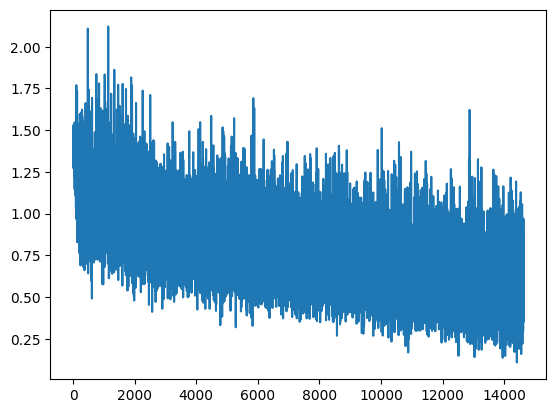

In [33]:
plt.plot(train_losses)

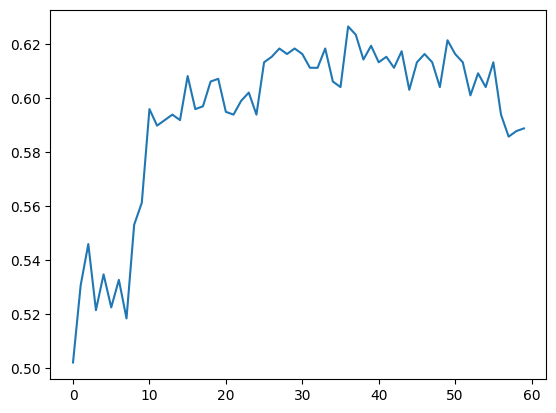

In [34]:
plt.plot(test_accuracy)

In [35]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 577/976 (0.5912)
{'acc_detail': tensor([0.6457, 0.4259, 0.7205, 0.5476], device='cuda:0'),
 'acc_unweighted': tensor(0.5849, device='cuda:0'),
 'acc_weighted': tensor(0.5912, device='cuda:0'),
 'f1s_detail': tensor([0.6708, 0.4444, 0.7079, 0.5188], device='cuda:0'),
 'f1s_unweighted': tensor(0.5855, device='cuda:0'),
 'f1s_weighted': tensor(0.5911, device='cuda:0'),
 'precision_detail': tensor([0.6979, 0.4646, 0.6958, 0.4929], device='cuda:0'),
 'recall_detail': tensor([0.6457, 0.4259, 0.7205, 0.5476], device='cuda:0'),
 'rocauc': tensor(0.8409, device='cuda:0'),
 'rocauc_detail': tensor([0.8913, 0.8034, 0.9072, 0.7618], device='cuda:0'),
 'uar': tensor(0.5849, device='cuda:0'),
 'wap': tensor(0.5928, device='cuda:0')}


tensor([[164,  12,   6,  72],
        [ 19,  92,  52,  53],
        [  9,  45, 183,  17],
        [ 43,  49,  22, 138]], device='cuda:0')

In [36]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13mfcc_best_37epoch.pt
Correct: 614/976 (0.6291)
{'acc_detail': tensor([0.7126, 0.5370, 0.7480, 0.5040], device='cuda:0'),
 'acc_unweighted': tensor(0.6254, device='cuda:0'),
 'acc_weighted': tensor(0.6291, device='cuda:0'),
 'f1s_detail': tensor([0.7183, 0.5309, 0.7280, 0.5194], device='cuda:0'),
 'f1s_unweighted': tensor(0.6241, device='cuda:0'),
 'f1s_weighted': tensor(0.6280, device='cuda:0'),
 'precision_detail': tensor([0.7240, 0.5249, 0.7090, 0.5359], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.5370, 0.7480, 0.5040], device='cuda:0'),
 'rocauc': tensor(0.8527, device='cuda:0'),
 'rocauc_detail': tensor([0.9103, 0.8154, 0.9152, 0.7700], device='cuda:0'),
 'uar': tensor(0.6254, device='cuda:0'),
 'wap': tensor(0.6274, device='cuda:0')}


tensor([[181,  12,   7,  54],
        [ 15, 116,  45,  40],
        [  4,  44, 190,  16],
        [ 50,  49,  26, 127]], device='cuda:0')

In [37]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [38]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.003278688524590164/40 [00:00<39:40, 59.53s/it]

Train Epoch: 61 [0/3918 (0%)]	Loss: 0.274467
Mem before-during-after: 17917440 17992704 18544128


  0%|                                   | 0.13442622950819672/40 [00:08<41:20, 62.23s/it]

Train Epoch: 61 [640/3918 (16%)]	Loss: 0.567479
Mem before-during-after: 18544128 18618368 18544128


  1%|▏                                  | 0.26885245901639304/40 [00:17<41:01, 61.95s/it]

Train Epoch: 61 [1280/3918 (33%)]	Loss: 0.653448
Mem before-during-after: 18544128 18618368 18544128


  1%|▎                                   | 0.4000000000000002/40 [00:25<42:17, 64.09s/it]

Train Epoch: 61 [1920/3918 (49%)]	Loss: 0.483590
Mem before-during-after: 18544128 18618368 18544128


  1%|▍                                   | 0.5278688524590167/40 [00:33<40:08, 61.03s/it]

Train Epoch: 61 [2560/3918 (66%)]	Loss: 0.591114
Mem before-during-after: 18544128 18618368 18544128


  2%|▌                                   | 0.6622950819672118/40 [00:42<39:33, 60.33s/it]

Train Epoch: 61 [3200/3918 (82%)]	Loss: 0.396376
Mem before-during-after: 18544128 18618368 18544128


  2%|▋                                   | 0.7934426229508167/40 [00:50<39:33, 60.53s/it]

Train Epoch: 61 [3840/3918 (98%)]	Loss: 0.544510
Mem before-during-after: 18544128 18618368 18544128


  3%|▉                                   | 1.0032786885245846/40 [01:03<40:53, 62.90s/it]


Test Epoch: 61	Accuracy: 579/976 (59%)

Train Epoch: 62 [0/3918 (0%)]	Loss: 0.861760
Mem before-during-after: 18543104 18618368 18544128


  3%|█                                   | 1.1344262295081895/40 [01:11<39:47, 61.44s/it]

Train Epoch: 62 [640/3918 (16%)]	Loss: 0.382327
Mem before-during-after: 18544128 18618368 18544128


  3%|█▏                                  | 1.2655737704917944/40 [01:19<40:11, 62.27s/it]

Train Epoch: 62 [1280/3918 (33%)]	Loss: 0.426897
Mem before-during-after: 18544128 18618368 18544128


  3%|█▎                                  | 1.3999999999999895/40 [01:28<38:52, 60.44s/it]

Train Epoch: 62 [1920/3918 (49%)]	Loss: 0.210772
Mem before-during-after: 18544128 18618368 18544128


  4%|█▍                                  | 1.5311475409835944/40 [01:36<39:20, 61.36s/it]

Train Epoch: 62 [2560/3918 (66%)]	Loss: 0.308727
Mem before-during-after: 18544128 18618368 18544128


  4%|█▍                                  | 1.6622950819671993/40 [01:44<38:52, 60.83s/it]

Train Epoch: 62 [3200/3918 (82%)]	Loss: 0.515143
Mem before-during-after: 18544128 18618368 18544128


  4%|█▌                                  | 1.7934426229508043/40 [01:52<39:05, 61.40s/it]

Train Epoch: 62 [3840/3918 (98%)]	Loss: 0.390100
Mem before-during-after: 18544128 18618368 18544128


  5%|█▊                                   | 1.999999999999982/40 [02:05<39:21, 62.15s/it]


Test Epoch: 62	Accuracy: 586/976 (60%)



  5%|█▊                                  | 2.0032786885245724/40 [02:05<39:21, 62.15s/it]

Train Epoch: 63 [0/3918 (0%)]	Loss: 0.382223
Mem before-during-after: 18543104 18618368 18544128


  5%|█▉                                  | 2.1377049180327674/40 [02:14<38:23, 60.84s/it]

Train Epoch: 63 [640/3918 (16%)]	Loss: 0.342940
Mem before-during-after: 18544128 18618368 18544128


  6%|██                                  | 2.2688524590163723/40 [02:22<38:08, 60.65s/it]

Train Epoch: 63 [1280/3918 (33%)]	Loss: 0.584051
Mem before-during-after: 18544128 18618368 18544128


  6%|██▏                                 | 2.3999999999999773/40 [02:30<38:21, 61.22s/it]

Train Epoch: 63 [1920/3918 (49%)]	Loss: 0.527848
Mem before-during-after: 18544128 18618368 18544128


  6%|██▎                                  | 2.527868852458992/40 [02:38<37:52, 60.65s/it]

Train Epoch: 63 [2560/3918 (66%)]	Loss: 0.566161
Mem before-during-after: 18544128 18618368 18544128


  7%|██▍                                  | 2.662295081967187/40 [02:46<38:04, 61.19s/it]

Train Epoch: 63 [3200/3918 (82%)]	Loss: 0.443913
Mem before-during-after: 18544128 18618368 18544128


  7%|██▌                                  | 2.793442622950792/40 [02:54<38:33, 62.19s/it]

Train Epoch: 63 [3840/3918 (98%)]	Loss: 0.351814
Mem before-during-after: 18544128 18618368 18544128


  7%|██▊                                   | 2.99999999999997/40 [03:07<36:55, 59.88s/it]


Test Epoch: 63	Accuracy: 586/976 (60%)



  8%|██▊                                   | 3.00327868852456/40 [03:07<37:21, 60.59s/it]

Train Epoch: 64 [0/3918 (0%)]	Loss: 0.571018
Mem before-during-after: 18543104 18618368 18544128


  8%|██▉                                  | 3.137704918032755/40 [03:15<37:09, 60.49s/it]

Train Epoch: 64 [640/3918 (16%)]	Loss: 0.324483
Mem before-during-after: 18544128 18618368 18544128


  8%|███                                   | 3.26557377049177/40 [03:23<37:27, 61.18s/it]

Train Epoch: 64 [1280/3918 (33%)]	Loss: 0.699554
Mem before-during-after: 18544128 18618368 18544128


  8%|███                                 | 3.3967213114753747/40 [03:31<37:06, 60.83s/it]

Train Epoch: 64 [1920/3918 (49%)]	Loss: 0.458807
Mem before-during-after: 18544128 18618368 18544128


  9%|███▏                                | 3.5278688524589796/40 [03:39<37:09, 61.13s/it]

Train Epoch: 64 [2560/3918 (66%)]	Loss: 0.722134
Mem before-during-after: 18544128 18618368 18544128


  9%|███▎                                | 3.6622950819671747/40 [03:47<37:06, 61.29s/it]

Train Epoch: 64 [3200/3918 (82%)]	Loss: 0.515691
Mem before-during-after: 18544128 18618368 18544128


  9%|███▍                                | 3.7934426229507796/40 [03:55<36:49, 61.02s/it]

Train Epoch: 64 [3840/3918 (98%)]	Loss: 0.142019
Mem before-during-after: 18544128 18618368 18544128


 10%|███▌                                | 4.0032786885245475/40 [04:08<37:38, 62.74s/it]


Test Epoch: 64	Accuracy: 576/976 (59%)

Train Epoch: 65 [0/3918 (0%)]	Loss: 0.620300
Mem before-during-after: 18543104 18618368 18544128


 10%|███▋                                | 4.1377049180327425/40 [04:17<36:37, 61.27s/it]

Train Epoch: 65 [640/3918 (16%)]	Loss: 0.730032
Mem before-during-after: 18544128 18618368 18544128


 11%|███▉                                 | 4.265573770491757/40 [04:24<36:25, 61.16s/it]

Train Epoch: 65 [1280/3918 (33%)]	Loss: 0.558162
Mem before-during-after: 18544128 18618368 18544128


 11%|████                                 | 4.399999999999952/40 [04:33<36:19, 61.22s/it]

Train Epoch: 65 [1920/3918 (49%)]	Loss: 0.703896
Mem before-during-after: 18544128 18618368 18544128


 11%|████▏                                | 4.531147540983557/40 [04:41<35:44, 60.47s/it]

Train Epoch: 65 [2560/3918 (66%)]	Loss: 0.854349
Mem before-during-after: 18544128 18618368 18544128


 12%|████▎                                | 4.659016393442572/40 [04:48<35:58, 61.07s/it]

Train Epoch: 65 [3200/3918 (82%)]	Loss: 0.573567
Mem before-during-after: 18544128 18618368 18544128


 12%|████▍                                | 4.793442622950767/40 [04:57<35:34, 60.62s/it]

Train Epoch: 65 [3840/3918 (98%)]	Loss: 0.580662
Mem before-during-after: 18544128 18618368 18544128


 13%|████▋                                | 5.003278688524535/40 [05:09<34:22, 58.93s/it]


Test Epoch: 65	Accuracy: 584/976 (60%)

Train Epoch: 66 [0/3918 (0%)]	Loss: 0.658896
Mem before-during-after: 18543104 18618368 18544128


 13%|████▉                                 | 5.13770491803273/40 [05:18<35:23, 60.92s/it]

Train Epoch: 66 [640/3918 (16%)]	Loss: 0.378449
Mem before-during-after: 18544128 18618368 18544128


 13%|████▊                                | 5.268852459016335/40 [05:26<35:31, 61.39s/it]

Train Epoch: 66 [1280/3918 (33%)]	Loss: 0.749410
Mem before-during-after: 18544128 18618368 18544128


 13%|█████▏                                | 5.39672131147535/40 [05:34<35:04, 60.82s/it]

Train Epoch: 66 [1920/3918 (49%)]	Loss: 0.605251
Mem before-during-after: 18544128 18618368 18544128


 14%|█████                                | 5.531147540983545/40 [05:42<34:47, 60.56s/it]

Train Epoch: 66 [2560/3918 (66%)]	Loss: 0.493831
Mem before-during-after: 18544128 18618368 18544128


 14%|█████▍                                | 5.65901639344256/40 [05:50<34:51, 60.91s/it]

Train Epoch: 66 [3200/3918 (82%)]	Loss: 0.730937
Mem before-during-after: 18544128 18618368 18544128


 14%|█████▎                               | 5.793442622950755/40 [05:59<35:04, 61.53s/it]

Train Epoch: 66 [3840/3918 (98%)]	Loss: 0.541034
Mem before-during-after: 18544128 18618368 18544128


 15%|█████▌                               | 6.003278688524523/40 [06:12<35:06, 61.95s/it]


Test Epoch: 66	Accuracy: 567/976 (58%)

Train Epoch: 67 [0/3918 (0%)]	Loss: 0.509709
Mem before-during-after: 18543104 18618368 18544128


 15%|█████▋                               | 6.137704918032718/40 [06:20<36:35, 64.84s/it]

Train Epoch: 67 [640/3918 (16%)]	Loss: 0.450620
Mem before-during-after: 18544128 18618368 18544128


 16%|█████▋                              | 6.2655737704917325/40 [06:29<35:07, 62.47s/it]

Train Epoch: 67 [1280/3918 (33%)]	Loss: 0.433627
Mem before-during-after: 18544128 18618368 18544128


 16%|█████▊                              | 6.3999999999999275/40 [06:37<34:12, 61.09s/it]

Train Epoch: 67 [1920/3918 (49%)]	Loss: 0.253112
Mem before-during-after: 18544128 18618368 18544128


 16%|█████▉                              | 6.5311475409835325/40 [06:45<35:40, 63.94s/it]

Train Epoch: 67 [2560/3918 (66%)]	Loss: 0.299789
Mem before-during-after: 18544128 18618368 18544128


 17%|██████▏                              | 6.662295081967137/40 [06:53<34:12, 61.55s/it]

Train Epoch: 67 [3200/3918 (82%)]	Loss: 0.530343
Mem before-during-after: 18544128 18618368 18544128


 17%|██████▎                              | 6.790163934426152/40 [07:02<34:19, 62.00s/it]

Train Epoch: 67 [3840/3918 (98%)]	Loss: 0.277769
Mem before-during-after: 18544128 18618368 18544128


 17%|██████▋                               | 6.99999999999992/40 [07:15<33:58, 61.76s/it]


Test Epoch: 67	Accuracy: 574/976 (59%)



 18%|██████▋                               | 7.00327868852451/40 [07:15<35:31, 64.60s/it]

Train Epoch: 68 [0/3918 (0%)]	Loss: 0.320980
Mem before-during-after: 18543104 18618368 18544128


 18%|██████▌                              | 7.137704918032705/40 [07:24<34:00, 62.10s/it]

Train Epoch: 68 [640/3918 (16%)]	Loss: 0.457882
Mem before-during-after: 18544128 18618368 18544128


 18%|██████▉                               | 7.26885245901631/40 [07:32<35:23, 64.89s/it]

Train Epoch: 68 [1280/3918 (33%)]	Loss: 0.547534
Mem before-during-after: 18544128 18618368 18544128


 18%|██████▊                              | 7.399999999999915/40 [07:41<33:53, 62.37s/it]

Train Epoch: 68 [1920/3918 (49%)]	Loss: 0.357140
Mem before-during-after: 18544128 18618368 18544128


 19%|███████▏                              | 7.52786885245893/40 [07:49<34:06, 63.03s/it]

Train Epoch: 68 [2560/3918 (66%)]	Loss: 0.429339
Mem before-during-after: 18544128 18618368 18544128


 19%|███████                              | 7.659016393442535/40 [07:58<33:37, 62.37s/it]

Train Epoch: 68 [3200/3918 (82%)]	Loss: 0.292249
Mem before-during-after: 18544128 18618368 18544128


 19%|███████▍                              | 7.79344262295073/40 [08:06<33:15, 61.95s/it]

Train Epoch: 68 [3840/3918 (98%)]	Loss: 0.429572
Mem before-during-after: 18544128 18618368 18544128


 20%|███████▍                             | 8.003278688524498/40 [08:19<32:26, 60.84s/it]


Test Epoch: 68	Accuracy: 579/976 (59%)

Train Epoch: 69 [0/3918 (0%)]	Loss: 0.155711
Mem before-during-after: 18543104 18618368 18544128


 20%|███████▌                             | 8.134426229508103/40 [08:27<32:18, 60.84s/it]

Train Epoch: 69 [640/3918 (16%)]	Loss: 0.530164
Mem before-during-after: 18544128 18618368 18544128


 21%|███████▋                             | 8.268852459016298/40 [08:36<32:12, 60.90s/it]

Train Epoch: 69 [1280/3918 (33%)]	Loss: 0.423372
Mem before-during-after: 18544128 18618368 18544128


 21%|███████▊                             | 8.396721311475313/40 [08:44<32:12, 61.14s/it]

Train Epoch: 69 [1920/3918 (49%)]	Loss: 0.343739
Mem before-during-after: 18544128 18618368 18544128


 21%|███████▉                             | 8.531147540983508/40 [08:52<33:23, 63.67s/it]

Train Epoch: 69 [2560/3918 (66%)]	Loss: 0.464975
Mem before-during-after: 18544128 18618368 18544128


 22%|████████                             | 8.662295081967113/40 [09:00<33:03, 63.28s/it]

Train Epoch: 69 [3200/3918 (82%)]	Loss: 0.179862
Mem before-during-after: 18544128 18618368 18544128


 22%|████████▏                            | 8.793442622950717/40 [09:09<33:00, 63.46s/it]

Train Epoch: 69 [3840/3918 (98%)]	Loss: 0.316986
Mem before-during-after: 18544128 18618368 18544128


 22%|████████▎                            | 8.999999999999895/40 [09:21<32:03, 62.04s/it]


Test Epoch: 69	Accuracy: 562/976 (57%)



 23%|████████▎                            | 9.003278688524485/40 [09:22<33:36, 65.05s/it]

Train Epoch: 70 [0/3918 (0%)]	Loss: 0.215525
Mem before-during-after: 18543104 18618368 18544128


 23%|████████▋                             | 9.13442622950809/40 [09:30<31:41, 61.60s/it]

Train Epoch: 70 [640/3918 (16%)]	Loss: 0.586171
Mem before-during-after: 18544128 18618368 18544128


 23%|████████▌                            | 9.268852459016285/40 [09:38<31:06, 60.73s/it]

Train Epoch: 70 [1280/3918 (33%)]	Loss: 1.093087
Mem before-during-after: 18544128 18618368 18544128


 23%|████████▉                             | 9.39999999999989/40 [09:46<31:21, 61.48s/it]

Train Epoch: 70 [1920/3918 (49%)]	Loss: 0.281872
Mem before-during-after: 18544128 18618368 18544128


 24%|████████▊                            | 9.531147540983495/40 [09:54<31:06, 61.25s/it]

Train Epoch: 70 [2560/3918 (66%)]	Loss: 0.925661
Mem before-during-after: 18544128 18618368 18544128


 24%|█████████▍                             | 9.6622950819671/40 [10:02<30:42, 60.72s/it]

Train Epoch: 70 [3200/3918 (82%)]	Loss: 0.320470
Mem before-during-after: 18544128 18618368 18544128


 24%|█████████                            | 9.790163934426115/40 [10:10<31:04, 61.72s/it]

Train Epoch: 70 [3840/3918 (98%)]	Loss: 0.722294
Mem before-during-after: 18544128 18618368 18544128


 25%|█████████▏                           | 9.999999999999883/40 [10:23<31:20, 62.68s/it]


Test Epoch: 70	Accuracy: 565/976 (58%)



 25%|█████████                           | 10.003278688524473/40 [10:23<31:18, 62.61s/it]

Train Epoch: 71 [0/3918 (0%)]	Loss: 0.271884
Mem before-during-after: 18543104 18618368 18544128


 25%|█████████                           | 10.137704918032668/40 [10:32<29:43, 59.74s/it]

Train Epoch: 71 [640/3918 (16%)]	Loss: 0.454337
Mem before-during-after: 18544128 18618368 18544128


 26%|█████████▏                          | 10.268852459016273/40 [10:40<30:44, 62.04s/it]

Train Epoch: 71 [1280/3918 (33%)]	Loss: 0.606490
Mem before-during-after: 18544128 18618368 18544128


 26%|█████████▎                          | 10.396721311475288/40 [10:48<33:07, 67.15s/it]

Train Epoch: 71 [1920/3918 (49%)]	Loss: 0.434504
Mem before-during-after: 18544128 18618368 18544128


 26%|█████████▍                          | 10.527868852458893/40 [10:57<31:34, 64.29s/it]

Train Epoch: 71 [2560/3918 (66%)]	Loss: 0.826700
Mem before-during-after: 18544128 18618368 18544128


 27%|█████████▌                          | 10.659016393442498/40 [11:05<30:05, 61.54s/it]

Train Epoch: 71 [3200/3918 (82%)]	Loss: 0.565275
Mem before-during-after: 18544128 18618368 18544128


 27%|█████████▋                          | 10.793442622950693/40 [11:14<30:36, 62.89s/it]

Train Epoch: 71 [3840/3918 (98%)]	Loss: 0.282518
Mem before-during-after: 18544128 18618368 18544128


 28%|██████████▏                          | 11.00327868852446/40 [11:27<29:31, 61.09s/it]


Test Epoch: 71	Accuracy: 564/976 (58%)

Train Epoch: 72 [0/3918 (0%)]	Loss: 0.551957
Mem before-during-after: 18543104 18618368 18544128


 28%|██████████                          | 11.137704918032655/40 [11:36<29:56, 62.24s/it]

Train Epoch: 72 [640/3918 (16%)]	Loss: 0.991751
Mem before-during-after: 18544128 18618368 18544128


 28%|██████████▍                          | 11.26885245901626/40 [11:44<29:16, 61.12s/it]

Train Epoch: 72 [1280/3918 (33%)]	Loss: 0.633467
Mem before-during-after: 18544128 18618368 18544128


 28%|██████████▎                         | 11.396721311475275/40 [11:52<28:58, 60.77s/it]

Train Epoch: 72 [1920/3918 (49%)]	Loss: 0.417453
Mem before-during-after: 18544128 18618368 18544128


 29%|██████████▋                          | 11.52786885245888/40 [12:00<30:03, 63.34s/it]

Train Epoch: 72 [2560/3918 (66%)]	Loss: 0.642621
Mem before-during-after: 18544128 18618368 18544128


 29%|██████████▍                         | 11.662295081967075/40 [12:09<29:45, 63.01s/it]

Train Epoch: 72 [3200/3918 (82%)]	Loss: 0.635277
Mem before-during-after: 18544128 18618368 18544128


 29%|██████████▉                          | 11.79016393442609/40 [12:17<30:15, 64.36s/it]

Train Epoch: 72 [3840/3918 (98%)]	Loss: 0.375727
Mem before-during-after: 18544128 18618368 18544128


 30%|██████████▊                         | 11.999999999999858/40 [12:31<28:58, 62.09s/it]


Test Epoch: 72	Accuracy: 571/976 (58%)



 30%|██████████▊                         | 12.003278688524448/40 [12:31<29:17, 62.78s/it]

Train Epoch: 73 [0/3918 (0%)]	Loss: 0.449198
Mem before-during-after: 18543104 18618368 18544128


 30%|██████████▉                         | 12.134426229508053/40 [12:39<29:43, 64.00s/it]

Train Epoch: 73 [640/3918 (16%)]	Loss: 0.491447
Mem before-during-after: 18544128 18618368 18544128


 31%|███████████                         | 12.265573770491658/40 [12:48<28:52, 62.47s/it]

Train Epoch: 73 [1280/3918 (33%)]	Loss: 0.123638
Mem before-during-after: 18544128 18618368 18544128


 31%|███████████▏                        | 12.396721311475263/40 [12:56<28:03, 61.00s/it]

Train Epoch: 73 [1920/3918 (49%)]	Loss: 0.357611
Mem before-during-after: 18544128 18618368 18544128


 31%|███████████▎                        | 12.531147540983458/40 [13:04<27:52, 60.90s/it]

Train Epoch: 73 [2560/3918 (66%)]	Loss: 0.518575
Mem before-during-after: 18544128 18618368 18544128


 32%|███████████▍                        | 12.659016393442473/40 [13:13<29:00, 63.65s/it]

Train Epoch: 73 [3200/3918 (82%)]	Loss: 0.555812
Mem before-during-after: 18544128 18618368 18544128


 32%|███████████▌                        | 12.790163934426078/40 [13:21<28:47, 63.49s/it]

Train Epoch: 73 [3840/3918 (98%)]	Loss: 0.534083
Mem before-during-after: 18544128 18618368 18544128


 33%|███████████▋                        | 13.003278688524436/40 [13:35<27:46, 61.74s/it]


Test Epoch: 73	Accuracy: 565/976 (58%)

Train Epoch: 74 [0/3918 (0%)]	Loss: 0.349198
Mem before-during-after: 18543104 18618368 18544128


 33%|████████████▏                        | 13.13770491803263/40 [13:43<27:33, 61.55s/it]

Train Epoch: 74 [640/3918 (16%)]	Loss: 0.557102
Mem before-during-after: 18544128 18618368 18544128


 33%|███████████▉                        | 13.268852459016236/40 [13:51<27:10, 60.99s/it]

Train Epoch: 74 [1280/3918 (33%)]	Loss: 0.357965
Mem before-during-after: 18544128 18618368 18544128


 33%|████████████▍                        | 13.39672131147525/40 [13:59<27:53, 62.92s/it]

Train Epoch: 74 [1920/3918 (49%)]	Loss: 0.498229
Mem before-during-after: 18544128 18618368 18544128


 34%|████████████▏                       | 13.531147540983445/40 [14:08<27:12, 61.69s/it]

Train Epoch: 74 [2560/3918 (66%)]	Loss: 0.682626
Mem before-during-after: 18544128 18618368 18544128


 34%|████████████▋                        | 13.66229508196705/40 [14:16<26:43, 60.88s/it]

Train Epoch: 74 [3200/3918 (82%)]	Loss: 0.375781
Mem before-during-after: 18544128 18618368 18544128


 34%|████████████▍                       | 13.793442622950655/40 [14:24<26:21, 60.34s/it]

Train Epoch: 74 [3840/3918 (98%)]	Loss: 0.457116
Mem before-during-after: 18544128 18618368 18544128


 35%|████████████▌                       | 14.003278688524423/40 [14:37<28:51, 66.61s/it]


Test Epoch: 74	Accuracy: 557/976 (57%)

Train Epoch: 75 [0/3918 (0%)]	Loss: 0.360068
Mem before-during-after: 18543104 18618368 18544128


 35%|████████████▋                       | 14.134426229508028/40 [14:45<25:42, 59.63s/it]

Train Epoch: 75 [640/3918 (16%)]	Loss: 0.534560
Mem before-during-after: 18544128 18618368 18544128


 36%|████████████▊                       | 14.268852459016223/40 [14:53<25:59, 60.60s/it]

Train Epoch: 75 [1280/3918 (33%)]	Loss: 0.365180
Mem before-during-after: 18544128 18618368 18544128


 36%|████████████▉                       | 14.396721311475238/40 [15:02<26:44, 62.66s/it]

Train Epoch: 75 [1920/3918 (49%)]	Loss: 0.689944
Mem before-during-after: 18544128 18618368 18544128


 36%|█████████████                       | 14.527868852458843/40 [15:10<26:47, 63.11s/it]

Train Epoch: 75 [2560/3918 (66%)]	Loss: 0.424174
Mem before-during-after: 18544128 18618368 18544128


 37%|█████████████▏                      | 14.662295081967038/40 [15:19<25:12, 59.71s/it]

Train Epoch: 75 [3200/3918 (82%)]	Loss: 0.381212
Mem before-during-after: 18544128 18618368 18544128


 37%|█████████████▎                      | 14.793442622950643/40 [15:27<25:23, 60.44s/it]

Train Epoch: 75 [3840/3918 (98%)]	Loss: 0.282213
Mem before-during-after: 18544128 18618368 18544128


 38%|█████████████▉                       | 15.00327868852441/40 [15:39<24:52, 59.72s/it]


Test Epoch: 75	Accuracy: 582/976 (59%)

Train Epoch: 76 [0/3918 (0%)]	Loss: 0.380861
Mem before-during-after: 18543104 18618368 18544128


 38%|█████████████▌                      | 15.137704918032606/40 [15:48<25:04, 60.50s/it]

Train Epoch: 76 [640/3918 (16%)]	Loss: 0.360527
Mem before-during-after: 18544128 18618368 18544128


 38%|██████████████                       | 15.26885245901621/40 [15:56<26:37, 64.58s/it]

Train Epoch: 76 [1280/3918 (33%)]	Loss: 0.467980
Mem before-during-after: 18544128 18618368 18544128


 38%|█████████████▊                      | 15.399999999999816/40 [16:04<26:13, 63.95s/it]

Train Epoch: 76 [1920/3918 (49%)]	Loss: 0.913157
Mem before-during-after: 18544128 18618368 18544128


 39%|██████████████▎                      | 15.53114754098342/40 [16:12<24:46, 60.75s/it]

Train Epoch: 76 [2560/3918 (66%)]	Loss: 0.524228
Mem before-during-after: 18544128 18618368 18544128


 39%|██████████████                      | 15.662295081967025/40 [16:21<24:25, 60.23s/it]

Train Epoch: 76 [3200/3918 (82%)]	Loss: 0.591812
Mem before-during-after: 18544128 18618368 18544128


 39%|██████████████▌                      | 15.79344262295063/40 [16:28<24:32, 60.83s/it]

Train Epoch: 76 [3840/3918 (98%)]	Loss: 0.473030
Mem before-during-after: 18544128 18618368 18544128


 40%|███████████████▏                      | 16.0032786885244/40 [16:42<24:13, 60.58s/it]


Test Epoch: 76	Accuracy: 585/976 (60%)

Train Epoch: 77 [0/3918 (0%)]	Loss: 1.019477
Mem before-during-after: 18543104 18618368 18544128


 40%|██████████████▌                     | 16.134426229508076/40 [16:50<24:59, 62.81s/it]

Train Epoch: 77 [640/3918 (16%)]	Loss: 0.348349
Mem before-during-after: 18544128 18618368 18544128


 41%|██████████████▋                     | 16.265573770491752/40 [16:58<24:07, 60.98s/it]

Train Epoch: 77 [1280/3918 (33%)]	Loss: 0.553699
Mem before-during-after: 18544128 18618368 18544128


 41%|███████████████▏                     | 16.40000000000002/40 [17:06<24:01, 61.10s/it]

Train Epoch: 77 [1920/3918 (49%)]	Loss: 0.439339
Mem before-during-after: 18544128 18618368 18544128


 41%|██████████████▉                     | 16.531147540983696/40 [17:14<25:25, 65.00s/it]

Train Epoch: 77 [2560/3918 (66%)]	Loss: 0.523121
Mem before-during-after: 18544128 18618368 18544128


 42%|██████████████▉                     | 16.662295081967372/40 [17:22<24:25, 62.80s/it]

Train Epoch: 77 [3200/3918 (82%)]	Loss: 0.468308
Mem before-during-after: 18544128 18618368 18544128


 42%|███████████████                     | 16.793442622951048/40 [17:30<23:41, 61.24s/it]

Train Epoch: 77 [3840/3918 (98%)]	Loss: 0.372865
Mem before-during-after: 18544128 18618368 18544128


 43%|███████████████▎                    | 17.000000000000338/40 [17:43<23:12, 60.55s/it]


Test Epoch: 77	Accuracy: 551/976 (56%)



 43%|███████████████▋                     | 17.00655737704952/40 [17:44<23:12, 60.57s/it]

Train Epoch: 78 [0/3918 (0%)]	Loss: 0.210093
Mem before-during-after: 18543104 18618368 18544128


 43%|███████████████▍                    | 17.137704918033197/40 [17:52<23:11, 60.87s/it]

Train Epoch: 78 [640/3918 (16%)]	Loss: 0.136688
Mem before-during-after: 18544128 18618368 18544128


 43%|███████████████▉                     | 17.26557377049228/40 [17:59<23:53, 63.05s/it]

Train Epoch: 78 [1280/3918 (33%)]	Loss: 0.503938
Mem before-during-after: 18544128 18618368 18544128


 44%|████████████████                     | 17.40000000000055/40 [18:08<23:26, 62.25s/it]

Train Epoch: 78 [1920/3918 (49%)]	Loss: 0.570240
Mem before-during-after: 18544128 18618368 18544128


 44%|███████████████▊                    | 17.527868852459633/40 [18:16<22:26, 59.92s/it]

Train Epoch: 78 [2560/3918 (66%)]	Loss: 0.309162
Mem before-during-after: 18544128 18618368 18544128


 44%|████████████████▊                     | 17.6622950819679/40 [18:24<23:11, 62.28s/it]

Train Epoch: 78 [3200/3918 (82%)]	Loss: 0.436844
Mem before-during-after: 18544128 18618368 18544128


 44%|████████████████                    | 17.793442622951577/40 [18:32<23:45, 64.21s/it]

Train Epoch: 78 [3840/3918 (98%)]	Loss: 0.350954
Mem before-during-after: 18544128 18618368 18544128


 45%|████████████████▏                   | 18.000000000000867/40 [18:45<22:55, 62.51s/it]


Test Epoch: 78	Accuracy: 571/976 (58%)



 45%|████████████████▋                    | 18.00327868852546/40 [18:45<23:06, 63.04s/it]

Train Epoch: 79 [0/3918 (0%)]	Loss: 0.611718
Mem before-during-after: 18543104 18618368 18544128


 45%|████████████████▎                   | 18.134426229509135/40 [18:54<25:41, 70.51s/it]

Train Epoch: 79 [640/3918 (16%)]	Loss: 0.283785
Mem before-during-after: 18544128 18618368 18544128


 46%|████████████████▍                   | 18.268852459017403/40 [19:02<21:38, 59.74s/it]

Train Epoch: 79 [1280/3918 (33%)]	Loss: 0.447044
Mem before-during-after: 18544128 18618368 18544128


 46%|█████████████████                    | 18.40000000000108/40 [19:10<21:43, 60.33s/it]

Train Epoch: 79 [1920/3918 (49%)]	Loss: 0.239732
Mem before-during-after: 18544128 18618368 18544128


 46%|████████████████▋                   | 18.527868852460163/40 [19:18<21:41, 60.62s/it]

Train Epoch: 79 [2560/3918 (66%)]	Loss: 0.758108
Mem before-during-after: 18544128 18618368 18544128


 47%|█████████████████▎                   | 18.66229508196843/40 [19:27<21:33, 60.61s/it]

Train Epoch: 79 [3200/3918 (82%)]	Loss: 0.661533
Mem before-during-after: 18544128 18618368 18544128


 47%|████████████████▉                   | 18.790163934427515/40 [19:35<21:47, 61.67s/it]

Train Epoch: 79 [3840/3918 (98%)]	Loss: 0.432497
Mem before-during-after: 18544128 18618368 18544128


 48%|█████████████████                   | 19.000000000001396/40 [19:47<22:11, 63.41s/it]


Test Epoch: 79	Accuracy: 551/976 (56%)



 48%|█████████████████                   | 19.003278688525988/40 [19:48<23:13, 66.38s/it]

Train Epoch: 80 [0/3918 (0%)]	Loss: 0.534191
Mem before-during-after: 18543104 18618368 18544128


 48%|█████████████████▏                  | 19.134426229509664/40 [19:56<22:51, 65.73s/it]

Train Epoch: 80 [640/3918 (16%)]	Loss: 0.407318
Mem before-during-after: 18544128 18618368 18544128


 48%|█████████████████▎                  | 19.268852459017932/40 [20:04<21:07, 61.15s/it]

Train Epoch: 80 [1280/3918 (33%)]	Loss: 0.582045
Mem before-during-after: 18544128 18618368 18544128


 49%|█████████████████▍                  | 19.400000000001608/40 [20:13<24:14, 70.60s/it]

Train Epoch: 80 [1920/3918 (49%)]	Loss: 0.297018
Mem before-during-after: 18544128 18618368 18544128


 49%|█████████████████▌                  | 19.531147540985284/40 [20:21<21:14, 62.25s/it]

Train Epoch: 80 [2560/3918 (66%)]	Loss: 0.440422
Mem before-during-after: 18544128 18618368 18544128


 49%|██████████████████▏                  | 19.66229508196896/40 [20:29<20:49, 61.43s/it]

Train Epoch: 80 [3200/3918 (82%)]	Loss: 0.294565
Mem before-during-after: 18544128 18618368 18544128


 49%|█████████████████▊                  | 19.793442622952636/40 [20:37<20:11, 59.96s/it]

Train Epoch: 80 [3840/3918 (98%)]	Loss: 0.414379
Mem before-during-after: 18544128 18618368 18544128


 50%|██████████████████                  | 20.003278688526517/40 [20:50<20:10, 60.55s/it]


Test Epoch: 80	Accuracy: 548/976 (56%)

Train Epoch: 81 [0/3918 (0%)]	Loss: 0.335957
Mem before-during-after: 18543104 18618368 18544128


 50%|██████████████████                  | 20.134426229510193/40 [20:58<20:46, 62.73s/it]

Train Epoch: 81 [640/3918 (16%)]	Loss: 0.537318
Mem before-during-after: 18544128 18618368 18544128


 51%|██████████████████▋                  | 20.26885245901846/40 [21:07<20:14, 61.53s/it]

Train Epoch: 81 [1280/3918 (33%)]	Loss: 0.324975
Mem before-during-after: 18544128 18618368 18544128


 51%|██████████████████▎                 | 20.396721311477545/40 [21:15<20:19, 62.19s/it]

Train Epoch: 81 [1920/3918 (49%)]	Loss: 0.207349
Mem before-during-after: 18544128 18618368 18544128


 51%|██████████████████▉                  | 20.52786885246122/40 [21:23<20:23, 62.84s/it]

Train Epoch: 81 [2560/3918 (66%)]	Loss: 0.228989
Mem before-during-after: 18544128 18618368 18544128


 52%|██████████████████▌                 | 20.659016393444897/40 [21:31<19:51, 61.62s/it]

Train Epoch: 81 [3200/3918 (82%)]	Loss: 0.533745
Mem before-during-after: 18544128 18618368 18544128


 52%|██████████████████▋                 | 20.793442622953165/40 [21:40<19:33, 61.09s/it]

Train Epoch: 81 [3840/3918 (98%)]	Loss: 0.449659
Mem before-during-after: 18544128 18618368 18544128


 53%|██████████████████▉                 | 21.000000000002455/40 [21:52<19:05, 60.27s/it]


Test Epoch: 81	Accuracy: 546/976 (56%)



 53%|██████████████████▉                 | 21.003278688527047/40 [21:52<19:33, 61.75s/it]

Train Epoch: 82 [0/3918 (0%)]	Loss: 0.556342
Mem before-during-after: 18543104 18618368 18544128


 53%|███████████████████                 | 21.134426229510723/40 [22:01<19:13, 61.12s/it]

Train Epoch: 82 [640/3918 (16%)]	Loss: 0.238580
Mem before-during-after: 18544128 18618368 18544128


 53%|███████████████████▋                 | 21.26885245901899/40 [22:09<19:15, 61.68s/it]

Train Epoch: 82 [1280/3918 (33%)]	Loss: 0.237980
Mem before-during-after: 18544128 18618368 18544128


 53%|███████████████████▎                | 21.396721311478075/40 [22:17<18:54, 60.99s/it]

Train Epoch: 82 [1920/3918 (49%)]	Loss: 0.227901
Mem before-during-after: 18544128 18618368 18544128


 54%|███████████████████▉                 | 21.52786885246175/40 [22:25<19:04, 61.95s/it]

Train Epoch: 82 [2560/3918 (66%)]	Loss: 0.275186
Mem before-during-after: 18544128 18618368 18544128


 54%|███████████████████▍                | 21.659016393445427/40 [22:33<19:40, 64.38s/it]

Train Epoch: 82 [3200/3918 (82%)]	Loss: 0.563788
Mem before-during-after: 18544128 18618368 18544128


 54%|███████████████████▌                | 21.790163934429103/40 [22:41<18:36, 61.33s/it]

Train Epoch: 82 [3840/3918 (98%)]	Loss: 0.422613
Mem before-during-after: 18544128 18618368 18544128


 55%|███████████████████▊                | 22.000000000002984/40 [22:54<18:20, 61.16s/it]


Test Epoch: 82	Accuracy: 565/976 (58%)



 55%|███████████████████▊                | 22.003278688527576/40 [22:55<18:35, 61.99s/it]

Train Epoch: 83 [0/3918 (0%)]	Loss: 0.295819
Mem before-during-after: 18543104 18618368 18544128


 55%|███████████████████▉                | 22.137704918035844/40 [23:03<18:14, 61.30s/it]

Train Epoch: 83 [640/3918 (16%)]	Loss: 0.261122
Mem before-during-after: 18544128 18618368 18544128


 56%|████████████████████                | 22.265573770494928/40 [23:11<18:17, 61.91s/it]

Train Epoch: 83 [1280/3918 (33%)]	Loss: 0.575142
Mem before-during-after: 18544128 18618368 18544128


 56%|████████████████████▏               | 22.396721311478604/40 [23:19<18:04, 61.60s/it]

Train Epoch: 83 [1920/3918 (49%)]	Loss: 0.195362
Mem before-during-after: 18544128 18618368 18544128


 56%|████████████████████▎               | 22.531147540986872/40 [23:27<17:44, 60.96s/it]

Train Epoch: 83 [2560/3918 (66%)]	Loss: 0.368047
Mem before-during-after: 18544128 18618368 18544128


 57%|████████████████████▍               | 22.662295081970548/40 [23:35<18:00, 62.34s/it]

Train Epoch: 83 [3200/3918 (82%)]	Loss: 0.339953
Mem before-during-after: 18544128 18618368 18544128


 57%|████████████████████▌               | 22.790163934429632/40 [23:43<17:41, 61.70s/it]

Train Epoch: 83 [3840/3918 (98%)]	Loss: 0.134399
Mem before-during-after: 18544128 18618368 18544128


 58%|████████████████████▋               | 23.003278688528106/40 [23:57<17:18, 61.11s/it]


Test Epoch: 83	Accuracy: 563/976 (57%)

Train Epoch: 84 [0/3918 (0%)]	Loss: 0.324043
Mem before-during-after: 18543104 18618368 18544128


 58%|████████████████████▊               | 23.137704918036373/40 [24:05<17:20, 61.70s/it]

Train Epoch: 84 [640/3918 (16%)]	Loss: 0.209915
Mem before-during-after: 18544128 18618368 18544128


 58%|████████████████████▉               | 23.265573770495457/40 [24:13<17:18, 62.08s/it]

Train Epoch: 84 [1280/3918 (33%)]	Loss: 0.507784
Mem before-during-after: 18544128 18618368 18544128


 58%|█████████████████████               | 23.396721311479133/40 [24:21<17:24, 62.92s/it]

Train Epoch: 84 [1920/3918 (49%)]	Loss: 0.325831
Mem before-during-after: 18544128 18618368 18544128


 59%|██████████████████████▎               | 23.5311475409874/40 [24:29<16:46, 61.14s/it]

Train Epoch: 84 [2560/3918 (66%)]	Loss: 0.231358
Mem before-during-after: 18544128 18618368 18544128


 59%|█████████████████████▎              | 23.659016393446485/40 [24:37<16:56, 62.22s/it]

Train Epoch: 84 [3200/3918 (82%)]	Loss: 0.279387
Mem before-during-after: 18544128 18618368 18544128


 59%|██████████████████████               | 23.79016393443016/40 [24:46<16:21, 60.54s/it]

Train Epoch: 84 [3840/3918 (98%)]	Loss: 0.612174
Mem before-during-after: 18544128 18618368 18544128


 60%|█████████████████████▌              | 24.003278688528635/40 [24:59<16:09, 60.61s/it]


Test Epoch: 84	Accuracy: 582/976 (59%)

Train Epoch: 85 [0/3918 (0%)]	Loss: 0.306574
Mem before-during-after: 18543104 18618368 18544128


 60%|█████████████████████▋              | 24.137704918036903/40 [25:07<16:08, 61.03s/it]

Train Epoch: 85 [640/3918 (16%)]	Loss: 0.267618
Mem before-during-after: 18544128 18618368 18544128


 61%|██████████████████████▍              | 24.26885245902058/40 [25:15<16:04, 61.29s/it]

Train Epoch: 85 [1280/3918 (33%)]	Loss: 0.069348
Mem before-during-after: 18544128 18618368 18544128


 61%|█████████████████████▉              | 24.400000000004255/40 [25:23<15:54, 61.17s/it]

Train Epoch: 85 [1920/3918 (49%)]	Loss: 0.460990
Mem before-during-after: 18544128 18618368 18544128


 61%|██████████████████████▋              | 24.52786885246334/40 [25:31<16:03, 62.30s/it]

Train Epoch: 85 [2560/3918 (66%)]	Loss: 0.432178
Mem before-during-after: 18544128 18618368 18544128


 62%|██████████████████████▏             | 24.659016393447015/40 [25:40<16:14, 63.54s/it]

Train Epoch: 85 [3200/3918 (82%)]	Loss: 0.775313
Mem before-during-after: 18544128 18618368 18544128


 62%|██████████████████████▉              | 24.79016393443069/40 [25:48<16:23, 64.63s/it]

Train Epoch: 85 [3840/3918 (98%)]	Loss: 0.335865
Mem before-during-after: 18544128 18618368 18544128


 63%|██████████████████████▌             | 25.003278688529164/40 [26:01<15:21, 61.43s/it]


Test Epoch: 85	Accuracy: 559/976 (57%)

Train Epoch: 86 [0/3918 (0%)]	Loss: 0.395481
Mem before-during-after: 18543104 18618368 18544128


 63%|██████████████████████▌             | 25.137704918037432/40 [26:09<15:37, 63.06s/it]

Train Epoch: 86 [640/3918 (16%)]	Loss: 0.051820
Mem before-during-after: 18544128 18618368 18544128


 63%|██████████████████████▋             | 25.265573770496516/40 [26:17<15:38, 63.68s/it]

Train Epoch: 86 [1280/3918 (33%)]	Loss: 0.418457
Mem before-during-after: 18544128 18618368 18544128


 64%|██████████████████████▊             | 25.400000000004784/40 [26:26<14:48, 60.86s/it]

Train Epoch: 86 [1920/3918 (49%)]	Loss: 0.184314
Mem before-during-after: 18544128 18618368 18544128


 64%|███████████████████████▌             | 25.53114754098846/40 [26:34<15:07, 62.73s/it]

Train Epoch: 86 [2560/3918 (66%)]	Loss: 0.361696
Mem before-during-after: 18544128 18618368 18544128


 64%|███████████████████████             | 25.659016393447544/40 [26:42<14:47, 61.86s/it]

Train Epoch: 86 [3200/3918 (82%)]	Loss: 0.271524
Mem before-during-after: 18544128 18618368 18544128


 64%|███████████████████████▏            | 25.793442622955812/40 [26:51<14:28, 61.15s/it]

Train Epoch: 86 [3840/3918 (98%)]	Loss: 0.253432
Mem before-during-after: 18544128 18618368 18544128


 65%|███████████████████████▍            | 26.003278688529694/40 [27:03<14:01, 60.12s/it]


Test Epoch: 86	Accuracy: 542/976 (55%)

Train Epoch: 87 [0/3918 (0%)]	Loss: 0.474036
Mem before-during-after: 18543104 18618368 18544128


 65%|████████████████████████▏            | 26.13770491803796/40 [27:12<14:07, 61.17s/it]

Train Epoch: 87 [640/3918 (16%)]	Loss: 0.349540
Mem before-during-after: 18544128 18618368 18544128


 66%|███████████████████████▋            | 26.265573770497046/40 [27:20<13:56, 60.89s/it]

Train Epoch: 87 [1280/3918 (33%)]	Loss: 0.260116
Mem before-during-after: 18544128 18618368 18544128


 66%|████████████████████████▍            | 26.39672131148072/40 [27:28<13:56, 61.48s/it]

Train Epoch: 87 [1920/3918 (49%)]	Loss: 0.798315
Mem before-during-after: 18544128 18618368 18544128


 66%|████████████████████████▌            | 26.53114754098899/40 [27:36<13:36, 60.62s/it]

Train Epoch: 87 [2560/3918 (66%)]	Loss: 0.077572
Mem before-during-after: 18544128 18618368 18544128


 67%|███████████████████████▉            | 26.662295081972665/40 [27:44<13:30, 60.79s/it]

Train Epoch: 87 [3200/3918 (82%)]	Loss: 0.092109
Mem before-during-after: 18544128 18618368 18544128


 67%|████████████████████████▊            | 26.79344262295634/40 [27:52<13:32, 61.53s/it]

Train Epoch: 87 [3840/3918 (98%)]	Loss: 0.180107
Mem before-during-after: 18544128 18618368 18544128


 68%|████████████████████████▉            | 27.00000000000563/40 [28:05<13:21, 61.69s/it]


Test Epoch: 87	Accuracy: 557/976 (57%)



 68%|████████████████████████▎           | 27.003278688530223/40 [28:05<13:27, 62.10s/it]

Train Epoch: 88 [0/3918 (0%)]	Loss: 0.623546
Mem before-during-after: 18543104 18618368 18544128


 68%|█████████████████████████▊            | 27.1344262295139/40 [28:14<13:33, 63.26s/it]

Train Epoch: 88 [640/3918 (16%)]	Loss: 0.226563
Mem before-during-after: 18544128 18618368 18544128


 68%|████████████████████████▌           | 27.265573770497575/40 [28:22<13:28, 63.49s/it]

Train Epoch: 88 [1280/3918 (33%)]	Loss: 0.298847
Mem before-during-after: 18544128 18618368 18544128


 68%|█████████████████████████▎           | 27.39672131148125/40 [28:30<12:45, 60.73s/it]

Train Epoch: 88 [1920/3918 (49%)]	Loss: 0.243327
Mem before-during-after: 18544128 18618368 18544128


 69%|████████████████████████▊           | 27.527868852464927/40 [28:38<13:06, 63.10s/it]

Train Epoch: 88 [2560/3918 (66%)]	Loss: 0.597602
Mem before-during-after: 18544128 18618368 18544128


 69%|████████████████████████▉           | 27.662295081973195/40 [28:47<12:39, 61.55s/it]

Train Epoch: 88 [3200/3918 (82%)]	Loss: 0.214678
Mem before-during-after: 18544128 18618368 18544128


 69%|█████████████████████████▋           | 27.79016393443228/40 [28:55<12:47, 62.82s/it]

Train Epoch: 88 [3840/3918 (98%)]	Loss: 0.258069
Mem before-during-after: 18544128 18618368 18544128


 70%|█████████████████████████▏          | 28.003278688530752/40 [29:08<12:35, 62.99s/it]


Test Epoch: 88	Accuracy: 571/976 (58%)

Train Epoch: 89 [0/3918 (0%)]	Loss: 0.496965
Mem before-during-after: 18543104 18618368 18544128


 70%|██████████████████████████           | 28.13770491803902/40 [29:16<12:05, 61.14s/it]

Train Epoch: 89 [640/3918 (16%)]	Loss: 0.607488
Mem before-during-after: 18544128 18618368 18544128


 71%|█████████████████████████▍          | 28.268852459022696/40 [29:24<12:04, 61.72s/it]

Train Epoch: 89 [1280/3918 (33%)]	Loss: 0.364250
Mem before-during-after: 18544128 18618368 18544128


 71%|█████████████████████████▌          | 28.400000000006372/40 [29:33<11:58, 61.91s/it]

Train Epoch: 89 [1920/3918 (49%)]	Loss: 0.248986
Mem before-during-after: 18544128 18618368 18544128


 71%|█████████████████████████▋          | 28.527868852465456/40 [29:41<12:10, 63.66s/it]

Train Epoch: 89 [2560/3918 (66%)]	Loss: 0.528002
Mem before-during-after: 18544128 18618368 18544128


 72%|█████████████████████████▊          | 28.659016393449132/40 [29:49<11:56, 63.17s/it]

Train Epoch: 89 [3200/3918 (82%)]	Loss: 0.168036
Mem before-during-after: 18544128 18618368 18544128


 72%|███████████████████████████▎          | 28.7934426229574/40 [29:57<11:16, 60.33s/it]

Train Epoch: 89 [3840/3918 (98%)]	Loss: 0.262162
Mem before-during-after: 18544128 18618368 18544128


 73%|██████████████████████████▊          | 29.00327868853128/40 [30:10<11:19, 61.79s/it]


Test Epoch: 89	Accuracy: 573/976 (58%)

Train Epoch: 90 [0/3918 (0%)]	Loss: 0.288454
Mem before-during-after: 18543104 18618368 18544128


 73%|██████████████████████████▏         | 29.134426229514958/40 [30:19<11:03, 61.09s/it]

Train Epoch: 90 [640/3918 (16%)]	Loss: 0.145813
Mem before-during-after: 18544128 18618368 18544128


 73%|██████████████████████████▎         | 29.268852459023226/40 [30:27<10:59, 61.44s/it]

Train Epoch: 90 [1280/3918 (33%)]	Loss: 0.303994
Mem before-during-after: 18544128 18618368 18544128


 73%|███████████████████████████▏         | 29.39672131148231/40 [30:35<10:59, 62.16s/it]

Train Epoch: 90 [1920/3918 (49%)]	Loss: 0.164931
Mem before-during-after: 18544128 18618368 18544128


 74%|██████████████████████████▌         | 29.527868852465986/40 [30:43<10:30, 60.18s/it]

Train Epoch: 90 [2560/3918 (66%)]	Loss: 0.506869
Mem before-during-after: 18544128 18618368 18544128


 74%|███████████████████████████▍         | 29.65901639344966/40 [30:51<10:47, 62.59s/it]

Train Epoch: 90 [3200/3918 (82%)]	Loss: 0.144166
Mem before-during-after: 18544128 18618368 18544128


 74%|███████████████████████████▌         | 29.79344262295793/40 [31:00<11:07, 65.36s/it]

Train Epoch: 90 [3840/3918 (98%)]	Loss: 0.561102
Mem before-during-after: 18544128 18618368 18544128


 75%|███████████████████████████▊         | 30.00000000000722/40 [31:12<10:15, 61.58s/it]


Test Epoch: 90	Accuracy: 583/976 (59%)



 75%|███████████████████████████▊         | 30.00327868853181/40 [31:13<10:16, 61.68s/it]

Train Epoch: 91 [0/3918 (0%)]	Loss: 0.157362
Mem before-during-after: 18543104 18618368 18544128


 75%|███████████████████████████▉         | 30.13770491804008/40 [31:21<10:22, 63.11s/it]

Train Epoch: 91 [640/3918 (16%)]	Loss: 0.205610
Mem before-during-after: 18544128 18618368 18544128


 76%|███████████████████████████▏        | 30.265573770499163/40 [31:29<10:00, 61.68s/it]

Train Epoch: 91 [1280/3918 (33%)]	Loss: 0.321355
Mem before-during-after: 18544128 18618368 18544128


 76%|████████████████████████████         | 30.39672131148284/40 [31:37<09:49, 61.37s/it]

Train Epoch: 91 [1920/3918 (49%)]	Loss: 0.444764
Mem before-during-after: 18544128 18618368 18544128


 76%|███████████████████████████▍        | 30.531147540991107/40 [31:45<09:36, 60.93s/it]

Train Epoch: 91 [2560/3918 (66%)]	Loss: 0.575343
Mem before-during-after: 18544128 18618368 18544128


 77%|███████████████████████████▌        | 30.662295081974783/40 [31:53<09:26, 60.63s/it]

Train Epoch: 91 [3200/3918 (82%)]	Loss: 0.577800
Mem before-during-after: 18544128 18618368 18544128


 77%|███████████████████████████▋        | 30.790163934433867/40 [32:02<09:32, 62.17s/it]

Train Epoch: 91 [3840/3918 (98%)]	Loss: 0.753669
Mem before-during-after: 18544128 18618368 18544128


 78%|████████████████████████████▋        | 31.00327868853234/40 [32:15<09:13, 61.48s/it]


Test Epoch: 91	Accuracy: 571/976 (58%)

Train Epoch: 92 [0/3918 (0%)]	Loss: 0.507155
Mem before-during-after: 18543104 18618368 18544128


 78%|████████████████████████████        | 31.134426229516016/40 [32:23<09:03, 61.31s/it]

Train Epoch: 92 [640/3918 (16%)]	Loss: 0.377455
Mem before-during-after: 18544128 18618368 18544128


 78%|████████████████████████████▏       | 31.268852459024284/40 [32:31<08:54, 61.19s/it]

Train Epoch: 92 [1280/3918 (33%)]	Loss: 0.342544
Mem before-during-after: 18544128 18618368 18544128


 78%|█████████████████████████████        | 31.39672131148337/40 [32:39<08:57, 62.45s/it]

Train Epoch: 92 [1920/3918 (49%)]	Loss: 0.211432
Mem before-during-after: 18544128 18618368 18544128


 79%|████████████████████████████▍       | 31.527868852467044/40 [32:48<08:51, 62.76s/it]

Train Epoch: 92 [2560/3918 (66%)]	Loss: 0.627816
Mem before-during-after: 18544128 18618368 18544128


 79%|█████████████████████████████▎       | 31.65901639345072/40 [32:56<08:39, 62.23s/it]

Train Epoch: 92 [3200/3918 (82%)]	Loss: 0.536789
Mem before-during-after: 18544128 18618368 18544128


 79%|████████████████████████████▌       | 31.790163934434396/40 [33:04<08:22, 61.25s/it]

Train Epoch: 92 [3840/3918 (98%)]	Loss: 0.426657
Mem before-during-after: 18544128 18618368 18544128


 80%|████████████████████████████▊       | 32.003278688532866/40 [33:17<08:12, 61.60s/it]


Test Epoch: 92	Accuracy: 551/976 (56%)

Train Epoch: 93 [0/3918 (0%)]	Loss: 0.464693
Mem before-during-after: 18543104 18618368 18544128


 80%|█████████████████████████████▋       | 32.13770491804099/40 [33:26<08:01, 61.26s/it]

Train Epoch: 93 [640/3918 (16%)]	Loss: 0.351799
Mem before-during-after: 18544128 18618368 18544128


 81%|█████████████████████████████       | 32.265573770499934/40 [33:34<08:07, 63.01s/it]

Train Epoch: 93 [1280/3918 (33%)]	Loss: 0.148355
Mem before-during-after: 18544128 18618368 18544128


 81%|█████████████████████████████▉       | 32.39672131148347/40 [33:42<07:59, 63.12s/it]

Train Epoch: 93 [1920/3918 (49%)]	Loss: 0.087685
Mem before-during-after: 18544128 18618368 18544128


 81%|███████████████████████████████▋       | 32.527868852467/40 [33:50<07:47, 62.57s/it]

Train Epoch: 93 [2560/3918 (66%)]	Loss: 0.454764
Mem before-during-after: 18544128 18618368 18544128


 82%|█████████████████████████████▍      | 32.659016393450536/40 [33:58<07:44, 63.22s/it]

Train Epoch: 93 [3200/3918 (82%)]	Loss: 0.110225
Mem before-during-after: 18544128 18618368 18544128


 82%|██████████████████████████████▎      | 32.79016393443407/40 [34:06<07:22, 61.36s/it]

Train Epoch: 93 [3840/3918 (98%)]	Loss: 0.265565
Mem before-during-after: 18544128 18618368 18544128


 83%|█████████████████████████████▋      | 33.000000000007724/40 [34:20<07:13, 61.94s/it]


Test Epoch: 93	Accuracy: 567/976 (58%)



 83%|███████████████████████████████▎      | 33.0065573770569/40 [34:20<07:11, 61.73s/it]

Train Epoch: 94 [0/3918 (0%)]	Loss: 0.558333
Mem before-during-after: 18543104 18618368 18544128


 83%|█████████████████████████████▊      | 33.137704918040434/40 [34:28<07:11, 62.86s/it]

Train Epoch: 94 [640/3918 (16%)]	Loss: 0.227871
Mem before-during-after: 18544128 18618368 18544128


 83%|██████████████████████████████▊      | 33.26557377049938/40 [34:36<06:49, 60.87s/it]

Train Epoch: 94 [1280/3918 (33%)]	Loss: 0.146969
Mem before-during-after: 18544128 18618368 18544128


 83%|██████████████████████████████      | 33.396721311482914/40 [34:44<06:46, 61.52s/it]

Train Epoch: 94 [1920/3918 (49%)]	Loss: 0.275512
Mem before-during-after: 18544128 18618368 18544128


 84%|███████████████████████████████      | 33.52786885246645/40 [34:53<06:38, 61.64s/it]

Train Epoch: 94 [2560/3918 (66%)]	Loss: 0.104225
Mem before-during-after: 18544128 18618368 18544128


 84%|███████████████████████████████▏     | 33.65901639344998/40 [35:01<06:32, 61.94s/it]

Train Epoch: 94 [3200/3918 (82%)]	Loss: 1.165861
Mem before-during-after: 18544128 18618368 18544128


 84%|██████████████████████████████▍     | 33.790163934433515/40 [35:09<06:24, 61.95s/it]

Train Epoch: 94 [3840/3918 (98%)]	Loss: 0.343098
Mem before-during-after: 18544128 18618368 18544128


 85%|███████████████████████████████▍     | 34.00327868853176/40 [35:22<06:07, 61.22s/it]


Test Epoch: 94	Accuracy: 572/976 (58%)

Train Epoch: 95 [0/3918 (0%)]	Loss: 0.186056
Mem before-during-after: 18543104 18618368 18544128


 85%|███████████████████████████████▌     | 34.13442622951529/40 [35:30<06:04, 62.15s/it]

Train Epoch: 95 [640/3918 (16%)]	Loss: 0.206971
Mem before-during-after: 18544128 18618368 18544128


 86%|██████████████████████████████▊     | 34.265573770498825/40 [35:38<05:54, 61.83s/it]

Train Epoch: 95 [1280/3918 (33%)]	Loss: 0.175150
Mem before-during-after: 18544128 18618368 18544128


 86%|███████████████████████████████▊     | 34.39672131148236/40 [35:47<05:47, 62.10s/it]

Train Epoch: 95 [1920/3918 (49%)]	Loss: 0.277719
Mem before-during-after: 18544128 18618368 18544128


 86%|███████████████████████████████▉     | 34.53114754099048/40 [35:55<05:38, 61.86s/it]

Train Epoch: 95 [2560/3918 (66%)]	Loss: 0.264170
Mem before-during-after: 18544128 18618368 18544128


 87%|███████████████████████████████▏    | 34.662295081974015/40 [36:03<05:28, 61.47s/it]

Train Epoch: 95 [3200/3918 (82%)]	Loss: 0.627363
Mem before-during-after: 18544128 18618368 18544128


 87%|████████████████████████████████▏    | 34.79344262295755/40 [36:11<05:19, 61.46s/it]

Train Epoch: 95 [3840/3918 (98%)]	Loss: 0.117793
Mem before-during-after: 18544128 18618368 18544128


 88%|███████████████████████████████▌    | 35.000000000006615/40 [36:24<05:08, 61.62s/it]


Test Epoch: 95	Accuracy: 560/976 (57%)



 88%|█████████████████████████████████▎    | 35.0032786885312/40 [36:24<05:15, 63.11s/it]

Train Epoch: 96 [0/3918 (0%)]	Loss: 0.603057
Mem before-during-after: 18543104 18618368 18544128


 88%|███████████████████████████████▌    | 35.137704918039326/40 [36:33<05:00, 61.89s/it]

Train Epoch: 96 [640/3918 (16%)]	Loss: 0.343196
Mem before-during-after: 18544128 18618368 18544128


 88%|████████████████████████████████▌    | 35.26885245902286/40 [36:41<04:51, 61.56s/it]

Train Epoch: 96 [1280/3918 (33%)]	Loss: 0.189485
Mem before-during-after: 18544128 18618368 18544128


 89%|████████████████████████████████▋    | 35.40000000000639/40 [36:49<04:50, 63.15s/it]

Train Epoch: 96 [1920/3918 (49%)]	Loss: 0.206376
Mem before-during-after: 18544128 18618368 18544128


 89%|████████████████████████████████▊    | 35.52786885246534/40 [36:57<04:47, 64.25s/it]

Train Epoch: 96 [2560/3918 (66%)]	Loss: 0.341785
Mem before-during-after: 18544128 18618368 18544128


 89%|████████████████████████████████▉    | 35.66229508197346/40 [37:06<04:30, 62.31s/it]

Train Epoch: 96 [3200/3918 (82%)]	Loss: 0.661267
Mem before-during-after: 18544128 18618368 18544128


 89%|█████████████████████████████████    | 35.79016393443241/40 [37:14<04:17, 61.05s/it]

Train Epoch: 96 [3840/3918 (98%)]	Loss: 0.111158
Mem before-during-after: 18544128 18618368 18544128


 90%|█████████████████████████████████▎   | 36.00327868853065/40 [37:27<04:04, 61.21s/it]


Test Epoch: 96	Accuracy: 555/976 (57%)

Train Epoch: 97 [0/3918 (0%)]	Loss: 0.201468
Mem before-during-after: 18543104 18618368 18544128


 90%|█████████████████████████████████▍   | 36.13442622951418/40 [37:35<03:56, 61.26s/it]

Train Epoch: 97 [640/3918 (16%)]	Loss: 0.296232
Mem before-during-after: 18544128 18618368 18544128


 91%|█████████████████████████████████▌   | 36.26557377049772/40 [37:43<03:46, 60.59s/it]

Train Epoch: 97 [1280/3918 (33%)]	Loss: 0.283355
Mem before-during-after: 18544128 18618368 18544128


 91%|█████████████████████████████████▋   | 36.39672131148125/40 [37:51<03:40, 61.24s/it]

Train Epoch: 97 [1920/3918 (49%)]	Loss: 0.279751
Mem before-during-after: 18544128 18618368 18544128


 91%|████████████████████████████████▉   | 36.527868852464785/40 [38:00<03:41, 63.92s/it]

Train Epoch: 97 [2560/3918 (66%)]	Loss: 0.209889
Mem before-during-after: 18544128 18618368 18544128


 92%|█████████████████████████████████▉   | 36.65901639344832/40 [38:08<03:30, 62.95s/it]

Train Epoch: 97 [3200/3918 (82%)]	Loss: 0.137504
Mem before-during-after: 18544128 18618368 18544128


 92%|██████████████████████████████████   | 36.79344262295644/40 [38:16<03:20, 62.38s/it]

Train Epoch: 97 [3840/3918 (98%)]	Loss: 0.336011
Mem before-during-after: 18544128 18618368 18544128


 93%|█████████████████████████████████▎  | 37.003278688530095/40 [38:29<03:00, 60.14s/it]


Test Epoch: 97	Accuracy: 570/976 (58%)

Train Epoch: 98 [0/3918 (0%)]	Loss: 0.183089
Mem before-during-after: 18543104 18618368 18544128


 93%|██████████████████████████████████▎  | 37.13770491803822/40 [38:38<02:59, 62.74s/it]

Train Epoch: 98 [640/3918 (16%)]	Loss: 0.859727
Mem before-during-after: 18544128 18618368 18544128


 93%|██████████████████████████████████▍  | 37.26557377049716/40 [38:46<02:49, 61.97s/it]

Train Epoch: 98 [1280/3918 (33%)]	Loss: 0.104498
Mem before-during-after: 18544128 18618368 18544128


 93%|███████████████████████████████████▌  | 37.3967213114807/40 [38:54<02:43, 62.70s/it]

Train Epoch: 98 [1920/3918 (49%)]	Loss: 0.160425
Mem before-during-after: 18544128 18618368 18544128


 94%|██████████████████████████████████▋  | 37.53114754098882/40 [39:02<02:31, 61.48s/it]

Train Epoch: 98 [2560/3918 (66%)]	Loss: 0.045986
Mem before-during-after: 18544128 18618368 18544128


 94%|█████████████████████████████████▉  | 37.659016393447764/40 [39:10<02:24, 61.81s/it]

Train Epoch: 98 [3200/3918 (82%)]	Loss: 0.300306
Mem before-during-after: 18544128 18618368 18544128


 94%|██████████████████████████████████▉  | 37.79344262295589/40 [39:19<02:16, 61.72s/it]

Train Epoch: 98 [3840/3918 (98%)]	Loss: 0.196408
Mem before-during-after: 18544128 18618368 18544128


 95%|███████████████████████████████████▏ | 38.00000000000495/40 [39:31<02:02, 61.19s/it]


Test Epoch: 98	Accuracy: 574/976 (59%)



 95%|███████████████████████████████████▏ | 38.00327868852954/40 [39:32<02:03, 62.01s/it]

Train Epoch: 99 [0/3918 (0%)]	Loss: 0.437165
Mem before-during-after: 18543104 18618368 18544128


 95%|███████████████████████████████████▎ | 38.13770491803766/40 [39:40<01:55, 61.92s/it]

Train Epoch: 99 [640/3918 (16%)]	Loss: 0.149329
Mem before-during-after: 18544128 18618368 18544128


 96%|████████████████████████████████████▎ | 38.2688524590212/40 [39:48<01:47, 62.06s/it]

Train Epoch: 99 [1280/3918 (33%)]	Loss: 0.202761
Mem before-during-after: 18544128 18618368 18544128


 96%|███████████████████████████████████▌ | 38.39672131148014/40 [39:56<01:39, 62.11s/it]

Train Epoch: 99 [1920/3918 (49%)]	Loss: 0.239332
Mem before-during-after: 18544128 18618368 18544128


 96%|██████████████████████████████████▋ | 38.527868852463676/40 [40:05<01:31, 62.30s/it]

Train Epoch: 99 [2560/3918 (66%)]	Loss: 0.305532
Mem before-during-after: 18544128 18618368 18544128


 97%|████████████████████████████████████▋ | 38.6622950819718/40 [40:13<01:23, 62.70s/it]

Train Epoch: 99 [3200/3918 (82%)]	Loss: 0.392441
Mem before-during-after: 18544128 18618368 18544128


 97%|███████████████████████████████████▉ | 38.79344262295533/40 [40:21<01:14, 61.68s/it]

Train Epoch: 99 [3840/3918 (98%)]	Loss: 0.319675
Mem before-during-after: 18544128 18618368 18544128


 98%|█████████████████████████████████████ | 39.0000000000044/40 [40:34<01:01, 61.29s/it]


Test Epoch: 99	Accuracy: 569/976 (58%)



 98%|████████████████████████████████████ | 39.00327868852899/40 [40:35<01:03, 63.31s/it]

Train Epoch: 100 [0/3918 (0%)]	Loss: 0.263529
Mem before-during-after: 18543104 18618368 18544128


 98%|████████████████████████████████████▏| 39.13442622951252/40 [40:43<00:52, 61.19s/it]

Train Epoch: 100 [640/3918 (16%)]	Loss: 0.055541
Mem before-during-after: 18544128 18618368 18544128


 98%|████████████████████████████████████▎| 39.26885245902064/40 [40:51<00:46, 63.41s/it]

Train Epoch: 100 [1280/3918 (33%)]	Loss: 0.141165
Mem before-during-after: 18544128 18618368 18544128


 99%|████████████████████████████████████▍| 39.40000000000418/40 [40:59<00:40, 67.46s/it]

Train Epoch: 100 [1920/3918 (49%)]	Loss: 0.100636
Mem before-during-after: 18544128 18618368 18544128


 99%|████████████████████████████████████▌| 39.53114754098771/40 [41:07<00:28, 61.45s/it]

Train Epoch: 100 [2560/3918 (66%)]	Loss: 0.185248
Mem before-during-after: 18544128 18618368 18544128


 99%|███████████████████████████████████▋| 39.659016393446656/40 [41:15<00:20, 61.45s/it]

Train Epoch: 100 [3200/3918 (82%)]	Loss: 0.538364
Mem before-during-after: 18544128 18618368 18544128


 99%|████████████████████████████████████▊| 39.79344262295478/40 [41:24<00:12, 61.65s/it]

Train Epoch: 100 [3840/3918 (98%)]	Loss: 0.304823
Mem before-during-after: 18544128 18618368 18544128


100%|███████████████████████████████████▉| 39.996721311479256/40 [41:37<00:00, 64.05s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████| 40.000000000003844/40 [41:37<00:00, 62.43s/it]


Test Epoch: 100	Accuracy: 574/976 (59%)



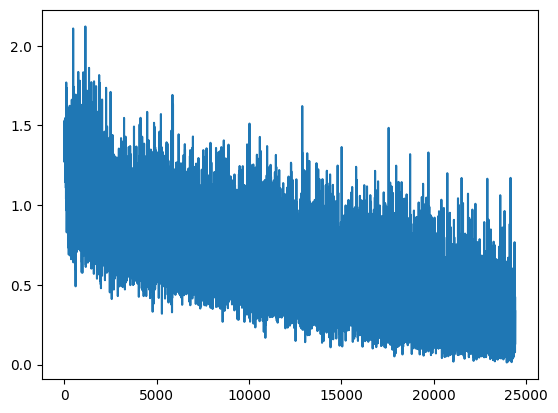

In [39]:
plt.plot(train_losses)

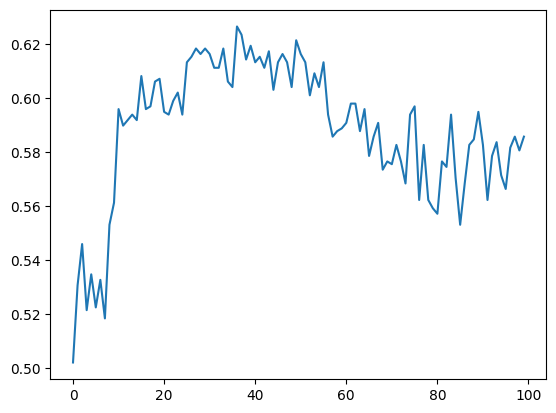

In [40]:
plt.plot(test_accuracy)

In [41]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13mfcc_best_37epoch.pt
Correct: 614/976 (0.6291)
{'acc_detail': tensor([0.7126, 0.5370, 0.7480, 0.5040], device='cuda:0'),
 'acc_unweighted': tensor(0.6254, device='cuda:0'),
 'acc_weighted': tensor(0.6291, device='cuda:0'),
 'f1s_detail': tensor([0.7183, 0.5309, 0.7280, 0.5194], device='cuda:0'),
 'f1s_unweighted': tensor(0.6241, device='cuda:0'),
 'f1s_weighted': tensor(0.6280, device='cuda:0'),
 'precision_detail': tensor([0.7240, 0.5249, 0.7090, 0.5359], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.5370, 0.7480, 0.5040], device='cuda:0'),
 'rocauc': tensor(0.8527, device='cuda:0'),
 'rocauc_detail': tensor([0.9103, 0.8154, 0.9152, 0.7700], device='cuda:0'),
 'uar': tensor(0.6254, device='cuda:0'),
 'wap': tensor(0.6274, device='cuda:0')}


tensor([[181,  12,   7,  54],
        [ 15, 116,  45,  40],
        [  4,  44, 190,  16],
        [ 50,  49,  26, 127]], device='cuda:0')

In [42]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [43]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                  | 0.006557377049180328/50 [00:00<53:25, 64.12s/it]

Train Epoch: 101 [0/3918 (0%)]	Loss: 0.365820
Mem before-during-after: 18004480 17993216 18544640


  0%|                                   | 0.13442622950819672/50 [00:08<52:12, 62.82s/it]

Train Epoch: 101 [640/3918 (16%)]	Loss: 0.149683
Mem before-during-after: 18544640 18618880 18544640


  1%|▏                                  | 0.26557377049180286/50 [00:16<53:00, 63.96s/it]

Train Epoch: 101 [1280/3918 (33%)]	Loss: 0.420307
Mem before-during-after: 18544640 18618880 18544640


  1%|▎                                     | 0.39672131147541/50 [00:25<52:12, 63.15s/it]

Train Epoch: 101 [1920/3918 (49%)]	Loss: 0.184866
Mem before-during-after: 18544640 18618880 18544640


  1%|▍                                   | 0.5278688524590167/50 [00:33<51:24, 62.34s/it]

Train Epoch: 101 [2560/3918 (66%)]	Loss: 0.258878
Mem before-during-after: 18544640 18618880 18544640


  1%|▍                                   | 0.6622950819672118/50 [00:41<52:36, 63.98s/it]

Train Epoch: 101 [3200/3918 (82%)]	Loss: 0.107061
Mem before-during-after: 18544640 18618880 18544640


  2%|▌                                   | 0.7901639344262266/50 [00:49<52:10, 63.62s/it]

Train Epoch: 101 [3840/3918 (98%)]	Loss: 0.045956
Mem before-during-after: 18544640 18618880 18544640


  2%|▋                                   | 0.9999999999999944/50 [01:03<50:41, 62.08s/it]


Test Epoch: 101	Accuracy: 579/976 (59%)



  2%|▋                                   | 1.0032786885245846/50 [01:03<51:15, 62.77s/it]

Train Epoch: 102 [0/3918 (0%)]	Loss: 0.108144
Mem before-during-after: 18543616 18618880 18544640


  2%|▊                                   | 1.1344262295081895/50 [01:11<51:05, 62.73s/it]

Train Epoch: 102 [640/3918 (16%)]	Loss: 0.092770
Mem before-during-after: 18544640 18618880 18544640


  3%|▉                                   | 1.2655737704917944/50 [01:19<50:37, 62.32s/it]

Train Epoch: 102 [1280/3918 (33%)]	Loss: 0.185743
Mem before-during-after: 18544640 18618880 18544640


  3%|█                                   | 1.3967213114753994/50 [01:28<49:54, 61.61s/it]

Train Epoch: 102 [1920/3918 (49%)]	Loss: 0.020073
Mem before-during-after: 18544640 18618880 18544640


  3%|█                                   | 1.5278688524590043/50 [01:36<50:31, 62.53s/it]

Train Epoch: 102 [2560/3918 (66%)]	Loss: 0.342602
Mem before-during-after: 18544640 18618880 18544640


  3%|█▏                                  | 1.6590163934426092/50 [01:44<52:36, 65.29s/it]

Train Epoch: 102 [3200/3918 (82%)]	Loss: 0.150809
Mem before-during-after: 18544640 18618880 18544640


  4%|█▎                                  | 1.7901639344262141/50 [01:53<51:23, 63.96s/it]

Train Epoch: 102 [3840/3918 (98%)]	Loss: 0.169281
Mem before-during-after: 18544640 18618880 18544640


  4%|█▍                                   | 1.999999999999982/50 [02:06<47:52, 59.85s/it]


Test Epoch: 102	Accuracy: 582/976 (59%)



  4%|█▍                                  | 2.0032786885245724/50 [02:06<50:49, 63.54s/it]

Train Epoch: 103 [0/3918 (0%)]	Loss: 0.134070
Mem before-during-after: 18543616 18618880 18544640


  4%|█▌                                  | 2.1344262295081773/50 [02:14<49:26, 61.97s/it]

Train Epoch: 103 [640/3918 (16%)]	Loss: 0.155304
Mem before-during-after: 18544640 18618880 18544640


  5%|█▋                                  | 2.2688524590163723/50 [02:23<49:31, 62.26s/it]

Train Epoch: 103 [1280/3918 (33%)]	Loss: 0.128058
Mem before-during-after: 18544640 18618880 18544640


  5%|█▊                                   | 2.396721311475387/50 [02:31<49:29, 62.37s/it]

Train Epoch: 103 [1920/3918 (49%)]	Loss: 0.061030
Mem before-during-after: 18544640 18618880 18544640


  5%|█▊                                   | 2.531147540983582/50 [02:39<48:01, 60.70s/it]

Train Epoch: 103 [2560/3918 (66%)]	Loss: 0.136313
Mem before-during-after: 18544640 18618880 18544640


  5%|█▉                                   | 2.659016393442597/50 [02:47<48:23, 61.32s/it]

Train Epoch: 103 [3200/3918 (82%)]	Loss: 0.106626
Mem before-during-after: 18544640 18618880 18544640


  6%|██                                   | 2.793442622950792/50 [02:56<48:47, 62.02s/it]

Train Epoch: 103 [3840/3918 (98%)]	Loss: 0.040850
Mem before-during-after: 18544640 18618880 18544640


  6%|██▎                                   | 3.00327868852456/50 [03:09<47:30, 60.66s/it]


Test Epoch: 103	Accuracy: 583/976 (59%)

Train Epoch: 104 [0/3918 (0%)]	Loss: 0.157404
Mem before-during-after: 18543616 18618880 18544640


  6%|██▎                                  | 3.137704918032755/50 [03:17<48:50, 62.54s/it]

Train Epoch: 104 [640/3918 (16%)]	Loss: 0.108998
Mem before-during-after: 18544640 18618880 18544640


  7%|██▍                                   | 3.26557377049177/50 [03:25<48:22, 62.11s/it]

Train Epoch: 104 [1280/3918 (33%)]	Loss: 0.046959
Mem before-during-after: 18544640 18618880 18544640


  7%|██▌                                  | 3.399999999999965/50 [03:34<47:42, 61.42s/it]

Train Epoch: 104 [1920/3918 (49%)]	Loss: 0.111494
Mem before-during-after: 18544640 18618880 18544640


  7%|██▌                                 | 3.5311475409835698/50 [03:42<47:15, 61.02s/it]

Train Epoch: 104 [2560/3918 (66%)]	Loss: 0.059236
Mem before-during-after: 18544640 18618880 18544640


  7%|██▋                                 | 3.6590163934425846/50 [03:50<47:46, 61.86s/it]

Train Epoch: 104 [3200/3918 (82%)]	Loss: 0.029505
Mem before-during-after: 18544640 18618880 18544640


  8%|██▋                                 | 3.7934426229507796/50 [03:58<47:51, 62.15s/it]

Train Epoch: 104 [3840/3918 (98%)]	Loss: 0.130167
Mem before-during-after: 18544640 18618880 18544640


  8%|██▉                                 | 4.0032786885245475/50 [04:11<46:54, 61.19s/it]


Test Epoch: 104	Accuracy: 574/976 (59%)

Train Epoch: 105 [0/3918 (0%)]	Loss: 0.292360
Mem before-during-after: 18543616 18618880 18544640


  8%|███                                  | 4.134426229508152/50 [04:19<46:02, 60.23s/it]

Train Epoch: 105 [640/3918 (16%)]	Loss: 0.045229
Mem before-during-after: 18544640 18618880 18544640


  9%|███                                 | 4.2688524590163475/50 [04:28<47:09, 61.87s/it]

Train Epoch: 105 [1280/3918 (33%)]	Loss: 0.032510
Mem before-during-after: 18544640 18618880 18544640


  9%|███▎                                 | 4.399999999999952/50 [04:36<46:56, 61.76s/it]

Train Epoch: 105 [1920/3918 (49%)]	Loss: 0.044656
Mem before-during-after: 18544640 18618880 18544640


  9%|███▎                                 | 4.527868852458967/50 [04:44<45:26, 59.96s/it]

Train Epoch: 105 [2560/3918 (66%)]	Loss: 0.169063
Mem before-during-after: 18544640 18618880 18544640


  9%|███▍                                 | 4.659016393442572/50 [04:52<46:12, 61.15s/it]

Train Epoch: 105 [3200/3918 (82%)]	Loss: 0.030912
Mem before-during-after: 18544640 18618880 18544640


 10%|███▌                                 | 4.790163934426177/50 [05:00<47:01, 62.41s/it]

Train Epoch: 105 [3840/3918 (98%)]	Loss: 0.084721
Mem before-during-after: 18544640 18618880 18544640


 10%|███▋                                 | 5.003278688524535/50 [05:13<46:10, 61.57s/it]


Test Epoch: 105	Accuracy: 571/976 (58%)

Train Epoch: 106 [0/3918 (0%)]	Loss: 0.122424
Mem before-during-after: 18543616 18618880 18544640


 10%|███▉                                  | 5.13442622950814/50 [05:21<45:16, 60.56s/it]

Train Epoch: 106 [640/3918 (16%)]	Loss: 0.060976
Mem before-during-after: 18544640 18618880 18544640


 11%|███▉                                 | 5.265573770491745/50 [05:29<48:21, 64.85s/it]

Train Epoch: 106 [1280/3918 (33%)]	Loss: 0.046216
Mem before-during-after: 18544640 18618880 18544640


 11%|████                                  | 5.39999999999994/50 [05:38<45:38, 61.40s/it]

Train Epoch: 106 [1920/3918 (49%)]	Loss: 0.042114
Mem before-during-after: 18544640 18618880 18544640


 11%|████                                 | 5.527868852458955/50 [05:46<45:51, 61.88s/it]

Train Epoch: 106 [2560/3918 (66%)]	Loss: 0.040432
Mem before-during-after: 18544640 18618880 18544640


 11%|████▎                                 | 5.65901639344256/50 [05:54<44:52, 60.72s/it]

Train Epoch: 106 [3200/3918 (82%)]	Loss: 0.174810
Mem before-during-after: 18544640 18618880 18544640


 12%|████▎                                | 5.790163934426165/50 [06:02<44:38, 60.58s/it]

Train Epoch: 106 [3840/3918 (98%)]	Loss: 0.022748
Mem before-during-after: 18544640 18618880 18544640


 12%|████▎                               | 5.9999999999999325/50 [06:15<44:11, 60.26s/it]


Test Epoch: 106	Accuracy: 578/976 (59%)



 12%|████▍                                | 6.003278688524523/50 [06:15<44:41, 60.95s/it]

Train Epoch: 107 [0/3918 (0%)]	Loss: 0.098190
Mem before-during-after: 18543616 18618880 18544640


 12%|████▍                               | 6.1344262295081275/50 [06:23<44:46, 61.24s/it]

Train Epoch: 107 [640/3918 (16%)]	Loss: 0.203820
Mem before-during-after: 18544640 18618880 18544640


 13%|████▋                                | 6.268852459016323/50 [06:32<47:06, 64.64s/it]

Train Epoch: 107 [1280/3918 (33%)]	Loss: 0.052974
Mem before-during-after: 18544640 18618880 18544640


 13%|████▋                                | 6.396721311475337/50 [06:40<44:58, 61.89s/it]

Train Epoch: 107 [1920/3918 (49%)]	Loss: 0.161534
Mem before-during-after: 18544640 18618880 18544640


 13%|████▊                                | 6.527868852458942/50 [06:48<44:00, 60.75s/it]

Train Epoch: 107 [2560/3918 (66%)]	Loss: 0.095145
Mem before-during-after: 18544640 18618880 18544640


 13%|████▉                                | 6.659016393442547/50 [06:56<44:02, 60.98s/it]

Train Epoch: 107 [3200/3918 (82%)]	Loss: 0.055170
Mem before-during-after: 18544640 18618880 18544640


 14%|█████                                | 6.793442622950742/50 [07:05<44:15, 61.46s/it]

Train Epoch: 107 [3840/3918 (98%)]	Loss: 0.101385
Mem before-during-after: 18544640 18618880 18544640


 14%|█████▎                                | 6.99999999999992/50 [07:17<44:31, 62.13s/it]


Test Epoch: 107	Accuracy: 582/976 (59%)



 14%|█████▎                                | 7.00327868852451/50 [07:17<45:43, 63.81s/it]

Train Epoch: 108 [0/3918 (0%)]	Loss: 0.272772
Mem before-during-after: 18543616 18618880 18544640


 14%|█████▎                               | 7.134426229508115/50 [07:26<43:42, 61.19s/it]

Train Epoch: 108 [640/3918 (16%)]	Loss: 0.082683
Mem before-during-after: 18544640 18618880 18544640


 15%|█████▌                                | 7.26557377049172/50 [07:34<43:46, 61.45s/it]

Train Epoch: 108 [1280/3918 (33%)]	Loss: 0.049938
Mem before-during-after: 18544640 18618880 18544640


 15%|█████▍                               | 7.396721311475325/50 [07:42<43:34, 61.37s/it]

Train Epoch: 108 [1920/3918 (49%)]	Loss: 0.265443
Mem before-during-after: 18544640 18618880 18544640


 15%|█████▋                                | 7.52786885245893/50 [07:50<43:31, 61.50s/it]

Train Epoch: 108 [2560/3918 (66%)]	Loss: 0.065129
Mem before-during-after: 18544640 18618880 18544640


 15%|█████▋                               | 7.659016393442535/50 [07:59<44:20, 62.84s/it]

Train Epoch: 108 [3200/3918 (82%)]	Loss: 0.335891
Mem before-during-after: 18544640 18618880 18544640


 16%|█████▉                                | 7.79016393442614/50 [08:07<43:37, 62.01s/it]

Train Epoch: 108 [3840/3918 (98%)]	Loss: 0.314572
Mem before-during-after: 18544640 18618880 18544640


 16%|█████▉                               | 7.999999999999908/50 [08:20<42:23, 60.56s/it]


Test Epoch: 108	Accuracy: 570/976 (58%)



 16%|█████▉                               | 8.006557377049088/50 [08:20<42:37, 60.91s/it]

Train Epoch: 109 [0/3918 (0%)]	Loss: 0.030490
Mem before-during-after: 18543616 18618880 18544640


 16%|██████                               | 8.137704918032693/50 [08:28<42:58, 61.59s/it]

Train Epoch: 109 [640/3918 (16%)]	Loss: 0.127081
Mem before-during-after: 18544640 18618880 18544640


 17%|██████                               | 8.268852459016298/50 [08:36<42:34, 61.22s/it]

Train Epoch: 109 [1280/3918 (33%)]	Loss: 0.053057
Mem before-during-after: 18544640 18618880 18544640


 17%|██████▏                              | 8.396721311475313/50 [08:44<41:37, 60.04s/it]

Train Epoch: 109 [1920/3918 (49%)]	Loss: 0.161083
Mem before-during-after: 18544640 18618880 18544640


 17%|██████▎                              | 8.527868852458917/50 [08:52<43:51, 63.46s/it]

Train Epoch: 109 [2560/3918 (66%)]	Loss: 0.064658
Mem before-during-after: 18544640 18618880 18544640


 17%|██████▍                              | 8.662295081967113/50 [09:01<41:30, 60.24s/it]

Train Epoch: 109 [3200/3918 (82%)]	Loss: 0.061606
Mem before-during-after: 18544640 18618880 18544640


 18%|██████▌                              | 8.790163934426127/50 [09:09<42:17, 61.59s/it]

Train Epoch: 109 [3840/3918 (98%)]	Loss: 0.123914
Mem before-during-after: 18544640 18618880 18544640


 18%|██████▋                              | 8.999999999999895/50 [09:22<42:11, 61.74s/it]


Test Epoch: 109	Accuracy: 578/976 (59%)



 18%|██████▋                              | 9.003278688524485/50 [09:22<42:22, 62.01s/it]

Train Epoch: 110 [0/3918 (0%)]	Loss: 0.127966
Mem before-during-after: 18543616 18618880 18544640


 18%|██████▉                               | 9.13442622950809/50 [09:30<42:15, 62.05s/it]

Train Epoch: 110 [640/3918 (16%)]	Loss: 0.087534
Mem before-during-after: 18544640 18618880 18544640


 19%|██████▊                              | 9.268852459016285/50 [09:38<40:51, 60.18s/it]

Train Epoch: 110 [1280/3918 (33%)]	Loss: 0.089836
Mem before-during-after: 18544640 18618880 18544640


 19%|███████▏                              | 9.39999999999989/50 [09:47<41:16, 60.99s/it]

Train Epoch: 110 [1920/3918 (49%)]	Loss: 0.101842
Mem before-during-after: 18544640 18618880 18544640


 19%|███████                              | 9.527868852458905/50 [09:55<41:57, 62.20s/it]

Train Epoch: 110 [2560/3918 (66%)]	Loss: 0.071862
Mem before-during-after: 18544640 18618880 18544640


 19%|███████▌                               | 9.6622950819671/50 [10:03<40:49, 60.73s/it]

Train Epoch: 110 [3200/3918 (82%)]	Loss: 0.085359
Mem before-during-after: 18544640 18618880 18544640


 20%|███████▏                             | 9.793442622950705/50 [10:11<40:46, 60.84s/it]

Train Epoch: 110 [3840/3918 (98%)]	Loss: 0.111558
Mem before-during-after: 18544640 18618880 18544640


 20%|███████▏                            | 10.003278688524473/50 [10:24<41:30, 62.27s/it]


Test Epoch: 110	Accuracy: 566/976 (58%)

Train Epoch: 111 [0/3918 (0%)]	Loss: 0.038669
Mem before-during-after: 18543616 18618880 18544640


 20%|███████▎                            | 10.137704918032668/50 [10:33<40:58, 61.67s/it]

Train Epoch: 111 [640/3918 (16%)]	Loss: 0.191286
Mem before-during-after: 18544640 18618880 18544640


 21%|███████▍                            | 10.268852459016273/50 [10:41<40:31, 61.21s/it]

Train Epoch: 111 [1280/3918 (33%)]	Loss: 0.032060
Mem before-during-after: 18544640 18618880 18544640


 21%|███████▍                            | 10.396721311475288/50 [10:49<40:57, 62.05s/it]

Train Epoch: 111 [1920/3918 (49%)]	Loss: 0.091495
Mem before-during-after: 18544640 18618880 18544640


 21%|███████▌                            | 10.531147540983483/50 [10:57<40:30, 61.58s/it]

Train Epoch: 111 [2560/3918 (66%)]	Loss: 0.194026
Mem before-during-after: 18544640 18618880 18544640


 21%|███████▋                            | 10.662295081967088/50 [11:05<40:03, 61.09s/it]

Train Epoch: 111 [3200/3918 (82%)]	Loss: 0.056897
Mem before-during-after: 18544640 18618880 18544640


 22%|███████▊                            | 10.793442622950693/50 [11:14<40:29, 61.97s/it]

Train Epoch: 111 [3840/3918 (98%)]	Loss: 0.053098
Mem before-during-after: 18544640 18618880 18544640


 22%|████████▏                            | 10.99999999999987/50 [11:26<39:34, 60.90s/it]


Test Epoch: 111	Accuracy: 581/976 (59%)



 22%|████████▏                            | 11.00655737704905/50 [11:27<39:46, 61.21s/it]

Train Epoch: 112 [0/3918 (0%)]	Loss: 0.035076
Mem before-during-after: 18543616 18618880 18544640


 22%|████████                            | 11.137704918032655/50 [11:35<39:23, 60.81s/it]

Train Epoch: 112 [640/3918 (16%)]	Loss: 0.327860
Mem before-during-after: 18544640 18618880 18544640


 23%|████████▎                            | 11.26557377049167/50 [11:43<39:39, 61.43s/it]

Train Epoch: 112 [1280/3918 (33%)]	Loss: 0.020917
Mem before-during-after: 18544640 18618880 18544640


 23%|████████▏                           | 11.396721311475275/50 [11:51<43:41, 67.91s/it]

Train Epoch: 112 [1920/3918 (49%)]	Loss: 0.038297
Mem before-during-after: 18544640 18618880 18544640


 23%|████████▌                            | 11.52786885245888/50 [11:59<38:54, 60.68s/it]

Train Epoch: 112 [2560/3918 (66%)]	Loss: 0.035275
Mem before-during-after: 18544640 18618880 18544640


 23%|████████▍                           | 11.662295081967075/50 [12:08<39:23, 61.64s/it]

Train Epoch: 112 [3200/3918 (82%)]	Loss: 0.061506
Mem before-during-after: 18544640 18618880 18544640


 24%|████████▋                            | 11.79016393442609/50 [12:16<39:08, 61.46s/it]

Train Epoch: 112 [3840/3918 (98%)]	Loss: 0.203670
Mem before-during-after: 18544640 18618880 18544640


 24%|████████▋                           | 11.999999999999858/50 [12:29<39:12, 61.91s/it]


Test Epoch: 112	Accuracy: 560/976 (57%)



 24%|████████▋                           | 12.003278688524448/50 [12:29<39:08, 61.81s/it]

Train Epoch: 113 [0/3918 (0%)]	Loss: 0.353160
Mem before-during-after: 18543616 18618880 18544640


 24%|████████▋                           | 12.137704918032643/50 [12:37<39:37, 62.80s/it]

Train Epoch: 113 [640/3918 (16%)]	Loss: 0.033734
Mem before-during-after: 18544640 18618880 18544640


 25%|████████▊                           | 12.268852459016248/50 [12:45<38:20, 60.98s/it]

Train Epoch: 113 [1280/3918 (33%)]	Loss: 0.037373
Mem before-during-after: 18544640 18618880 18544640


 25%|████████▉                           | 12.396721311475263/50 [12:53<38:31, 61.46s/it]

Train Epoch: 113 [1920/3918 (49%)]	Loss: 0.150801
Mem before-during-after: 18544640 18618880 18544640


 25%|█████████                           | 12.531147540983458/50 [13:02<38:11, 61.16s/it]

Train Epoch: 113 [2560/3918 (66%)]	Loss: 0.044641
Mem before-during-after: 18544640 18618880 18544640


 25%|█████████                           | 12.659016393442473/50 [13:10<37:50, 60.82s/it]

Train Epoch: 113 [3200/3918 (82%)]	Loss: 0.209741
Mem before-during-after: 18544640 18618880 18544640


 26%|█████████▏                          | 12.793442622950668/50 [13:18<39:00, 62.90s/it]

Train Epoch: 113 [3840/3918 (98%)]	Loss: 0.222991
Mem before-during-after: 18544640 18618880 18544640


 26%|█████████▎                          | 12.999999999999845/50 [13:31<37:40, 61.08s/it]


Test Epoch: 113	Accuracy: 580/976 (59%)



 26%|█████████▎                          | 13.003278688524436/50 [13:31<37:52, 61.42s/it]

Train Epoch: 114 [0/3918 (0%)]	Loss: 0.068858
Mem before-during-after: 18543616 18618880 18544640


 26%|█████████▋                           | 13.13442622950804/50 [13:39<37:41, 61.34s/it]

Train Epoch: 114 [640/3918 (16%)]	Loss: 0.062108
Mem before-during-after: 18544640 18618880 18544640


 27%|█████████▌                          | 13.265573770491645/50 [13:47<37:30, 61.28s/it]

Train Epoch: 114 [1280/3918 (33%)]	Loss: 0.100111
Mem before-during-after: 18544640 18618880 18544640


 27%|█████████▉                           | 13.39999999999984/50 [13:55<37:16, 61.10s/it]

Train Epoch: 114 [1920/3918 (49%)]	Loss: 0.023986
Mem before-during-after: 18544640 18618880 18544640


 27%|█████████▋                          | 13.531147540983445/50 [14:04<37:24, 61.54s/it]

Train Epoch: 114 [2560/3918 (66%)]	Loss: 0.023410
Mem before-during-after: 18544640 18618880 18544640


 27%|██████████                           | 13.65901639344246/50 [14:12<36:56, 61.00s/it]

Train Epoch: 114 [3200/3918 (82%)]	Loss: 0.123896
Mem before-during-after: 18544640 18618880 18544640


 28%|█████████▉                          | 13.790163934426065/50 [14:20<37:48, 62.65s/it]

Train Epoch: 114 [3840/3918 (98%)]	Loss: 0.034891
Mem before-during-after: 18544640 18618880 18544640


 28%|██████████                          | 13.999999999999833/50 [14:33<37:25, 62.37s/it]


Test Epoch: 114	Accuracy: 571/976 (58%)



 28%|██████████                          | 14.006557377049013/50 [14:33<37:11, 62.01s/it]

Train Epoch: 115 [0/3918 (0%)]	Loss: 0.114826
Mem before-during-after: 18543616 18618880 18544640


 28%|██████████▏                         | 14.137704918032618/50 [14:41<37:10, 62.19s/it]

Train Epoch: 115 [640/3918 (16%)]	Loss: 0.067626
Mem before-during-after: 18544640 18618880 18544640


 29%|██████████▎                         | 14.265573770491633/50 [14:50<36:38, 61.53s/it]

Train Epoch: 115 [1280/3918 (33%)]	Loss: 0.091041
Mem before-during-after: 18544640 18618880 18544640


 29%|██████████▎                         | 14.396721311475238/50 [14:58<37:08, 62.59s/it]

Train Epoch: 115 [1920/3918 (49%)]	Loss: 0.022027
Mem before-during-after: 18544640 18618880 18544640


 29%|██████████▍                         | 14.527868852458843/50 [15:06<36:30, 61.75s/it]

Train Epoch: 115 [2560/3918 (66%)]	Loss: 0.058237
Mem before-during-after: 18544640 18618880 18544640


 29%|██████████▌                         | 14.662295081967038/50 [15:14<35:52, 60.92s/it]

Train Epoch: 115 [3200/3918 (82%)]	Loss: 0.048430
Mem before-during-after: 18544640 18618880 18544640


 30%|██████████▋                         | 14.793442622950643/50 [15:23<35:40, 60.78s/it]

Train Epoch: 115 [3840/3918 (98%)]	Loss: 0.169249
Mem before-during-after: 18544640 18618880 18544640


 30%|███████████                          | 14.99999999999982/50 [15:35<35:27, 60.80s/it]


Test Epoch: 115	Accuracy: 574/976 (59%)



 30%|███████████                          | 15.00327868852441/50 [15:36<35:38, 61.10s/it]

Train Epoch: 116 [0/3918 (0%)]	Loss: 0.049732
Mem before-during-after: 18543616 18618880 18544640


 30%|██████████▉                         | 15.137704918032606/50 [15:44<35:20, 60.81s/it]

Train Epoch: 116 [640/3918 (16%)]	Loss: 0.052602
Mem before-during-after: 18544640 18618880 18544640


 31%|███████████▎                         | 15.26885245901621/50 [15:52<36:55, 63.79s/it]

Train Epoch: 116 [1280/3918 (33%)]	Loss: 0.020186
Mem before-during-after: 18544640 18618880 18544640


 31%|███████████                         | 15.396721311475225/50 [16:00<35:33, 61.66s/it]

Train Epoch: 116 [1920/3918 (49%)]	Loss: 0.068045
Mem before-during-after: 18544640 18618880 18544640


 31%|███████████▍                         | 15.52786885245883/50 [16:08<35:38, 62.03s/it]

Train Epoch: 116 [2560/3918 (66%)]	Loss: 0.021470
Mem before-during-after: 18544640 18618880 18544640


 31%|███████████▎                        | 15.659016393442435/50 [16:16<35:12, 61.51s/it]

Train Epoch: 116 [3200/3918 (82%)]	Loss: 0.038403
Mem before-during-after: 18544640 18618880 18544640


 32%|███████████▋                         | 15.79016393442604/50 [16:24<34:58, 61.34s/it]

Train Epoch: 116 [3840/3918 (98%)]	Loss: 0.321451
Mem before-during-after: 18544640 18618880 18544640


 32%|████████████▏                         | 16.0032786885244/50 [16:38<36:18, 64.07s/it]


Test Epoch: 116	Accuracy: 563/976 (57%)

Train Epoch: 117 [0/3918 (0%)]	Loss: 0.089555
Mem before-during-after: 18543616 18618880 18544640


 32%|███████████▌                        | 16.134426229508076/50 [16:46<35:01, 62.05s/it]

Train Epoch: 117 [640/3918 (16%)]	Loss: 0.070700
Mem before-during-after: 18544640 18618880 18544640


 33%|███████████▋                        | 16.268852459016344/50 [16:54<34:13, 60.86s/it]

Train Epoch: 117 [1280/3918 (33%)]	Loss: 0.243285
Mem before-during-after: 18544640 18618880 18544640


 33%|███████████▊                        | 16.396721311475428/50 [17:02<34:23, 61.41s/it]

Train Epoch: 117 [1920/3918 (49%)]	Loss: 0.055674
Mem before-during-after: 18544640 18618880 18544640


 33%|███████████▉                        | 16.527868852459104/50 [17:10<34:18, 61.49s/it]

Train Epoch: 117 [2560/3918 (66%)]	Loss: 0.015468
Mem before-during-after: 18544640 18618880 18544640


 33%|████████████▎                        | 16.65901639344278/50 [17:19<34:56, 62.88s/it]

Train Epoch: 117 [3200/3918 (82%)]	Loss: 0.244471
Mem before-during-after: 18544640 18618880 18544640


 34%|████████████                        | 16.790163934426456/50 [17:27<34:09, 61.70s/it]

Train Epoch: 117 [3840/3918 (98%)]	Loss: 0.098314
Mem before-during-after: 18544640 18618880 18544640


 34%|████████████▌                        | 17.00327868852493/50 [17:40<33:33, 61.03s/it]


Test Epoch: 117	Accuracy: 570/976 (58%)

Train Epoch: 118 [0/3918 (0%)]	Loss: 0.025479
Mem before-during-after: 18543616 18618880 18544640


 34%|████████████▎                       | 17.134426229508605/50 [17:48<33:10, 60.57s/it]

Train Epoch: 118 [640/3918 (16%)]	Loss: 0.289396
Mem before-during-after: 18544640 18618880 18544640


 35%|████████████▍                       | 17.268852459016873/50 [17:56<33:23, 61.20s/it]

Train Epoch: 118 [1280/3918 (33%)]	Loss: 0.022500
Mem before-during-after: 18544640 18618880 18544640


 35%|████████████▌                       | 17.396721311475957/50 [18:04<33:23, 61.45s/it]

Train Epoch: 118 [1920/3918 (49%)]	Loss: 0.045136
Mem before-during-after: 18544640 18618880 18544640


 35%|████████████▌                       | 17.531147540984225/50 [18:13<32:57, 60.89s/it]

Train Epoch: 118 [2560/3918 (66%)]	Loss: 0.067710
Mem before-during-after: 18544640 18618880 18544640


 35%|█████████████                        | 17.65901639344331/50 [18:21<33:21, 61.87s/it]

Train Epoch: 118 [3200/3918 (82%)]	Loss: 0.026108
Mem before-during-after: 18544640 18618880 18544640


 36%|████████████▊                       | 17.790163934426985/50 [18:29<33:18, 62.04s/it]

Train Epoch: 118 [3840/3918 (98%)]	Loss: 0.064897
Mem before-during-after: 18544640 18618880 18544640


 36%|█████████████▎                       | 18.00327868852546/50 [18:42<32:05, 60.19s/it]


Test Epoch: 118	Accuracy: 564/976 (58%)

Train Epoch: 119 [0/3918 (0%)]	Loss: 0.009127
Mem before-during-after: 18543616 18618880 18544640


 36%|█████████████                       | 18.137704918033727/50 [18:50<33:12, 62.54s/it]

Train Epoch: 119 [640/3918 (16%)]	Loss: 0.041318
Mem before-during-after: 18544640 18618880 18544640


 37%|█████████████▏                      | 18.268852459017403/50 [18:58<31:53, 60.29s/it]

Train Epoch: 119 [1280/3918 (33%)]	Loss: 0.030788
Mem before-during-after: 18544640 18618880 18544640


 37%|█████████████▏                      | 18.396721311476487/50 [19:06<32:45, 62.18s/it]

Train Epoch: 119 [1920/3918 (49%)]	Loss: 0.046512
Mem before-during-after: 18544640 18618880 18544640


 37%|█████████████▎                      | 18.531147540984755/50 [19:15<32:21, 61.70s/it]

Train Epoch: 119 [2560/3918 (66%)]	Loss: 0.015766
Mem before-during-after: 18544640 18618880 18544640


 37%|█████████████▊                       | 18.66229508196843/50 [19:23<33:04, 63.33s/it]

Train Epoch: 119 [3200/3918 (82%)]	Loss: 0.118282
Mem before-during-after: 18544640 18618880 18544640


 38%|█████████████▌                      | 18.790163934427515/50 [19:31<32:05, 61.70s/it]

Train Epoch: 119 [3840/3918 (98%)]	Loss: 0.049398
Mem before-during-after: 18544640 18618880 18544640


 38%|█████████████▋                      | 19.000000000001396/50 [19:44<31:10, 60.33s/it]


Test Epoch: 119	Accuracy: 567/976 (58%)



 38%|█████████████▋                      | 19.003278688525988/50 [19:44<31:47, 61.52s/it]

Train Epoch: 120 [0/3918 (0%)]	Loss: 0.008480
Mem before-during-after: 18543616 18618880 18544640


 38%|█████████████▊                      | 19.134426229509664/50 [19:52<30:45, 59.79s/it]

Train Epoch: 120 [640/3918 (16%)]	Loss: 0.180283
Mem before-during-after: 18544640 18618880 18544640


 39%|█████████████▊                      | 19.268852459017932/50 [20:01<31:29, 61.48s/it]

Train Epoch: 120 [1280/3918 (33%)]	Loss: 0.079480
Mem before-during-after: 18544640 18618880 18544640


 39%|█████████████▉                      | 19.396721311477016/50 [20:09<32:02, 62.82s/it]

Train Epoch: 120 [1920/3918 (49%)]	Loss: 0.029386
Mem before-during-after: 18544640 18618880 18544640


 39%|██████████████                      | 19.527868852460692/50 [20:17<31:00, 61.06s/it]

Train Epoch: 120 [2560/3918 (66%)]	Loss: 0.028438
Mem before-during-after: 18544640 18618880 18544640


 39%|██████████████▏                     | 19.659016393444368/50 [20:25<31:29, 62.29s/it]

Train Epoch: 120 [3200/3918 (82%)]	Loss: 0.147037
Mem before-during-after: 18544640 18618880 18544640


 40%|██████████████▎                     | 19.793442622952636/50 [20:33<31:32, 62.64s/it]

Train Epoch: 120 [3840/3918 (98%)]	Loss: 0.052779
Mem before-during-after: 18544640 18618880 18544640


 40%|██████████████▍                     | 20.003278688526517/50 [20:46<30:27, 60.92s/it]


Test Epoch: 120	Accuracy: 577/976 (59%)

Train Epoch: 121 [0/3918 (0%)]	Loss: 0.032878
Mem before-during-after: 18543616 18618880 18544640


 40%|██████████████▍                     | 20.134426229510193/50 [20:55<30:34, 61.41s/it]

Train Epoch: 121 [640/3918 (16%)]	Loss: 0.019934
Mem before-during-after: 18544640 18618880 18544640


 41%|██████████████▉                      | 20.26885245901846/50 [21:03<38:03, 76.82s/it]

Train Epoch: 121 [1280/3918 (33%)]	Loss: 0.050747
Mem before-during-after: 18544640 18618880 18544640


 41%|██████████████▋                     | 20.396721311477545/50 [21:11<30:49, 62.46s/it]

Train Epoch: 121 [1920/3918 (49%)]	Loss: 0.024624
Mem before-during-after: 18544640 18618880 18544640


 41%|███████████████▏                     | 20.52786885246122/50 [21:19<30:33, 62.21s/it]

Train Epoch: 121 [2560/3918 (66%)]	Loss: 0.015688
Mem before-during-after: 18544640 18618880 18544640


 41%|██████████████▊                     | 20.659016393444897/50 [21:27<30:34, 62.53s/it]

Train Epoch: 121 [3200/3918 (82%)]	Loss: 0.162621
Mem before-during-after: 18544640 18618880 18544640


 42%|██████████████▉                     | 20.790163934428573/50 [21:36<30:00, 61.63s/it]

Train Epoch: 121 [3840/3918 (98%)]	Loss: 0.010830
Mem before-during-after: 18544640 18618880 18544640


 42%|███████████████                     | 21.000000000002455/50 [21:49<29:23, 60.80s/it]


Test Epoch: 121	Accuracy: 578/976 (59%)



 42%|███████████████▌                     | 21.00655737705164/50 [21:49<29:48, 61.68s/it]

Train Epoch: 122 [0/3918 (0%)]	Loss: 0.099314
Mem before-during-after: 18543616 18618880 18544640


 42%|███████████████▏                    | 21.137704918035315/50 [21:57<29:35, 61.50s/it]

Train Epoch: 122 [640/3918 (16%)]	Loss: 0.018421
Mem before-during-after: 18544640 18618880 18544640


 43%|████████████████▏                     | 21.2655737704944/50 [22:05<29:38, 61.91s/it]

Train Epoch: 122 [1280/3918 (33%)]	Loss: 0.066216
Mem before-during-after: 18544640 18618880 18544640


 43%|███████████████▍                    | 21.396721311478075/50 [22:13<29:20, 61.55s/it]

Train Epoch: 122 [1920/3918 (49%)]	Loss: 0.035188
Mem before-during-after: 18544640 18618880 18544640


 43%|███████████████▌                    | 21.531147540986343/50 [22:22<29:15, 61.66s/it]

Train Epoch: 122 [2560/3918 (66%)]	Loss: 0.019910
Mem before-during-after: 18544640 18618880 18544640


 43%|███████████████▌                    | 21.659016393445427/50 [22:30<31:58, 67.69s/it]

Train Epoch: 122 [3200/3918 (82%)]	Loss: 0.172297
Mem before-during-after: 18544640 18618880 18544640


 44%|███████████████▋                    | 21.790163934429103/50 [22:38<28:48, 61.26s/it]

Train Epoch: 122 [3840/3918 (98%)]	Loss: 0.143533
Mem before-during-after: 18544640 18618880 18544640


 44%|███████████████▊                    | 22.000000000002984/50 [22:51<28:44, 61.60s/it]


Test Epoch: 122	Accuracy: 585/976 (60%)



 44%|███████████████▊                    | 22.006557377052168/50 [22:51<29:16, 62.74s/it]

Train Epoch: 123 [0/3918 (0%)]	Loss: 0.186522
Mem before-during-after: 18543616 18618880 18544640


 44%|███████████████▉                    | 22.134426229511252/50 [22:59<28:47, 61.98s/it]

Train Epoch: 123 [640/3918 (16%)]	Loss: 0.368487
Mem before-during-after: 18544640 18618880 18544640


 45%|████████████████                    | 22.265573770494928/50 [23:08<28:16, 61.16s/it]

Train Epoch: 123 [1280/3918 (33%)]	Loss: 0.177033
Mem before-during-after: 18544640 18618880 18544640


 45%|████████████████▏                   | 22.400000000003196/50 [23:16<28:08, 61.19s/it]

Train Epoch: 123 [1920/3918 (49%)]	Loss: 0.142237
Mem before-during-after: 18544640 18618880 18544640


 45%|████████████████▏                   | 22.531147540986872/50 [23:24<28:05, 61.36s/it]

Train Epoch: 123 [2560/3918 (66%)]	Loss: 0.014415
Mem before-during-after: 18544640 18618880 18544640


 45%|████████████████▎                   | 22.659016393445956/50 [23:32<28:50, 63.29s/it]

Train Epoch: 123 [3200/3918 (82%)]	Loss: 0.225158
Mem before-during-after: 18544640 18618880 18544640


 46%|████████████████▍                   | 22.793442622954224/50 [23:40<27:41, 61.05s/it]

Train Epoch: 123 [3840/3918 (98%)]	Loss: 0.069310
Mem before-during-after: 18544640 18618880 18544640


 46%|████████████████▌                   | 23.000000000003514/50 [23:53<27:58, 62.16s/it]


Test Epoch: 123	Accuracy: 563/976 (57%)



 46%|████████████████▌                   | 23.006557377052697/50 [23:53<27:46, 61.73s/it]

Train Epoch: 124 [0/3918 (0%)]	Loss: 0.004302
Mem before-during-after: 18543616 18618880 18544640


 46%|█████████████████                    | 23.13442622951178/50 [24:02<27:44, 61.97s/it]

Train Epoch: 124 [640/3918 (16%)]	Loss: 0.084846
Mem before-during-after: 18544640 18618880 18544640


 47%|████████████████▊                   | 23.265573770495457/50 [24:10<27:55, 62.69s/it]

Train Epoch: 124 [1280/3918 (33%)]	Loss: 0.085380
Mem before-during-after: 18544640 18618880 18544640


 47%|████████████████▊                   | 23.396721311479133/50 [24:18<27:14, 61.44s/it]

Train Epoch: 124 [1920/3918 (49%)]	Loss: 0.032706
Mem before-during-after: 18544640 18618880 18544640


 47%|█████████████████▉                    | 23.5311475409874/50 [24:26<27:27, 62.23s/it]

Train Epoch: 124 [2560/3918 (66%)]	Loss: 0.038556
Mem before-during-after: 18544640 18618880 18544640


 47%|█████████████████                   | 23.659016393446485/50 [24:34<27:07, 61.78s/it]

Train Epoch: 124 [3200/3918 (82%)]	Loss: 0.075495
Mem before-during-after: 18544640 18618880 18544640


 48%|█████████████████▏                  | 23.793442622954753/50 [24:43<26:58, 61.77s/it]

Train Epoch: 124 [3840/3918 (98%)]	Loss: 0.012314
Mem before-during-after: 18544640 18618880 18544640


 48%|█████████████████▎                  | 24.000000000004043/50 [24:55<26:30, 61.19s/it]


Test Epoch: 124	Accuracy: 575/976 (59%)



 48%|█████████████████▎                  | 24.003278688528635/50 [24:56<26:45, 61.74s/it]

Train Epoch: 125 [0/3918 (0%)]	Loss: 0.046948
Mem before-during-after: 18543616 18618880 18544640


 48%|█████████████████▊                   | 24.13442622951231/50 [25:04<26:21, 61.14s/it]

Train Epoch: 125 [640/3918 (16%)]	Loss: 0.052799
Mem before-during-after: 18544640 18618880 18544640


 49%|█████████████████▍                  | 24.265573770495987/50 [25:12<26:28, 61.72s/it]

Train Epoch: 125 [1280/3918 (33%)]	Loss: 0.026133
Mem before-during-after: 18544640 18618880 18544640


 49%|█████████████████▌                  | 24.396721311479663/50 [25:20<26:25, 61.92s/it]

Train Epoch: 125 [1920/3918 (49%)]	Loss: 0.062219
Mem before-during-after: 18544640 18618880 18544640


 49%|██████████████████▏                  | 24.53114754098793/50 [25:29<26:05, 61.46s/it]

Train Epoch: 125 [2560/3918 (66%)]	Loss: 0.050965
Mem before-during-after: 18544640 18618880 18544640


 49%|█████████████████▊                  | 24.659016393447015/50 [25:36<26:09, 61.93s/it]

Train Epoch: 125 [3200/3918 (82%)]	Loss: 0.049219
Mem before-during-after: 18544640 18618880 18544640


 50%|██████████████████▎                  | 24.79016393443069/50 [25:45<26:04, 62.07s/it]

Train Epoch: 125 [3840/3918 (98%)]	Loss: 0.047144
Mem before-during-after: 18544640 18618880 18544640


 50%|██████████████████                  | 25.003278688529164/50 [25:58<25:17, 60.73s/it]


Test Epoch: 125	Accuracy: 580/976 (59%)

Train Epoch: 126 [0/3918 (0%)]	Loss: 0.019376
Mem before-during-after: 18543616 18618880 18544640


 50%|██████████████████                  | 25.137704918037432/50 [26:06<25:35, 61.75s/it]

Train Epoch: 126 [640/3918 (16%)]	Loss: 0.315038
Mem before-during-after: 18544640 18618880 18544640


 51%|██████████████████▏                 | 25.268852459021108/50 [26:14<25:14, 61.24s/it]

Train Epoch: 126 [1280/3918 (33%)]	Loss: 0.013467
Mem before-during-after: 18544640 18618880 18544640


 51%|██████████████████▎                 | 25.396721311480192/50 [26:22<27:55, 68.11s/it]

Train Epoch: 126 [1920/3918 (49%)]	Loss: 0.038186
Mem before-during-after: 18544640 18618880 18544640


 51%|██████████████████▉                  | 25.53114754098846/50 [26:31<24:27, 59.98s/it]

Train Epoch: 126 [2560/3918 (66%)]	Loss: 0.054443
Mem before-during-after: 18544640 18618880 18544640


 51%|██████████████████▍                 | 25.659016393447544/50 [26:39<25:30, 62.87s/it]

Train Epoch: 126 [3200/3918 (82%)]	Loss: 0.132544
Mem before-during-after: 18544640 18618880 18544640


 52%|███████████████████                  | 25.79016393443122/50 [26:47<24:29, 60.70s/it]

Train Epoch: 126 [3840/3918 (98%)]	Loss: 0.054196
Mem before-during-after: 18544640 18618880 18544640


 52%|██████████████████▋                 | 26.003278688529694/50 [27:00<23:55, 59.82s/it]


Test Epoch: 126	Accuracy: 578/976 (59%)

Train Epoch: 127 [0/3918 (0%)]	Loss: 0.039468
Mem before-during-after: 18543616 18618880 18544640


 52%|███████████████████▎                 | 26.13442622951337/50 [27:08<24:29, 61.59s/it]

Train Epoch: 127 [640/3918 (16%)]	Loss: 0.095869
Mem before-during-after: 18544640 18618880 18544640


 53%|██████████████████▉                 | 26.265573770497046/50 [27:16<24:18, 61.43s/it]

Train Epoch: 127 [1280/3918 (33%)]	Loss: 0.017590
Mem before-during-after: 18544640 18618880 18544640


 53%|███████████████████▌                 | 26.39672131148072/50 [27:24<24:27, 62.17s/it]

Train Epoch: 127 [1920/3918 (49%)]	Loss: 0.032649
Mem before-during-after: 18544640 18618880 18544640


 53%|███████████████████▋                 | 26.53114754098899/50 [27:33<23:40, 60.53s/it]

Train Epoch: 127 [2560/3918 (66%)]	Loss: 0.007767
Mem before-during-after: 18544640 18618880 18544640


 53%|███████████████████▏                | 26.659016393448074/50 [27:41<24:30, 62.99s/it]

Train Epoch: 127 [3200/3918 (82%)]	Loss: 0.062763
Mem before-during-after: 18544640 18618880 18544640


 54%|███████████████████▊                 | 26.79344262295634/50 [27:49<26:31, 68.56s/it]

Train Epoch: 127 [3840/3918 (98%)]	Loss: 0.123453
Mem before-during-after: 18544640 18618880 18544640


 54%|███████████████████▉                 | 27.00000000000563/50 [28:02<23:54, 62.37s/it]


Test Epoch: 127	Accuracy: 575/976 (59%)



 54%|███████████████████▍                | 27.003278688530223/50 [28:02<23:58, 62.54s/it]

Train Epoch: 128 [0/3918 (0%)]	Loss: 0.069264
Mem before-during-after: 18543616 18618880 18544640


 54%|████████████████████                 | 27.13770491803849/50 [28:10<23:35, 61.93s/it]

Train Epoch: 128 [640/3918 (16%)]	Loss: 0.197010
Mem before-during-after: 18544640 18618880 18544640


 55%|███████████████████▋                | 27.268852459022167/50 [28:19<24:58, 65.93s/it]

Train Epoch: 128 [1280/3918 (33%)]	Loss: 0.014887
Mem before-during-after: 18544640 18618880 18544640


 55%|████████████████████▎                | 27.39672131148125/50 [28:26<22:55, 60.83s/it]

Train Epoch: 128 [1920/3918 (49%)]	Loss: 0.051625
Mem before-during-after: 18544640 18618880 18544640


 55%|███████████████████▊                | 27.527868852464927/50 [28:35<23:25, 62.53s/it]

Train Epoch: 128 [2560/3918 (66%)]	Loss: 0.037238
Mem before-during-after: 18544640 18618880 18544640


 55%|███████████████████▉                | 27.662295081973195/50 [28:43<23:16, 62.53s/it]

Train Epoch: 128 [3200/3918 (82%)]	Loss: 0.008125
Mem before-during-after: 18544640 18618880 18544640


 56%|████████████████████▌                | 27.79344262295687/50 [28:51<22:38, 61.16s/it]

Train Epoch: 128 [3840/3918 (98%)]	Loss: 0.066710
Mem before-during-after: 18544640 18618880 18544640


 56%|████████████████████▋                | 28.00000000000616/50 [29:04<22:26, 61.22s/it]


Test Epoch: 128	Accuracy: 571/976 (58%)



 56%|████████████████████▏               | 28.006557377055344/50 [29:04<23:03, 62.88s/it]

Train Epoch: 129 [0/3918 (0%)]	Loss: 0.017389
Mem before-during-after: 18543616 18618880 18544640


 56%|████████████████████▊                | 28.13770491803902/50 [29:12<22:02, 60.50s/it]

Train Epoch: 129 [640/3918 (16%)]	Loss: 0.054079
Mem before-during-after: 18544640 18618880 18544640


 57%|████████████████████▎               | 28.265573770498104/50 [29:20<22:00, 60.74s/it]

Train Epoch: 129 [1280/3918 (33%)]	Loss: 0.055193
Mem before-during-after: 18544640 18618880 18544640


 57%|█████████████████████                | 28.39672131148178/50 [29:29<22:47, 63.29s/it]

Train Epoch: 129 [1920/3918 (49%)]	Loss: 0.010521
Mem before-during-after: 18544640 18618880 18544640


 57%|████████████████████▌               | 28.527868852465456/50 [29:37<21:54, 61.23s/it]

Train Epoch: 129 [2560/3918 (66%)]	Loss: 0.042800
Mem before-during-after: 18544640 18618880 18544640


 57%|████████████████████▋               | 28.659016393449132/50 [29:45<23:57, 67.37s/it]

Train Epoch: 129 [3200/3918 (82%)]	Loss: 0.015102
Mem before-during-after: 18544640 18618880 18544640


 58%|████████████████████▋               | 28.790163934432808/50 [29:53<22:12, 62.81s/it]

Train Epoch: 129 [3840/3918 (98%)]	Loss: 0.025309
Mem before-during-after: 18544640 18618880 18544640


 58%|█████████████████████▍               | 29.00000000000669/50 [30:06<21:41, 61.97s/it]


Test Epoch: 129	Accuracy: 569/976 (58%)



 58%|████████████████████▉               | 29.006557377055874/50 [30:07<21:47, 62.26s/it]

Train Epoch: 130 [0/3918 (0%)]	Loss: 0.097897
Mem before-during-after: 18543616 18618880 18544640


 58%|████████████████████▉               | 29.134426229514958/50 [30:15<22:37, 65.07s/it]

Train Epoch: 130 [640/3918 (16%)]	Loss: 0.023401
Mem before-during-after: 18544640 18618880 18544640


 59%|█████████████████████               | 29.265573770498634/50 [30:23<21:25, 61.99s/it]

Train Epoch: 130 [1280/3918 (33%)]	Loss: 0.014676
Mem before-during-after: 18544640 18618880 18544640


 59%|██████████████████████▎               | 29.4000000000069/50 [30:31<21:00, 61.21s/it]

Train Epoch: 130 [1920/3918 (49%)]	Loss: 0.004609
Mem before-during-after: 18544640 18618880 18544640


 59%|█████████████████████▎              | 29.531147540990577/50 [30:39<21:11, 62.12s/it]

Train Epoch: 130 [2560/3918 (66%)]	Loss: 0.038136
Mem before-during-after: 18544640 18618880 18544640


 59%|█████████████████████▉               | 29.65901639344966/50 [30:47<21:12, 62.54s/it]

Train Epoch: 130 [3200/3918 (82%)]	Loss: 0.247674
Mem before-during-after: 18544640 18618880 18544640


 60%|██████████████████████               | 29.79344262295793/50 [30:56<20:53, 62.05s/it]

Train Epoch: 130 [3840/3918 (98%)]	Loss: 0.012249
Mem before-during-after: 18544640 18618880 18544640


 60%|██████████████████████▏              | 30.00327868853181/50 [31:09<20:27, 61.39s/it]


Test Epoch: 130	Accuracy: 575/976 (59%)

Train Epoch: 131 [0/3918 (0%)]	Loss: 0.013692
Mem before-during-after: 18543616 18618880 18544640


 60%|█████████████████████▋              | 30.134426229515487/50 [31:17<20:20, 61.45s/it]

Train Epoch: 131 [640/3918 (16%)]	Loss: 0.060957
Mem before-during-after: 18544640 18618880 18544640


 61%|█████████████████████▊              | 30.268852459023755/50 [31:25<20:03, 61.01s/it]

Train Epoch: 131 [1280/3918 (33%)]	Loss: 0.067954
Mem before-during-after: 18544640 18618880 18544640


 61%|██████████████████████▍              | 30.40000000000743/50 [31:34<20:04, 61.44s/it]

Train Epoch: 131 [1920/3918 (49%)]	Loss: 0.139019
Mem before-during-after: 18544640 18618880 18544640


 61%|█████████████████████▉              | 30.527868852466515/50 [31:42<20:31, 63.24s/it]

Train Epoch: 131 [2560/3918 (66%)]	Loss: 0.036966
Mem before-during-after: 18544640 18618880 18544640


 61%|██████████████████████▋              | 30.65901639345019/50 [31:50<19:47, 61.40s/it]

Train Epoch: 131 [3200/3918 (82%)]	Loss: 0.026219
Mem before-during-after: 18544640 18618880 18544640


 62%|██████████████████████▏             | 30.790163934433867/50 [31:58<19:22, 60.49s/it]

Train Epoch: 131 [3840/3918 (98%)]	Loss: 0.073431
Mem before-during-after: 18544640 18618880 18544640


 62%|██████████████████████▉              | 31.00000000000775/50 [32:11<19:29, 61.56s/it]


Test Epoch: 131	Accuracy: 577/976 (59%)



 62%|██████████████████████▉              | 31.00327868853234/50 [32:11<19:39, 62.07s/it]

Train Epoch: 132 [0/3918 (0%)]	Loss: 0.036562
Mem before-during-after: 18543616 18618880 18544640


 62%|██████████████████████▍             | 31.134426229516016/50 [32:19<19:26, 61.81s/it]

Train Epoch: 132 [640/3918 (16%)]	Loss: 0.029700
Mem before-during-after: 18544640 18618880 18544640


 63%|██████████████████████▌             | 31.268852459024284/50 [32:28<19:30, 62.52s/it]

Train Epoch: 132 [1280/3918 (33%)]	Loss: 0.010382
Mem before-during-after: 18544640 18618880 18544640


 63%|███████████████████████▏             | 31.39672131148337/50 [32:36<18:58, 61.20s/it]

Train Epoch: 132 [1920/3918 (49%)]	Loss: 0.022856
Mem before-during-after: 18544640 18618880 18544640


 63%|██████████████████████▋             | 31.531147540991636/50 [32:44<18:53, 61.37s/it]

Train Epoch: 132 [2560/3918 (66%)]	Loss: 0.136494
Mem before-during-after: 18544640 18618880 18544640


 63%|██████████████████████▊             | 31.662295081975312/50 [32:52<18:52, 61.76s/it]

Train Epoch: 132 [3200/3918 (82%)]	Loss: 0.029635
Mem before-during-after: 18544640 18618880 18544640


 64%|██████████████████████▉             | 31.793442622958988/50 [33:00<18:51, 62.15s/it]

Train Epoch: 132 [3840/3918 (98%)]	Loss: 0.029865
Mem before-during-after: 18544640 18618880 18544640


 64%|███████████████████████▋             | 32.00000000000828/50 [33:13<18:19, 61.10s/it]


Test Epoch: 132	Accuracy: 570/976 (58%)



 64%|███████████████████████             | 32.003278688532866/50 [33:13<18:24, 61.37s/it]

Train Epoch: 133 [0/3918 (0%)]	Loss: 0.003367
Mem before-during-after: 18543616 18618880 18544640


 64%|███████████████████████▊             | 32.13770491804099/50 [33:22<18:15, 61.33s/it]

Train Epoch: 133 [640/3918 (16%)]	Loss: 0.023482
Mem before-during-after: 18544640 18618880 18544640


 65%|███████████████████████▏            | 32.265573770499934/50 [33:30<17:55, 60.67s/it]

Train Epoch: 133 [1280/3918 (33%)]	Loss: 0.047783
Mem before-during-after: 18544640 18618880 18544640


 65%|███████████████████████▉             | 32.39672131148347/50 [33:38<18:12, 62.03s/it]

Train Epoch: 133 [1920/3918 (49%)]	Loss: 0.003126
Mem before-during-after: 18544640 18618880 18544640


 65%|█████████████████████████▎             | 32.527868852467/50 [33:46<18:02, 61.96s/it]

Train Epoch: 133 [2560/3918 (66%)]	Loss: 0.003386
Mem before-during-after: 18544640 18618880 18544640


 65%|███████████████████████▌            | 32.659016393450536/50 [33:54<17:34, 60.80s/it]

Train Epoch: 133 [3200/3918 (82%)]	Loss: 0.043131
Mem before-during-after: 18544640 18618880 18544640


 66%|████████████████████████▎            | 32.79016393443407/50 [34:02<17:50, 62.19s/it]

Train Epoch: 133 [3840/3918 (98%)]	Loss: 0.032816
Mem before-during-after: 18544640 18618880 18544640


 66%|███████████████████████▊            | 33.000000000007724/50 [34:15<17:23, 61.40s/it]


Test Epoch: 133	Accuracy: 582/976 (59%)



 66%|█████████████████████████             | 33.0065573770569/50 [34:16<17:30, 61.82s/it]

Train Epoch: 134 [0/3918 (0%)]	Loss: 0.097094
Mem before-during-after: 18543616 18618880 18544640


 66%|███████████████████████▊            | 33.134426229515846/50 [34:24<16:58, 60.37s/it]

Train Epoch: 134 [640/3918 (16%)]	Loss: 0.007260
Mem before-during-after: 18544640 18618880 18544640


 67%|████████████████████████▌            | 33.26885245902397/50 [34:32<17:19, 62.15s/it]

Train Epoch: 134 [1280/3918 (33%)]	Loss: 0.003137
Mem before-during-after: 18544640 18618880 18544640


 67%|█████████████████████████▍            | 33.4000000000075/50 [34:40<16:41, 60.32s/it]

Train Epoch: 134 [1920/3918 (49%)]	Loss: 0.117370
Mem before-during-after: 18544640 18618880 18544640


 67%|████████████████████████▊            | 33.52786885246645/50 [34:48<17:05, 62.26s/it]

Train Epoch: 134 [2560/3918 (66%)]	Loss: 0.011216
Mem before-during-after: 18544640 18618880 18544640


 67%|████████████████████████▉            | 33.65901639344998/50 [34:56<16:45, 61.53s/it]

Train Epoch: 134 [3200/3918 (82%)]	Loss: 0.121150
Mem before-during-after: 18544640 18618880 18544640


 68%|█████████████████████████▋            | 33.7934426229581/50 [35:05<16:46, 62.09s/it]

Train Epoch: 134 [3840/3918 (98%)]	Loss: 0.060950
Mem before-during-after: 18544640 18618880 18544640


 68%|█████████████████████████▏           | 34.00000000000717/50 [35:17<16:04, 60.30s/it]


Test Epoch: 134	Accuracy: 575/976 (59%)



 68%|█████████████████████████▏           | 34.00327868853176/50 [35:18<16:12, 60.77s/it]

Train Epoch: 135 [0/3918 (0%)]	Loss: 0.005957
Mem before-during-after: 18543616 18618880 18544640


 68%|█████████████████████████▎           | 34.13770491803988/50 [35:26<16:07, 61.00s/it]

Train Epoch: 135 [640/3918 (16%)]	Loss: 0.016934
Mem before-during-after: 18544640 18618880 18544640


 69%|████████████████████████▋           | 34.268852459023414/50 [35:34<16:18, 62.21s/it]

Train Epoch: 135 [1280/3918 (33%)]	Loss: 0.026684
Mem before-during-after: 18544640 18618880 18544640


 69%|█████████████████████████▍           | 34.40000000000695/50 [35:42<15:53, 61.14s/it]

Train Epoch: 135 [1920/3918 (49%)]	Loss: 0.139204
Mem before-during-after: 18544640 18618880 18544640


 69%|█████████████████████████▌           | 34.53114754099048/50 [35:51<15:55, 61.77s/it]

Train Epoch: 135 [2560/3918 (66%)]	Loss: 0.042222
Mem before-during-after: 18544640 18618880 18544640


 69%|████████████████████████▉           | 34.662295081974015/50 [35:59<16:09, 63.20s/it]

Train Epoch: 135 [3200/3918 (82%)]	Loss: 0.069995
Mem before-during-after: 18544640 18618880 18544640


 70%|█████████████████████████▋           | 34.79344262295755/50 [36:07<15:31, 61.29s/it]

Train Epoch: 135 [3840/3918 (98%)]	Loss: 0.024004
Mem before-during-after: 18544640 18618880 18544640


 70%|██████████████████████████▌           | 35.0032786885312/50 [36:20<15:10, 60.69s/it]


Test Epoch: 135	Accuracy: 574/976 (59%)

Train Epoch: 136 [0/3918 (0%)]	Loss: 0.056849
Mem before-during-after: 18543616 18618880 18544640


 70%|█████████████████████████▉           | 35.13442622951474/50 [36:28<15:07, 61.08s/it]

Train Epoch: 136 [640/3918 (16%)]	Loss: 0.020414
Mem before-during-after: 18544640 18618880 18544640


 71%|██████████████████████████           | 35.26885245902286/50 [36:36<14:45, 60.11s/it]

Train Epoch: 136 [1280/3918 (33%)]	Loss: 0.026782
Mem before-during-after: 18544640 18618880 18544640


 71%|█████████████████████████▍          | 35.396721311481805/50 [36:44<15:04, 61.92s/it]

Train Epoch: 136 [1920/3918 (49%)]	Loss: 0.021978
Mem before-during-after: 18544640 18618880 18544640


 71%|██████████████████████████▎          | 35.52786885246534/50 [36:52<14:56, 61.95s/it]

Train Epoch: 136 [2560/3918 (66%)]	Loss: 0.010309
Mem before-during-after: 18544640 18618880 18544640


 71%|██████████████████████████▍          | 35.65901639344887/50 [37:01<14:38, 61.27s/it]

Train Epoch: 136 [3200/3918 (82%)]	Loss: 0.018429
Mem before-during-after: 18544640 18618880 18544640


 72%|██████████████████████████▍          | 35.79016393443241/50 [37:09<14:39, 61.88s/it]

Train Epoch: 136 [3840/3918 (98%)]	Loss: 0.251245
Mem before-during-after: 18544640 18618880 18544640


 72%|██████████████████████████▋          | 36.00327868853065/50 [37:22<14:02, 60.19s/it]


Test Epoch: 136	Accuracy: 565/976 (58%)

Train Epoch: 137 [0/3918 (0%)]	Loss: 0.013592
Mem before-during-after: 18543616 18618880 18544640


 72%|██████████████████████████▋          | 36.13442622951418/50 [37:31<14:05, 60.95s/it]

Train Epoch: 137 [640/3918 (16%)]	Loss: 0.001799
Mem before-during-after: 18544640 18618880 18544640


 73%|██████████████████████████          | 36.268852459022305/50 [37:39<13:54, 60.77s/it]

Train Epoch: 137 [1280/3918 (33%)]	Loss: 0.022677
Mem before-during-after: 18544640 18618880 18544640


 73%|██████████████████████████▉          | 36.40000000000584/50 [37:47<13:50, 61.07s/it]

Train Epoch: 137 [1920/3918 (49%)]	Loss: 0.001993
Mem before-during-after: 18544640 18618880 18544640


 73%|██████████████████████████▎         | 36.527868852464785/50 [37:55<14:04, 62.68s/it]

Train Epoch: 137 [2560/3918 (66%)]	Loss: 0.008463
Mem before-during-after: 18544640 18618880 18544640


 73%|███████████████████████████▏         | 36.66229508197291/50 [38:03<14:04, 63.29s/it]

Train Epoch: 137 [3200/3918 (82%)]	Loss: 0.003037
Mem before-during-after: 18544640 18618880 18544640


 74%|███████████████████████████▏         | 36.79344262295644/50 [38:12<13:22, 60.79s/it]

Train Epoch: 137 [3840/3918 (98%)]	Loss: 0.073074
Mem before-during-after: 18544640 18618880 18544640


 74%|███████████████████████████▍         | 37.00000000000551/50 [38:24<13:46, 63.59s/it]


Test Epoch: 137	Accuracy: 574/976 (59%)



 74%|███████████████████████████▍         | 37.00655737705468/50 [38:25<13:35, 62.77s/it]

Train Epoch: 138 [0/3918 (0%)]	Loss: 0.006112
Mem before-during-after: 18543616 18618880 18544640


 74%|███████████████████████████▍         | 37.13442622951363/50 [38:33<13:05, 61.09s/it]

Train Epoch: 138 [640/3918 (16%)]	Loss: 0.028841
Mem before-during-after: 18544640 18618880 18544640


 75%|███████████████████████████▌         | 37.26557377049716/50 [38:41<13:11, 62.17s/it]

Train Epoch: 138 [1280/3918 (33%)]	Loss: 0.005610
Mem before-during-after: 18544640 18618880 18544640


 75%|████████████████████████████▍         | 37.3967213114807/50 [38:49<13:02, 62.08s/it]

Train Epoch: 138 [1920/3918 (49%)]	Loss: 0.003186
Mem before-during-after: 18544640 18618880 18544640


 75%|███████████████████████████▊         | 37.52786885246423/50 [38:57<13:01, 62.67s/it]

Train Epoch: 138 [2560/3918 (66%)]	Loss: 0.039910
Mem before-during-after: 18544640 18618880 18544640


 75%|███████████████████████████         | 37.659016393447764/50 [39:06<12:28, 60.69s/it]

Train Epoch: 138 [3200/3918 (82%)]	Loss: 0.009186
Mem before-during-after: 18544640 18618880 18544640


 76%|███████████████████████████▉         | 37.79344262295589/50 [39:14<12:20, 60.63s/it]

Train Epoch: 138 [3840/3918 (98%)]	Loss: 0.035563
Mem before-during-after: 18544640 18618880 18544640


 76%|████████████████████████████         | 38.00000000000495/50 [39:27<12:14, 61.18s/it]


Test Epoch: 138	Accuracy: 572/976 (58%)



 76%|████████████████████████████         | 38.00327868852954/50 [39:27<12:21, 61.79s/it]

Train Epoch: 139 [0/3918 (0%)]	Loss: 0.002479
Mem before-during-after: 18543616 18618880 18544640


 76%|███████████████████████████▍        | 38.134426229513075/50 [39:35<12:06, 61.25s/it]

Train Epoch: 139 [640/3918 (16%)]	Loss: 0.002275
Mem before-during-after: 18544640 18618880 18544640


 77%|█████████████████████████████         | 38.2688524590212/50 [39:43<12:15, 62.67s/it]

Train Epoch: 139 [1280/3918 (33%)]	Loss: 0.003578
Mem before-during-after: 18544640 18618880 18544640


 77%|████████████████████████████▍        | 38.40000000000473/50 [39:52<12:23, 64.11s/it]

Train Epoch: 139 [1920/3918 (49%)]	Loss: 0.006278
Mem before-during-after: 18544640 18618880 18544640


 77%|███████████████████████████▋        | 38.531147540988265/50 [40:00<11:45, 61.51s/it]

Train Epoch: 139 [2560/3918 (66%)]	Loss: 0.010736
Mem before-during-after: 18544640 18618880 18544640


 77%|████████████████████████████▌        | 38.65901639344721/50 [40:08<11:45, 62.17s/it]

Train Epoch: 139 [3200/3918 (82%)]	Loss: 0.062318
Mem before-during-after: 18544640 18618880 18544640


 78%|████████████████████████████▋        | 38.79344262295533/50 [40:16<11:53, 63.65s/it]

Train Epoch: 139 [3840/3918 (98%)]	Loss: 0.007114
Mem before-during-after: 18544640 18618880 18544640


 78%|████████████████████████████▊        | 39.00327868852899/50 [40:29<11:24, 62.24s/it]


Test Epoch: 139	Accuracy: 576/976 (59%)

Train Epoch: 140 [0/3918 (0%)]	Loss: 0.026392
Mem before-during-after: 18543616 18618880 18544640


 78%|████████████████████████████▉        | 39.13770491803711/50 [40:38<11:14, 62.07s/it]

Train Epoch: 140 [640/3918 (16%)]	Loss: 0.062942
Mem before-during-after: 18544640 18618880 18544640


 79%|█████████████████████████████        | 39.26885245902064/50 [40:46<11:01, 61.66s/it]

Train Epoch: 140 [1280/3918 (33%)]	Loss: 0.002329
Mem before-during-after: 18544640 18618880 18544640


 79%|█████████████████████████████▏       | 39.39672131147959/50 [40:54<11:00, 62.34s/it]

Train Epoch: 140 [1920/3918 (49%)]	Loss: 0.019584
Mem before-during-after: 18544640 18618880 18544640


 79%|█████████████████████████████▎       | 39.52786885246312/50 [41:02<10:42, 61.35s/it]

Train Epoch: 140 [2560/3918 (66%)]	Loss: 0.003618
Mem before-during-after: 18544640 18618880 18544640


 79%|████████████████████████████▌       | 39.662295081971244/50 [41:10<10:58, 63.74s/it]

Train Epoch: 140 [3200/3918 (82%)]	Loss: 0.010764
Mem before-during-after: 18544640 18618880 18544640


 80%|█████████████████████████████▍       | 39.79016393443019/50 [41:19<10:53, 63.96s/it]

Train Epoch: 140 [3840/3918 (98%)]	Loss: 0.009162
Mem before-during-after: 18544640 18618880 18544640


 80%|████████████████████████████▊       | 40.000000000003844/50 [41:32<10:15, 61.53s/it]


Test Epoch: 140	Accuracy: 567/976 (58%)



 80%|█████████████████████████████▌       | 40.00327868852843/50 [41:32<10:16, 61.66s/it]

Train Epoch: 141 [0/3918 (0%)]	Loss: 0.007324
Mem before-during-after: 18543616 18618880 18544640


 80%|████████████████████████████▉       | 40.137704918036555/50 [41:40<10:18, 62.76s/it]

Train Epoch: 141 [640/3918 (16%)]	Loss: 0.022501
Mem before-during-after: 18544640 18618880 18544640


 81%|██████████████████████████████▌       | 40.2655737704955/50 [41:48<10:05, 62.23s/it]

Train Epoch: 141 [1280/3918 (33%)]	Loss: 0.018843
Mem before-during-after: 18544640 18618880 18544640


 81%|█████████████████████████████▉       | 40.40000000000362/50 [41:57<09:53, 61.86s/it]

Train Epoch: 141 [1920/3918 (49%)]	Loss: 0.008128
Mem before-during-after: 18544640 18618880 18544640


 81%|█████████████████████████████▉       | 40.52786885246257/50 [42:04<09:39, 61.14s/it]

Train Epoch: 141 [2560/3918 (66%)]	Loss: 0.005963
Mem before-during-after: 18544640 18618880 18544640


 81%|██████████████████████████████▉       | 40.6590163934461/50 [42:13<09:21, 60.08s/it]

Train Epoch: 141 [3200/3918 (82%)]	Loss: 0.018372
Mem before-during-after: 18544640 18618880 18544640


 82%|█████████████████████████████▎      | 40.790163934429636/50 [42:21<09:24, 61.27s/it]

Train Epoch: 141 [3840/3918 (98%)]	Loss: 0.037281
Mem before-during-after: 18544640 18618880 18544640


 82%|██████████████████████████████▎      | 41.00000000000329/50 [42:34<09:08, 60.94s/it]


Test Epoch: 141	Accuracy: 580/976 (59%)



 82%|██████████████████████████████▎      | 41.00655737705247/50 [42:34<09:21, 62.49s/it]

Train Epoch: 142 [0/3918 (0%)]	Loss: 0.013919
Mem before-during-after: 18543616 18618880 18544640


 82%|██████████████████████████████▍      | 41.13442622951141/50 [42:42<09:05, 61.49s/it]

Train Epoch: 142 [640/3918 (16%)]	Loss: 0.039183
Mem before-during-after: 18544640 18618880 18544640


 83%|█████████████████████████████▋      | 41.268852459019534/50 [42:51<08:55, 61.38s/it]

Train Epoch: 142 [1280/3918 (33%)]	Loss: 0.002507
Mem before-during-after: 18544640 18618880 18544640


 83%|██████████████████████████████▋      | 41.40000000000307/50 [42:59<08:38, 60.27s/it]

Train Epoch: 142 [1920/3918 (49%)]	Loss: 0.023502
Mem before-during-after: 18544640 18618880 18544640


 83%|███████████████████████████████▌      | 41.5311475409866/50 [43:07<08:43, 61.80s/it]

Train Epoch: 142 [2560/3918 (66%)]	Loss: 0.006490
Mem before-during-after: 18544640 18618880 18544640


 83%|██████████████████████████████▊      | 41.65901639344555/50 [43:15<08:35, 61.83s/it]

Train Epoch: 142 [3200/3918 (82%)]	Loss: 0.003162
Mem before-during-after: 18544640 18618880 18544640


 84%|██████████████████████████████▉      | 41.79344262295367/50 [43:23<08:20, 61.02s/it]

Train Epoch: 142 [3840/3918 (98%)]	Loss: 0.142129
Mem before-during-after: 18544640 18618880 18544640


 84%|██████████████████████████████▏     | 42.003278688527324/50 [43:36<08:13, 61.68s/it]


Test Epoch: 142	Accuracy: 563/976 (57%)

Train Epoch: 143 [0/3918 (0%)]	Loss: 0.018039
Mem before-during-after: 18543616 18618880 18544640


 84%|██████████████████████████████▎     | 42.137704918035446/50 [43:45<08:22, 63.95s/it]

Train Epoch: 143 [640/3918 (16%)]	Loss: 0.035666
Mem before-during-after: 18544640 18618880 18544640


 85%|███████████████████████████████▎     | 42.26885245901898/50 [43:53<07:56, 61.65s/it]

Train Epoch: 143 [1280/3918 (33%)]	Loss: 0.055026
Mem before-during-after: 18544640 18618880 18544640


 85%|██████████████████████████████▌     | 42.396721311477926/50 [44:01<07:48, 61.59s/it]

Train Epoch: 143 [1920/3918 (49%)]	Loss: 0.040932
Mem before-during-after: 18544640 18618880 18544640


 85%|███████████████████████████████▍     | 42.52786885246146/50 [44:09<07:45, 62.26s/it]

Train Epoch: 143 [2560/3918 (66%)]	Loss: 0.038490
Mem before-during-after: 18544640 18618880 18544640


 85%|███████████████████████████████▌     | 42.66229508196958/50 [44:17<07:29, 61.23s/it]

Train Epoch: 143 [3200/3918 (82%)]	Loss: 0.009623
Mem before-during-after: 18544640 18618880 18544640


 86%|███████████████████████████████▋     | 42.79016393442853/50 [44:25<07:36, 63.32s/it]

Train Epoch: 143 [3840/3918 (98%)]	Loss: 0.012652
Mem before-during-after: 18544640 18618880 18544640


 86%|███████████████████████████████▊     | 43.00000000000218/50 [44:38<07:06, 60.93s/it]


Test Epoch: 143	Accuracy: 571/976 (58%)



 86%|███████████████████████████████▊     | 43.00655737705136/50 [44:39<07:06, 60.96s/it]

Train Epoch: 144 [0/3918 (0%)]	Loss: 0.626081
Mem before-during-after: 18543616 18618880 18544640


 86%|███████████████████████████████▉     | 43.13770491803489/50 [44:47<07:09, 62.66s/it]

Train Epoch: 144 [640/3918 (16%)]	Loss: 0.010771
Mem before-during-after: 18544640 18618880 18544640


 87%|████████████████████████████████     | 43.26557377049384/50 [44:55<06:45, 60.22s/it]

Train Epoch: 144 [1280/3918 (33%)]	Loss: 0.012634
Mem before-during-after: 18544640 18618880 18544640


 87%|████████████████████████████████     | 43.40000000000196/50 [45:03<06:55, 62.97s/it]

Train Epoch: 144 [1920/3918 (49%)]	Loss: 0.048863
Mem before-during-after: 18544640 18618880 18544640


 87%|████████████████████████████████▏    | 43.53114754098549/50 [45:12<06:47, 63.00s/it]

Train Epoch: 144 [2560/3918 (66%)]	Loss: 0.026953
Mem before-during-after: 18544640 18618880 18544640


 87%|████████████████████████████████▎    | 43.66229508196903/50 [45:20<06:37, 62.67s/it]

Train Epoch: 144 [3200/3918 (82%)]	Loss: 0.044117
Mem before-during-after: 18544640 18618880 18544640


 88%|████████████████████████████████▍    | 43.79344262295256/50 [45:28<06:34, 63.59s/it]

Train Epoch: 144 [3840/3918 (98%)]	Loss: 0.007736
Mem before-during-after: 18544640 18618880 18544640


 88%|████████████████████████████████▌    | 44.00000000000163/50 [45:41<06:07, 61.20s/it]


Test Epoch: 144	Accuracy: 558/976 (57%)



 88%|███████████████████████████████▋    | 44.006557377050804/50 [45:41<06:08, 61.49s/it]

Train Epoch: 145 [0/3918 (0%)]	Loss: 0.017337
Mem before-during-after: 18543616 18618880 18544640


 88%|████████████████████████████████▋    | 44.13770491803434/50 [45:49<06:01, 61.65s/it]

Train Epoch: 145 [640/3918 (16%)]	Loss: 0.005136
Mem before-during-after: 18544640 18618880 18544640


 89%|████████████████████████████████▊    | 44.26885245901787/50 [45:58<05:58, 62.57s/it]

Train Epoch: 145 [1280/3918 (33%)]	Loss: 0.013875
Mem before-during-after: 18544640 18618880 18544640


 89%|████████████████████████████████▊    | 44.39672131147682/50 [46:06<05:49, 62.34s/it]

Train Epoch: 145 [1920/3918 (49%)]	Loss: 0.037134
Mem before-during-after: 18544640 18618880 18544640


 89%|████████████████████████████████▉    | 44.53114754098494/50 [46:14<05:32, 60.82s/it]

Train Epoch: 145 [2560/3918 (66%)]	Loss: 0.018987
Mem before-during-after: 18544640 18618880 18544640


 89%|█████████████████████████████████    | 44.66229508196847/50 [46:22<05:33, 62.47s/it]

Train Epoch: 145 [3200/3918 (82%)]	Loss: 0.039478
Mem before-during-after: 18544640 18618880 18544640


 90%|█████████████████████████████████▏   | 44.79016393442742/50 [46:30<05:17, 60.86s/it]

Train Epoch: 145 [3840/3918 (98%)]	Loss: 0.067529
Mem before-during-after: 18544640 18618880 18544640


 90%|█████████████████████████████████▎   | 45.00327868852566/50 [46:43<05:06, 61.40s/it]


Test Epoch: 145	Accuracy: 572/976 (58%)

Train Epoch: 146 [0/3918 (0%)]	Loss: 0.001329
Mem before-during-after: 18543616 18618880 18544640


 90%|████████████████████████████████▍   | 45.134426229509195/50 [46:51<04:54, 60.57s/it]

Train Epoch: 146 [640/3918 (16%)]	Loss: 0.008194
Mem before-during-after: 18544640 18618880 18544640


 91%|█████████████████████████████████▍   | 45.26557377049273/50 [46:59<04:44, 60.02s/it]

Train Epoch: 146 [1280/3918 (33%)]	Loss: 0.052295
Mem before-during-after: 18544640 18618880 18544640


 91%|█████████████████████████████████▌   | 45.39672131147626/50 [47:08<04:50, 63.10s/it]

Train Epoch: 146 [1920/3918 (49%)]	Loss: 0.021092
Mem before-during-after: 18544640 18618880 18544640


 91%|██████████████████████████████████▌   | 45.5278688524598/50 [47:16<04:38, 62.17s/it]

Train Epoch: 146 [2560/3918 (66%)]	Loss: 0.038833
Mem before-during-after: 18544640 18618880 18544640


 91%|█████████████████████████████████▊   | 45.66229508196792/50 [47:24<04:25, 61.26s/it]

Train Epoch: 146 [3200/3918 (82%)]	Loss: 0.188804
Mem before-during-after: 18544640 18618880 18544640


 92%|█████████████████████████████████▉   | 45.79344262295145/50 [47:33<04:49, 68.80s/it]

Train Epoch: 146 [3840/3918 (98%)]	Loss: 0.010559
Mem before-during-after: 18544640 18618880 18544640


 92%|██████████████████████████████████   | 46.00327868852511/50 [47:45<04:05, 61.33s/it]


Test Epoch: 146	Accuracy: 576/976 (59%)

Train Epoch: 147 [0/3918 (0%)]	Loss: 0.004239
Mem before-during-after: 18543616 18618880 18544640


 92%|██████████████████████████████████▏  | 46.13442622950864/50 [47:54<03:55, 60.84s/it]

Train Epoch: 147 [640/3918 (16%)]	Loss: 0.011370
Mem before-during-after: 18544640 18618880 18544640


 93%|█████████████████████████████████▎  | 46.265573770492175/50 [48:02<04:02, 64.99s/it]

Train Epoch: 147 [1280/3918 (33%)]	Loss: 0.022314
Mem before-during-after: 18544640 18618880 18544640


 93%|███████████████████████████████████▎  | 46.4000000000003/50 [48:10<03:40, 61.31s/it]

Train Epoch: 147 [1920/3918 (49%)]	Loss: 0.004846
Mem before-during-after: 18544640 18618880 18544640


 93%|██████████████████████████████████▍  | 46.53114754098383/50 [48:18<03:29, 60.46s/it]

Train Epoch: 147 [2560/3918 (66%)]	Loss: 0.014110
Mem before-during-after: 18544640 18618880 18544640


 93%|█████████████████████████████████▌  | 46.662295081967365/50 [48:26<03:25, 61.51s/it]

Train Epoch: 147 [3200/3918 (82%)]	Loss: 0.045120
Mem before-during-after: 18544640 18618880 18544640


 94%|███████████████████████████████████▌  | 46.7934426229509/50 [48:35<03:17, 61.62s/it]

Train Epoch: 147 [3840/3918 (98%)]	Loss: 0.006390
Mem before-during-after: 18544640 18618880 18544640


 94%|██████████████████████████████████▊  | 47.00327868852455/50 [48:48<03:00, 60.33s/it]


Test Epoch: 147	Accuracy: 575/976 (59%)

Train Epoch: 148 [0/3918 (0%)]	Loss: 0.008619
Mem before-during-after: 18543616 18618880 18544640


 94%|█████████████████████████████████▉  | 47.137704918032675/50 [48:56<02:52, 60.10s/it]

Train Epoch: 148 [640/3918 (16%)]	Loss: 0.007269
Mem before-during-after: 18544640 18618880 18544640


 95%|██████████████████████████████████▉  | 47.26557377049162/50 [49:04<02:48, 61.80s/it]

Train Epoch: 148 [1280/3918 (33%)]	Loss: 0.174718
Mem before-during-after: 18544640 18618880 18544640


 95%|██████████████████████████████████▏ | 47.396721311475154/50 [49:12<02:41, 61.98s/it]

Train Epoch: 148 [1920/3918 (49%)]	Loss: 0.034288
Mem before-during-after: 18544640 18618880 18544640


 95%|███████████████████████████████████▏ | 47.53114754098328/50 [49:21<02:32, 61.97s/it]

Train Epoch: 148 [2560/3918 (66%)]	Loss: 0.004762
Mem before-during-after: 18544640 18618880 18544640


 95%|███████████████████████████████████▎ | 47.65901639344222/50 [49:29<02:26, 62.48s/it]

Train Epoch: 148 [3200/3918 (82%)]	Loss: 0.002359
Mem before-during-after: 18544640 18618880 18544640


 96%|██████████████████████████████████▍ | 47.790163934425756/50 [49:37<02:15, 61.20s/it]

Train Epoch: 148 [3840/3918 (98%)]	Loss: 0.010463
Mem before-during-after: 18544640 18618880 18544640


 96%|███████████████████████████████████▌ | 47.99999999999941/50 [49:50<02:02, 61.13s/it]


Test Epoch: 148	Accuracy: 574/976 (59%)



 96%|█████████████████████████████████████▍ | 48.003278688524/50 [49:50<02:02, 61.38s/it]

Train Epoch: 149 [0/3918 (0%)]	Loss: 0.006089
Mem before-during-after: 18543616 18618880 18544640


 96%|███████████████████████████████████▌ | 48.13442622950753/50 [49:58<01:56, 62.47s/it]

Train Epoch: 149 [640/3918 (16%)]	Loss: 0.004625
Mem before-during-after: 18544640 18618880 18544640


 97%|██████████████████████████████████▊ | 48.268852459015655/50 [50:07<01:44, 60.38s/it]

Train Epoch: 149 [1280/3918 (33%)]	Loss: 0.010925
Mem before-during-after: 18544640 18618880 18544640


 97%|███████████████████████████████████▊ | 48.39999999999919/50 [50:15<01:41, 63.43s/it]

Train Epoch: 149 [1920/3918 (49%)]	Loss: 0.011069
Mem before-during-after: 18544640 18618880 18544640


 97%|███████████████████████████████████▉ | 48.53114754098272/50 [50:23<01:29, 60.69s/it]

Train Epoch: 149 [2560/3918 (66%)]	Loss: 0.002272
Mem before-during-after: 18544640 18618880 18544640


 97%|████████████████████████████████████ | 48.65901639344167/50 [50:31<01:23, 62.00s/it]

Train Epoch: 149 [3200/3918 (82%)]	Loss: 0.010882
Mem before-during-after: 18544640 18618880 18544640


 98%|█████████████████████████████████████ | 48.7901639344252/50 [50:39<01:14, 61.18s/it]

Train Epoch: 149 [3840/3918 (98%)]	Loss: 0.021181
Mem before-during-after: 18544640 18618880 18544640


 98%|███████████████████████████████████▎| 49.003278688523444/50 [50:52<01:01, 61.21s/it]


Test Epoch: 149	Accuracy: 573/976 (58%)

Train Epoch: 150 [0/3918 (0%)]	Loss: 0.014546
Mem before-during-after: 18543616 18618880 18544640


 98%|████████████████████████████████████▎| 49.13442622950698/50 [51:01<00:54, 63.15s/it]

Train Epoch: 150 [640/3918 (16%)]	Loss: 0.034217
Mem before-during-after: 18544640 18618880 18544640


 99%|████████████████████████████████████▍| 49.26557377049051/50 [51:09<00:45, 61.46s/it]

Train Epoch: 150 [1280/3918 (33%)]	Loss: 0.003175
Mem before-during-after: 18544640 18618880 18544640


 99%|███████████████████████████████████▌| 49.396721311474046/50 [51:17<00:37, 62.60s/it]

Train Epoch: 150 [1920/3918 (49%)]	Loss: 0.025322
Mem before-during-after: 18544640 18618880 18544640


 99%|████████████████████████████████████▋| 49.52786885245758/50 [51:25<00:29, 61.48s/it]

Train Epoch: 150 [2560/3918 (66%)]	Loss: 0.009850
Mem before-during-after: 18544640 18618880 18544640


 99%|███████████████████████████████████▊| 49.659016393441114/50 [51:34<00:20, 61.27s/it]

Train Epoch: 150 [3200/3918 (82%)]	Loss: 0.002447
Mem before-during-after: 18544640 18618880 18544640


100%|████████████████████████████████████▊| 49.79016393442465/50 [51:42<00:12, 61.66s/it]

Train Epoch: 150 [3840/3918 (98%)]	Loss: 0.001697
Mem before-during-after: 18544640 18618880 18544640


100%|█████████████████████████████████████▉| 49.9999999999983/50 [51:55<00:00, 62.31s/it]


Test Epoch: 150	Accuracy: 569/976 (58%)



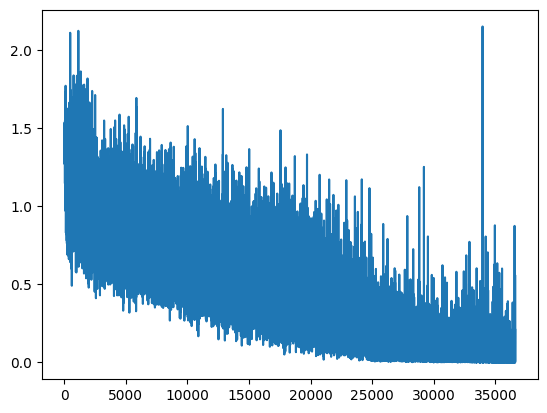

In [44]:
plt.plot(train_losses)

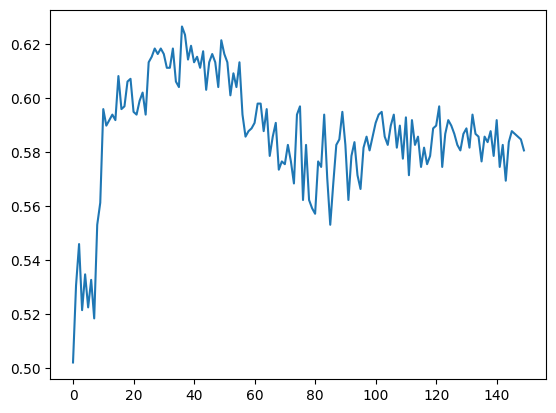

In [45]:
plt.plot(test_accuracy)

In [46]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13mfcc_best_37epoch.pt
Correct: 614/976 (0.6291)
{'acc_detail': tensor([0.7126, 0.5370, 0.7480, 0.5040], device='cuda:0'),
 'acc_unweighted': tensor(0.6254, device='cuda:0'),
 'acc_weighted': tensor(0.6291, device='cuda:0'),
 'f1s_detail': tensor([0.7183, 0.5309, 0.7280, 0.5194], device='cuda:0'),
 'f1s_unweighted': tensor(0.6241, device='cuda:0'),
 'f1s_weighted': tensor(0.6280, device='cuda:0'),
 'precision_detail': tensor([0.7240, 0.5249, 0.7090, 0.5359], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.5370, 0.7480, 0.5040], device='cuda:0'),
 'rocauc': tensor(0.8527, device='cuda:0'),
 'rocauc_detail': tensor([0.9103, 0.8154, 0.9152, 0.7700], device='cuda:0'),
 'uar': tensor(0.6254, device='cuda:0'),
 'wap': tensor(0.6274, device='cuda:0')}


tensor([[181,  12,   7,  54],
        [ 15, 116,  45,  40],
        [  4,  44, 190,  16],
        [ 50,  49,  26, 127]], device='cuda:0')

In [47]:
checkpoint_path = f'../models_cremad4/cremad4_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [48]:
model

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [49]:
from IConNet.visualizer import display_module

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



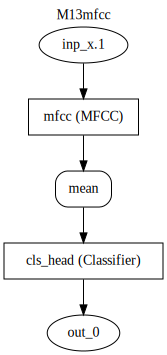

In [50]:
input_shape = (1,1,16000)
model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



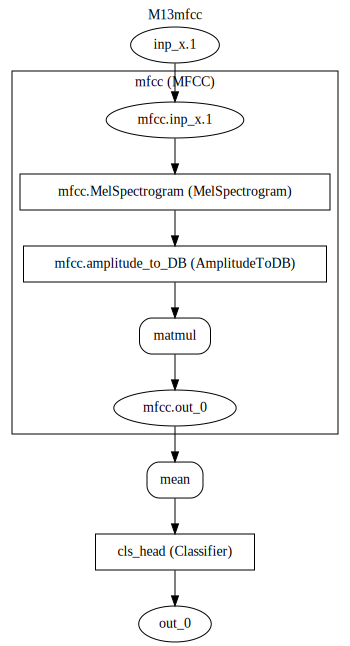

In [51]:
display_module(
    model, input, 
    classes_to_visit={"MFCC"})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



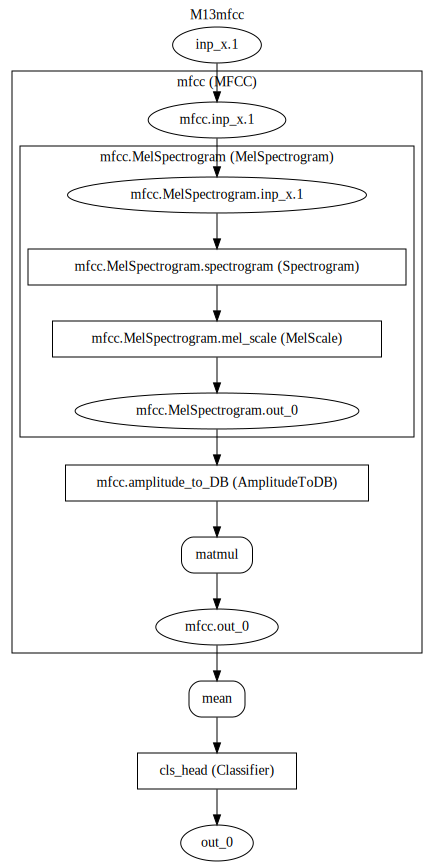

In [52]:
display_module(
    model, input, 
    classes_to_visit={"MFCC", "MelSpectrogram"})

aten::matmul %10 : Float(1, 1, 122, 40, strides=[4880, 4880, 40, 1], requires_grad=0, device=cuda:0) = aten::matmul(%9, %dct_mat), scope: __module.mfcc # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:707:0

aten::mean %x : Float(1, 40, strides=[40, 1], requires_grad=0, device=cuda:0) = aten::mean(%x.7, %197, %198, %199) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



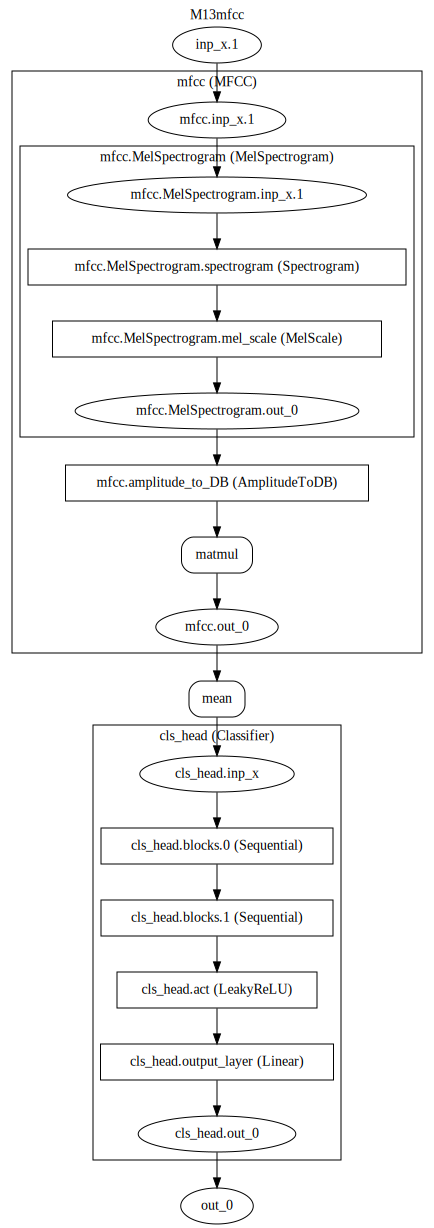

In [53]:
display_module(
    model, input, 
    classes_to_visit={"MFCC", "MelSpectrogram", "Classifier"})

In [54]:
# del model
# del best_model
# gc.collect()

737